# Preliminary Analysis

Initial analysis of offline evaluation experimentation on baseline recommender systems.

### Setup

Import libraries.

In [1]:
from itertools import repeat
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns
import pandas as pd
from pathlib import Path
import re

### Load evaluation results

Experiment components:

1. True preference data generator (nuser 943, nitem 1682, density 0.5):
    - Indian Buffet Process
    - Uniform generator
    
2. Observation sampler:
    - Popular sampler
    - Uniform sampler
    
3. Evaluation Protocal:
    - Partition by user on user-item dense matrix, sample 0.2 items for test per user.
    
4. Recommenders
    - Popular
    - Random
    - Oracle

Evaluation results come from the combination of all the components.

In [2]:
build_path = Path('build') / 'simulation_results'
pattern = re.compile('simulate.*pkl')

In [3]:
simulation_results = [x for x in build_path.iterdir() if x.is_file() and re.match(pattern, x.name)]

In [4]:
results = []
for p in simulation_results:
    with open(p, 'rb') as f:
        result = pkl.load(f)
        nalgos = len(result['algorithm'].unique())
        nruns = int(len(result) / nalgos)
        result['no'] = np.repeat(range(nruns), nalgos)
        model, dataset, *stats = p.name.split('-')
        stats = '-'.join(stats).replace('.pkl', '')
        _, pref_name, obs_name, _ = model.split('_')
        result['generator'] = pref_name
        result['sampler'] = obs_name
        result['stats_to_tune'] = stats
        result['dataset'] = dataset
        results.append(result)
results = pd.concat(results, axis=0, ignore_index=True)

In [5]:
results = results[results['dataset'] != 'ml_100k'].copy()

In [6]:
results.head() 

,algorithm,precision_obs,recall_obs,recip_rank_obs,ndcg_obs,precision_pref,recall_pref,recip_rank_pref,ndcg_pref,no,generator,sampler,stats_to_tune,dataset
0,Oracle,0.058473,0.848958,0.145906,0.269352,1.000000,0.849363,1.000000,0.904570,0,lda,unif,all,az_music_5core
1,Popular,0.002563,0.057949,0.013114,0.018387,0.062563,0.053971,0.217705,0.059340,0,lda,unif,all,az_music_5core
2,Random,0.000610,0.013719,0.003146,0.004298,0.016726,0.014412,0.064261,0.014177,0,lda,unif,all,az_music_5core
3,Oracle,0.057165,0.849231,0.141158,0.267481,1.000000,0.852062,1.000000,0.906257,1,lda,unif,all,az_music_5core
4,Popular,0.002400,0.053515,0.013575,0.017804,0.059906,0.052061,0.225690,0.058601,1,lda,unif,all,az_music_5core


In [7]:
metric_mean = results[results['stats_to_tune'] != 'all'].groupby(['dataset', 'stats_to_tune', 'sampler', 'generator', 'algorithm']).agg(['mean', 'std']).stack(1).unstack(-2).unstack()[['precision_obs', 'precision_pref', 'recall_obs', 'recall_pref', 'recip_rank_obs', 'recip_rank_pref', 'ndcg_obs', 'ndcg_pref']]
metric_mean.to_csv('build/simulation_results/metric_mean.csv')
metric_mean.head()

precision_obs            \
algorithm                                             Oracle             
                                                        mean       std   
dataset        stats_to_tune sampler generator                           
az_music_5core icorr         pop     ibp            0.767199  0.037143   
                                     lda            0.101378  0.002560   
                             unif    ibp            0.090245  0.004320   
                                     lda            0.051484  0.002056   
               item-pop      pop     ibp            0.765780  0.006565   

                                                                              \
algorithm                                        Popular              Random   
                                                    mean       std      mean   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.059910  0.009051  0.003442   
                                     lda        0.008784  0.000375  0.001280   
                             unif    ibp        0.042293  0.002017  0.000108   
                                     lda        0.005494  0.000289  0.001305   
               item-pop      pop     ibp        0.006241  0.000343  0.000471   

                                                         precision_pref       \
algorithm                                                        Oracle        
                                                     std           mean  std   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.000558            1.0  0.0   
                                     lda        0.000071            1.0  0.0   
                             unif    ibp        0.000019            1.0  0.0   
                                     lda        0.000074            1.0  0.0   
               item-pop      pop     ibp        0.000040            1.0  0.0   

                                                                    ...  \
algorithm                                        Popular            ...   
                                                    mean       std  ...   
dataset        stats_to_tune sampler generator                      ...   
az_music_5core icorr         pop     ibp        0.105168  0.026989  ...   
                                     lda        0.051533  0.001118  ...   
                             unif    ibp        0.726370  0.027629  ...   
                                     lda        0.136167  0.005787  ...   
               item-pop      pop     ibp        0.007572  0.000393  ...   

                                                ndcg_obs                      \
algorithm                                        Popular              Random   
                                                    mean       std      mean   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.665727  0.046610  0.017067   
                                     lda        0.116894  0.007823  0.013744   
                             unif    ibp        0.065272  0.002445  0.000169   
                                     lda        0.043895  0.002519  0.009359   
               item-pop      pop     ibp        0.038414  0.002763  0.002320   

                                                         ndcg_pref            \
algorithm                                                   Oracle             
                                                     std      mean       std   
dataset        stats_to_tune sampler generator                                 
az_music_5core icorr         pop     ibp        0.001402  0.993759  0.001247   
                                     lda        0.000882  0.973638  0.001429   
                             unif    ibp        0.000050  0.2

In [9]:
metric_quantil = results[results['stats_to_tune'] != 'all'].groupby(['dataset', 'stats_to_tune', 'sampler', 'generator', 'algorithm']).quantile([0.025, 0.975])[['precision_obs', 'precision_pref', 'recall_obs', 'recall_pref', 'recip_rank_obs', 'recip_rank_pref', 'ndcg_obs', 'ndcg_pref']].unstack(-2).unstack().to_csv('build/simulation_results/metric_95Interval.csv')

### Plot the results

In [10]:
def extract_result(sims_results, metric='precision', stats_to_tune='icorr', dataset=None):
    """Extracts simulation results for a given evaluation metric, tuned statistic and dataset"""
    obs_label = ''.join([metric, '_obs'])
    pref_label = ''.join([metric, '_pref'])
    result = sims_results[['algorithm', obs_label, pref_label, 'no', 'generator', 'sampler', 'stats_to_tune', 'dataset']]
    if stats_to_tune:
        result = result[result['stats_to_tune'] == stats_to_tune]
    if dataset:
        result = result[result['dataset'] == dataset]
    result = result.rename(columns={obs_label: 'observation', pref_label: 'preference'})
    result['error'] = result['observation'] - result['preference']
    return result

### Boxplot and Bar Chart

In [11]:
def plot_metric_stats(data, metric, metric_on, plot_func, style='seaborn-talk', **kwargs):
    df = data[['algorithm', 'generator', 'sampler', metric_on, 'dataset']]
    row_order = np.sort(data['generator'].unique())
    col_order = np.sort(data['sampler'].unique())
    with plt.style.context(style):
        g = sns.FacetGrid(df, row='generator', col='sampler', 
                          sharey=True, sharex=True, 
                          height=8, margin_titles=True, legend_out=True,
                          row_order=row_order, col_order=col_order)
        g = g.map(plt.axhline)
        g = (g.map(plot_func, 'algorithm', metric_on, 'dataset', **kwargs)
             .set_ylabels('-'.join([metric, metric_on]))
             .add_legend())
    plt.show()

In [12]:
def plot_metric_stats_dtype(data, metric, plot_func, style='seaborn-poster', **kwargs):
    df = data[['algorithm', 'generator', 'sampler', 'observation', 'preference', 'dataset']]
    row_order = np.sort(data['generator'].unique())
    col_order = np.sort(data['sampler'].unique())
    df_tall = df.melt(id_vars=['algorithm', 'generator', 'sampler', 'dataset'], 
                      var_name='dtype', value_name='metric')
    df_tall['dtype'] = df_tall[['dtype', 'dataset']].apply(lambda x: '-'.join(x), axis=1)

    with plt.style.context(style):
        g = sns.FacetGrid(df_tall, row='generator', col='sampler', 
                          sharey=True, sharex=True, 
                          height=8, margin_titles=True, 
                          legend_out=True, 
                          row_order=row_order, col_order=col_order)
        g = (g.map(plot_func, 'algorithm', 'metric', 'dtype', **kwargs)
             .add_legend()
             .set_ylabels(metric))
    plt.show()

In [13]:
dataset = ['ml_1m', 'az_music_5core', 'steam_video_game']
obs_hue_order = map(lambda x, y: '-'.join([x, y]), repeat('observation'), dataset)
pref_hue_order = map(lambda x, y: '-'.join([x, y]), repeat('preference'), dataset)
hue_order = []
for x in zip(pref_hue_order, obs_hue_order):
    hue_order.extend(x)

In [14]:
def rank_algos(data, metric='precision', stats_to_tune='icorr', algo_pair=('Oracle', 'Popular')):
    data_pivot = data.drop(['error', 'stats_to_tune'], axis=1).pivot_table(index=['no', 'generator', 'sampler', 'dataset'], columns='algorithm')
    algo1, algo2 = algo_pair
    obs_rank = (data_pivot['observation'][algo1] >= data_pivot['observation'][algo2])
    obs_rank = obs_rank.groupby(level=['generator', 'sampler', 'dataset']).sum().rename('observation')
    pref_rank = (data_pivot['preference'][algo1] >= data_pivot['preference'][algo2])
    pref_rank = pref_rank.groupby(level=['generator', 'sampler', 'dataset']).sum().rename('preference')
    return pd.concat([obs_rank, pref_rank], axis=1).stack().rename('count').reset_index().rename(columns={'level_3': 'data_model'})

In [15]:
def plot_rank_percentage(data, style='seaborn-paper', palette='husl', **kwargs):
    with plt.style.context(style), sns.color_palette(palette):
        g = sns.FacetGrid(data, row='generator', col='sampler', 
                          sharey=False, sharex=True, 
                          height=5, margin_titles=True, legend_out=True)
        g = (g.map(sns.barplot, 'dataset', 'count', 'data_model', **kwargs)
             .add_legend())
        plt.show()

**Precision**

In [16]:
data2plot = extract_result(results, metric='precision', stats_to_tune='icorr')

In [17]:
data2plot.head(6)

,algorithm,observation,preference,no,generator,sampler,stats_to_tune,dataset,error
300,Oracle,0.353980,1.000000,0,lda,pop,icorr,ml_1m,-0.646020
301,Popular,0.119106,0.441086,0,lda,pop,icorr,ml_1m,-0.321980
302,Random,0.015805,0.104579,0,lda,pop,icorr,ml_1m,-0.088775
303,Oracle,0.351831,1.000000,1,lda,pop,icorr,ml_1m,-0.648169
304,Popular,0.110563,0.424295,1,lda,pop,icorr,ml_1m,-0.313732
305,Random,0.015583,0.104593,1,lda,pop,icorr,ml_1m,-0.089010


In [18]:
boxplot_kwargs = dict(order=['Oracle', 'Popular', 'Random'],
                      hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                      palette='husl', 
                      showmeans=True, meanprops=dict(markerfacecolor='black'))

In [19]:
# def plot_stacked_bar(*args, **kwargs):
#     kwargs.pop('color')
#     ax = plt.gca()
#     a = pd.concat(args, axis=1)
#     a = a.set_index('stats_to_tune')
#     n = 3
#     x = np.arange(n).astype(np.float) * 5
#     for stat in a.index.unique():
#         y1 = a.loc[stat, False].values
#         y1 = np.append(y1, [0]*(n-len(y1))).astype(np.int)
#         plt.bar(x, y1, **kwargs)
#         y2 = a.loc[stat, True].values
#         y2 = np.append(y2, [0]*(n-len(y2))).astype(np.int)
#         plt.bar(x, y2, bottom=y1, **kwargs)
#         x += 1
#     plt.xticks([2, 7, 12], a.dataset.unique())

In [17]:
# with plt.style.context('seaborn-talk'), sns.color_palette('husl', 8):
#     g = sns.FacetGrid(rank_counts, row='generator', col='sampler', 
#                       sharey=False, sharex=True, 
#                       height=5, margin_titles=True, legend_out=True)
#     g = (g.map(plot_stacked_bar, 'dataset', 'stats_to_tune', False, True, width=0.6))
# plt.show()

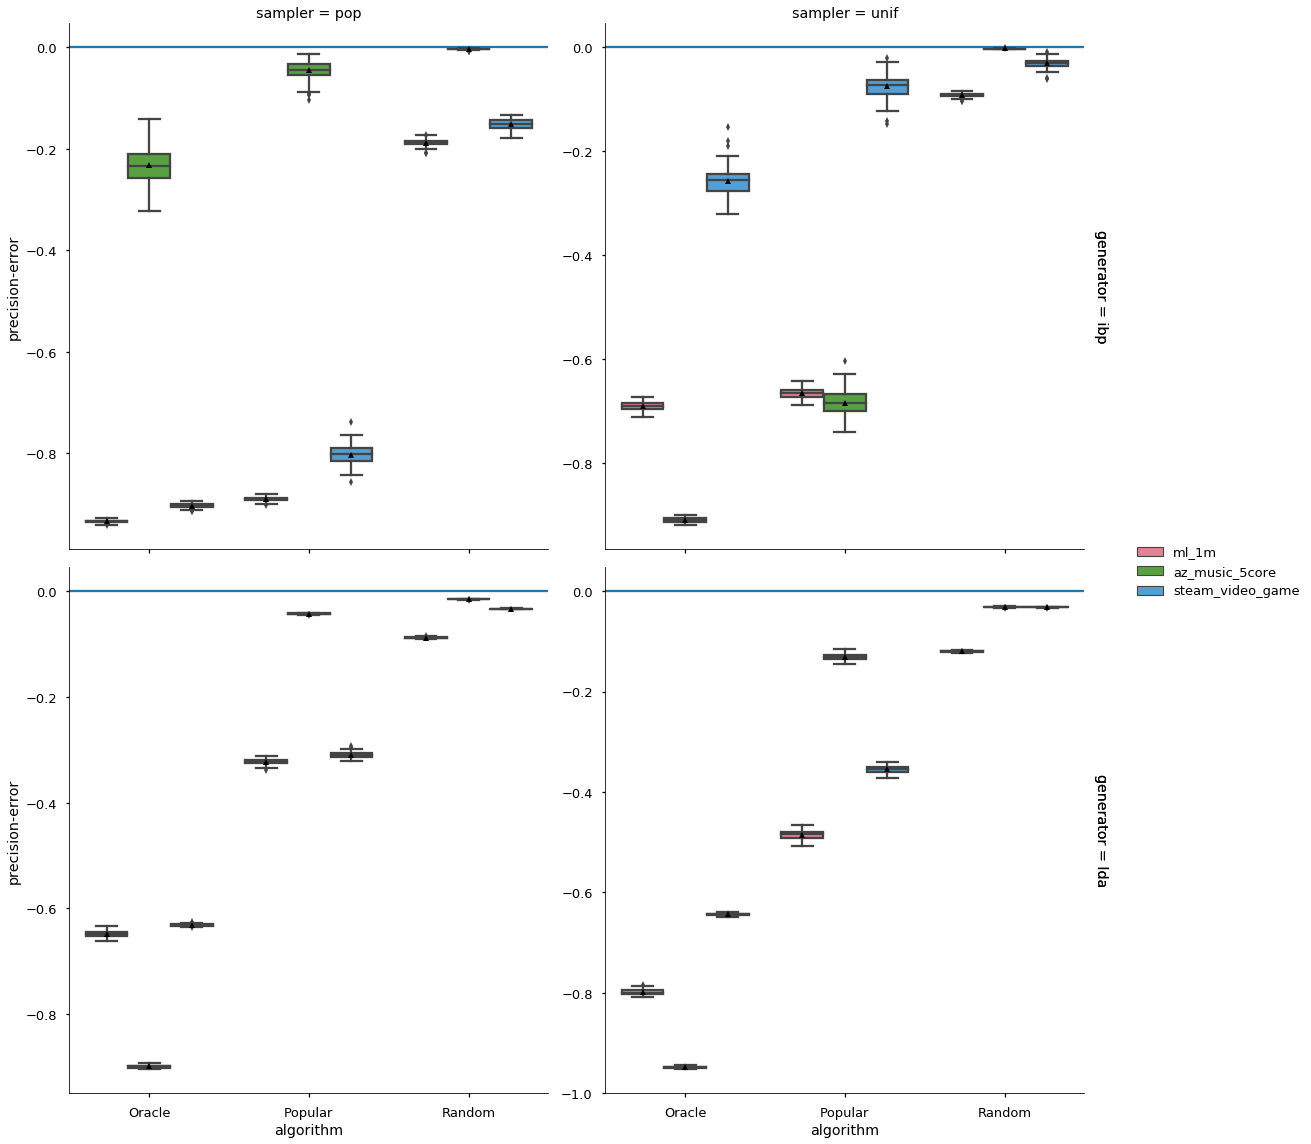

In [18]:
plot_metric_stats(data2plot, 'precision', 'error', sns.boxplot, **boxplot_kwargs)

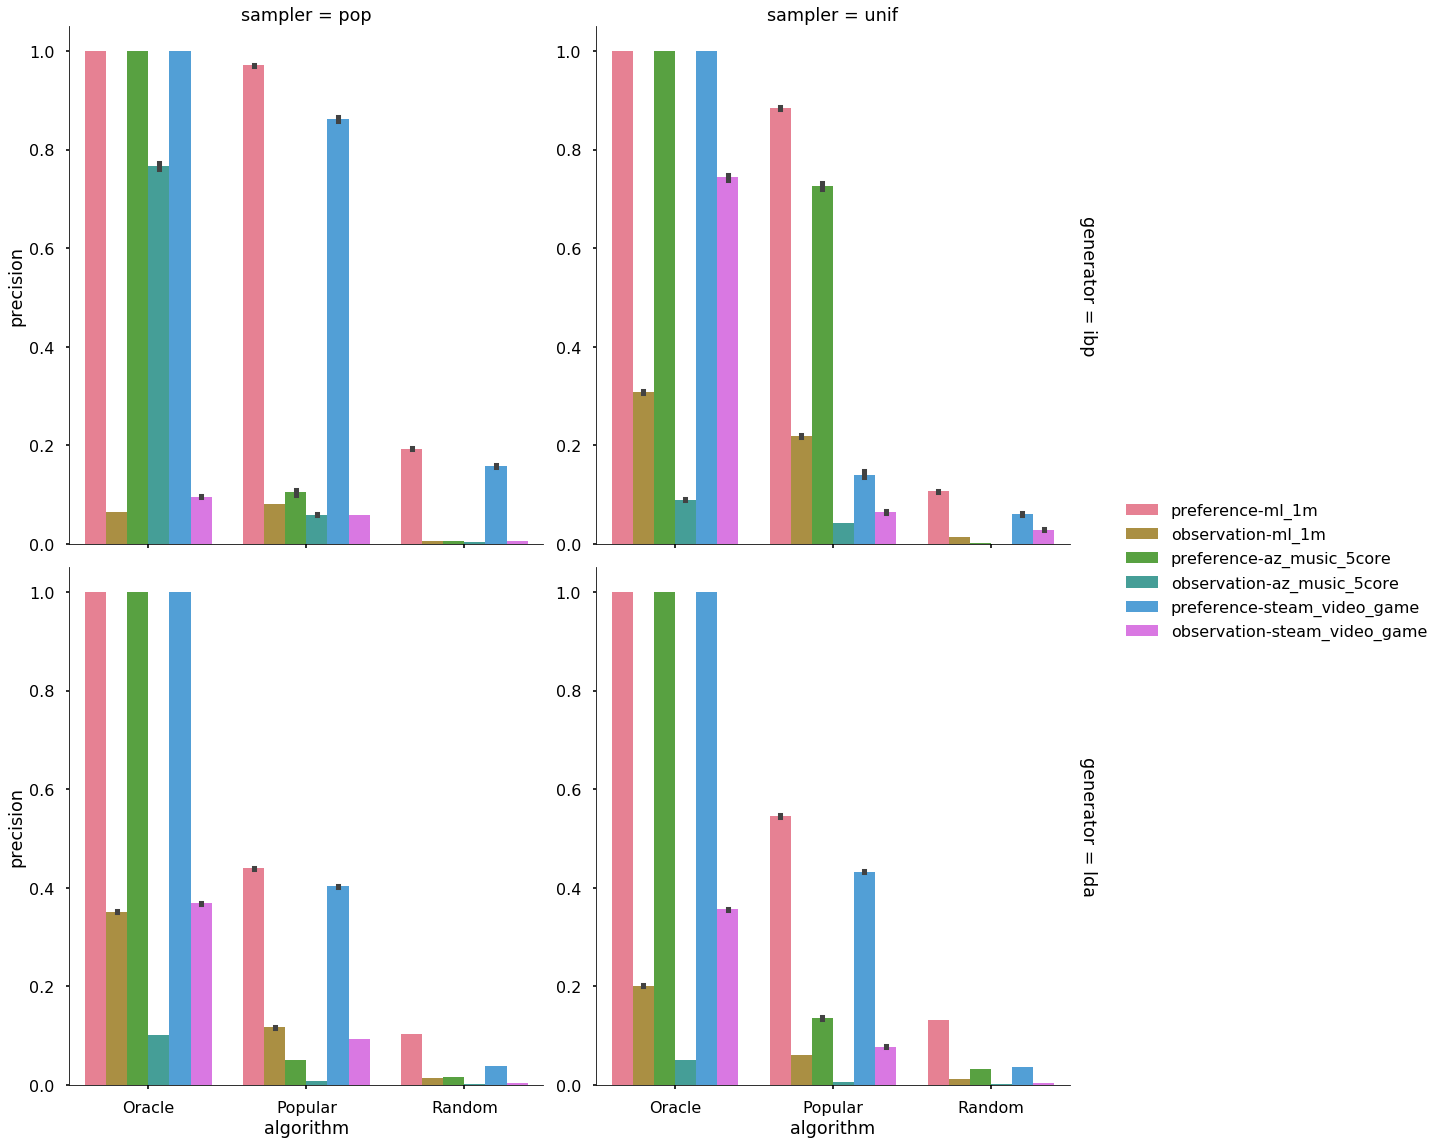

In [19]:
plot_metric_stats_dtype(data2plot, 'precision', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

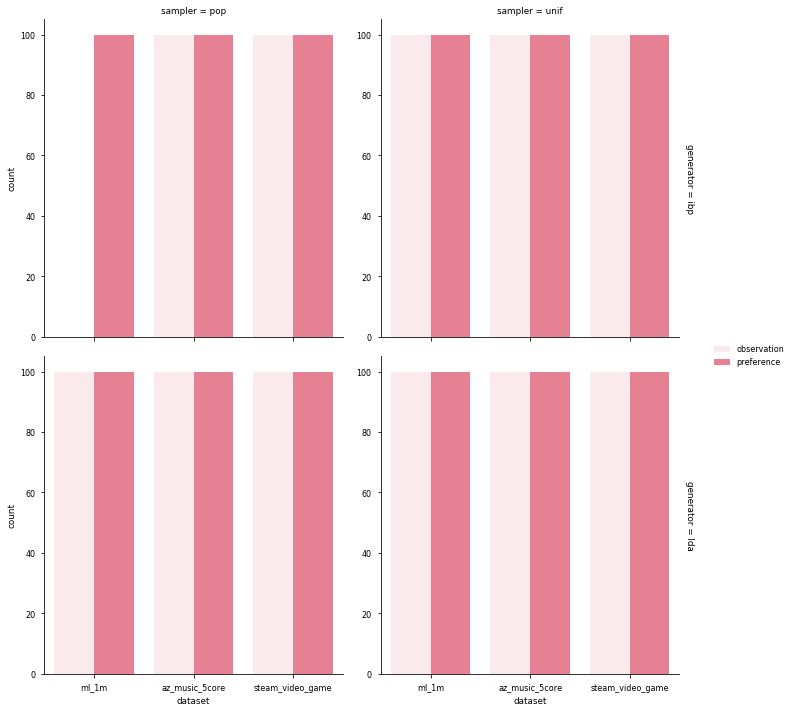

In [20]:
plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

### User User

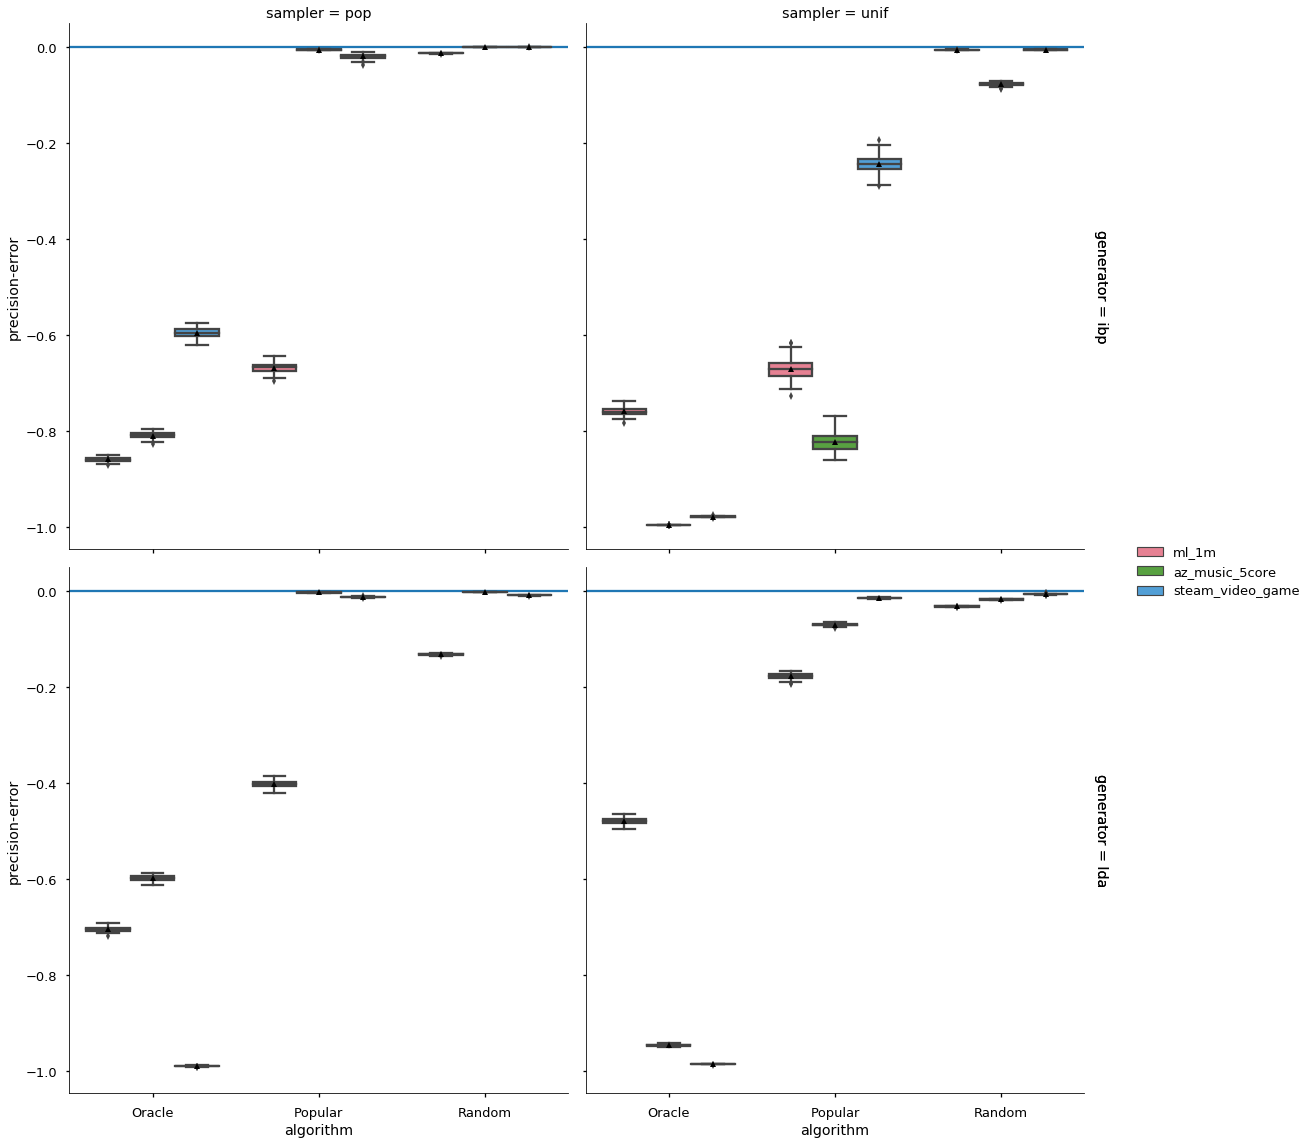

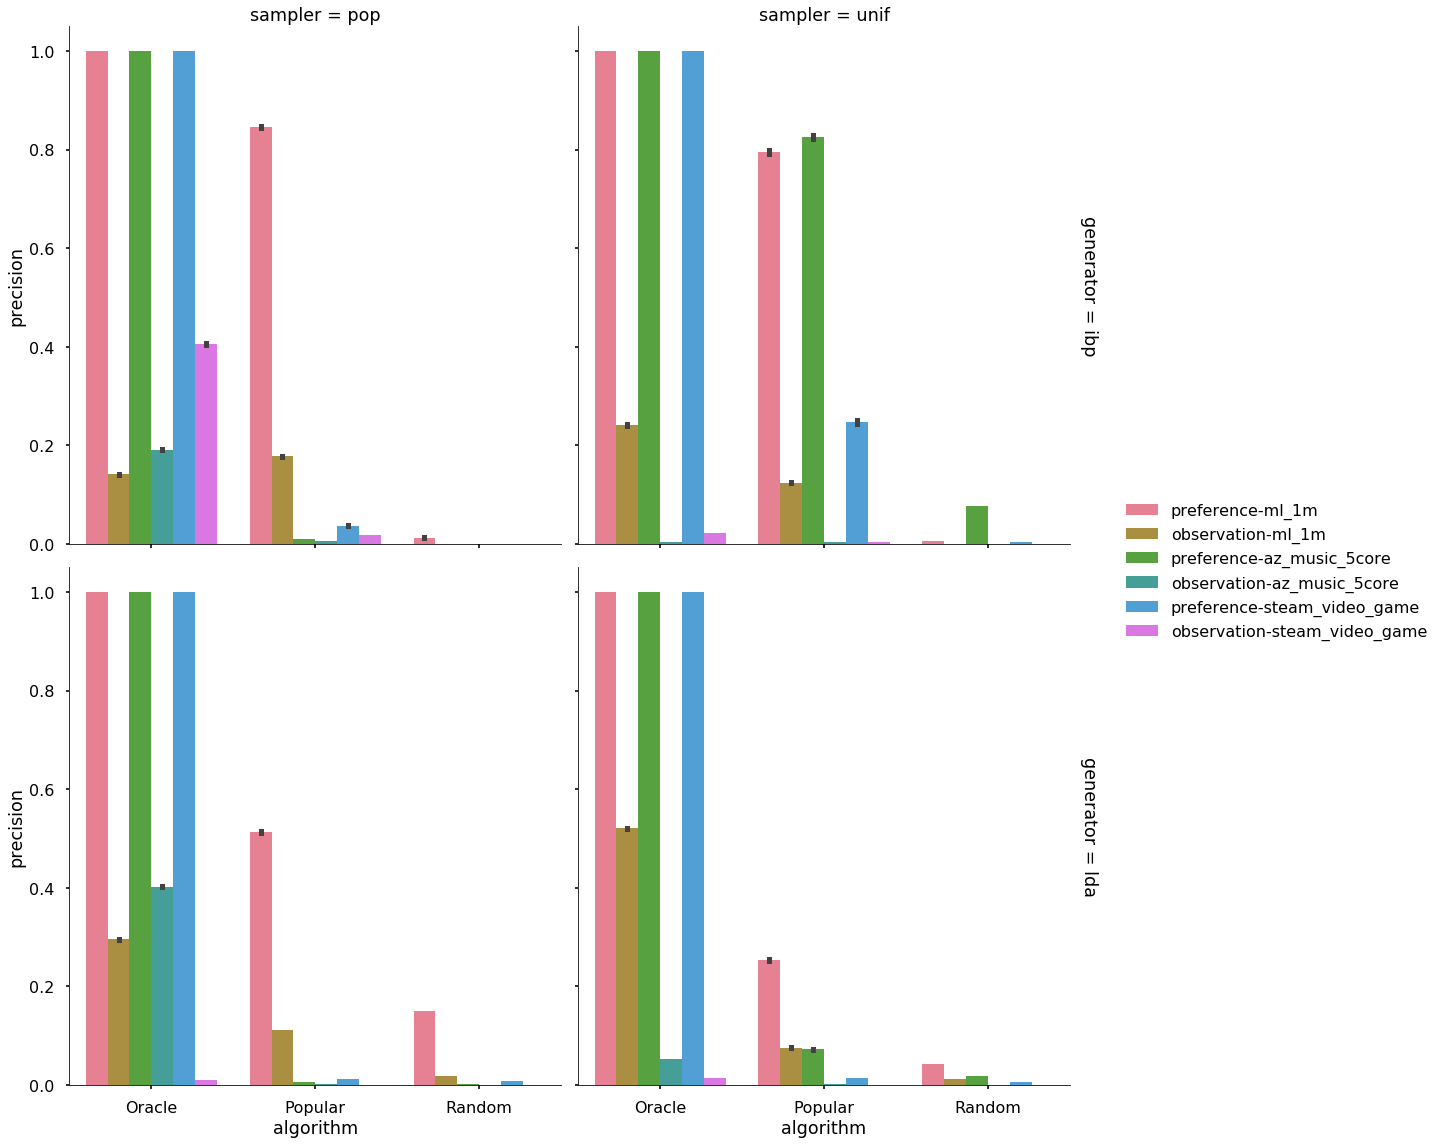

In [20]:
data2plot = extract_result(results, metric='precision', stats_to_tune='ucorr')

plot_metric_stats(data2plot, 'precision', 'error', sns.boxplot, **boxplot_kwargs)

plot_metric_stats_dtype(data2plot, 'precision', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

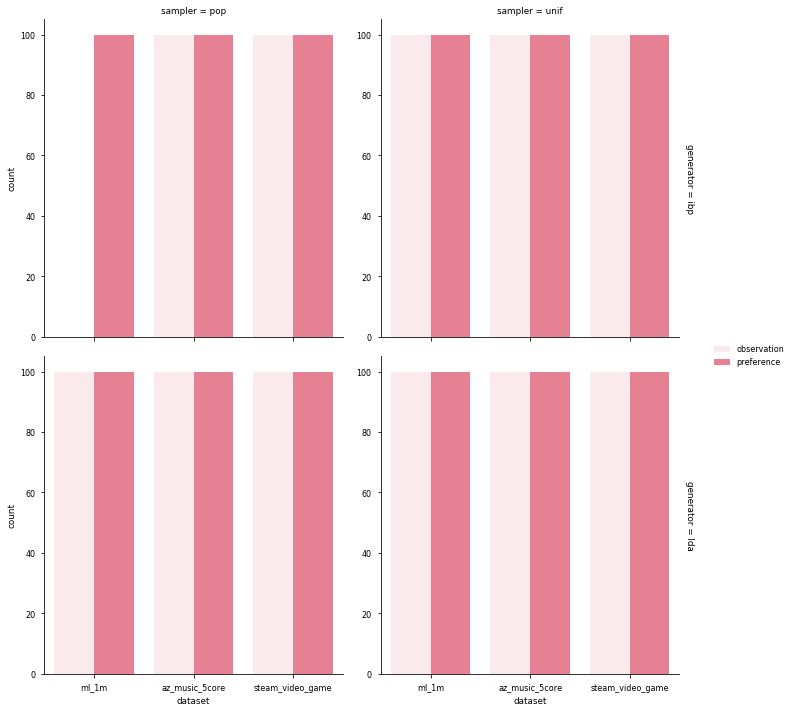

In [22]:
plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

### Item Pop

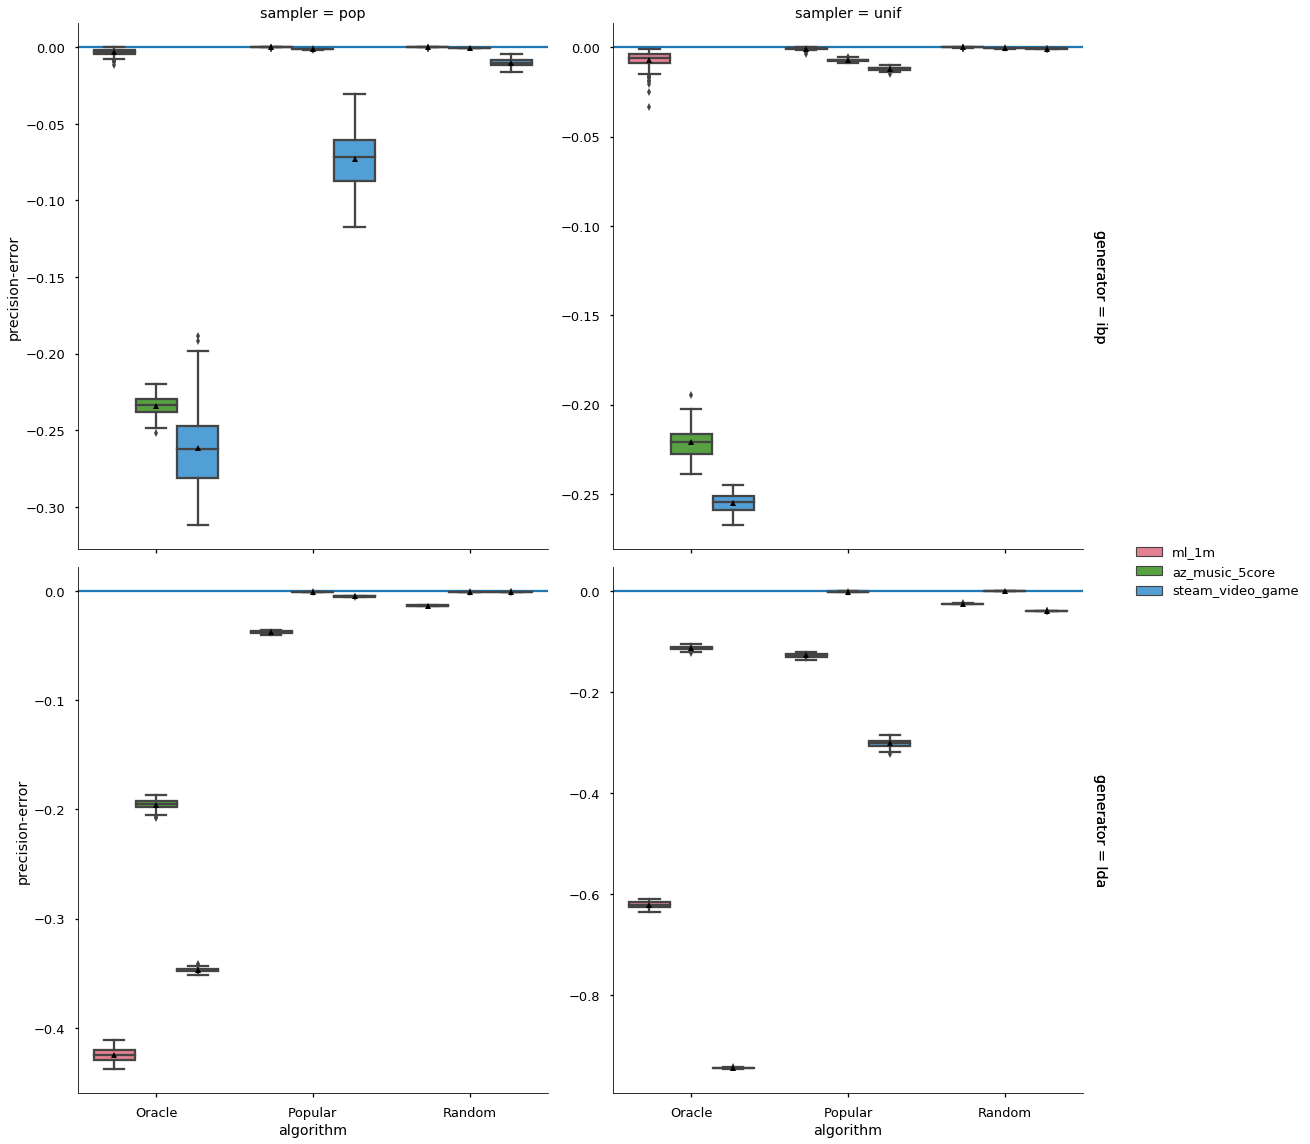

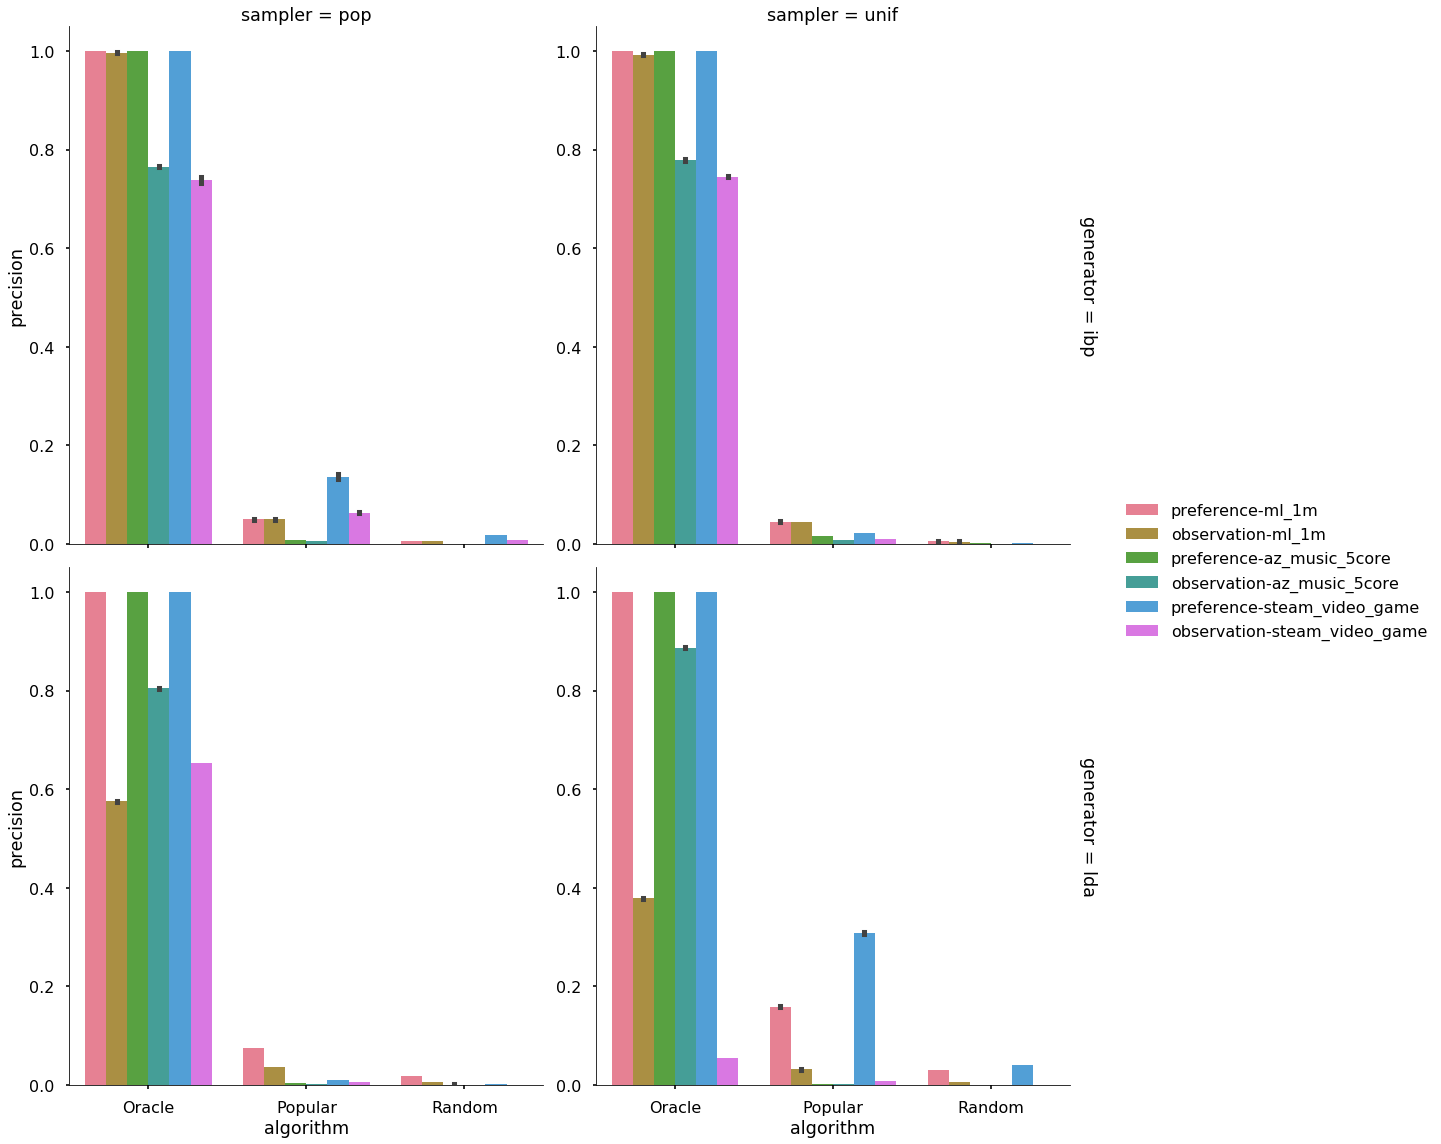

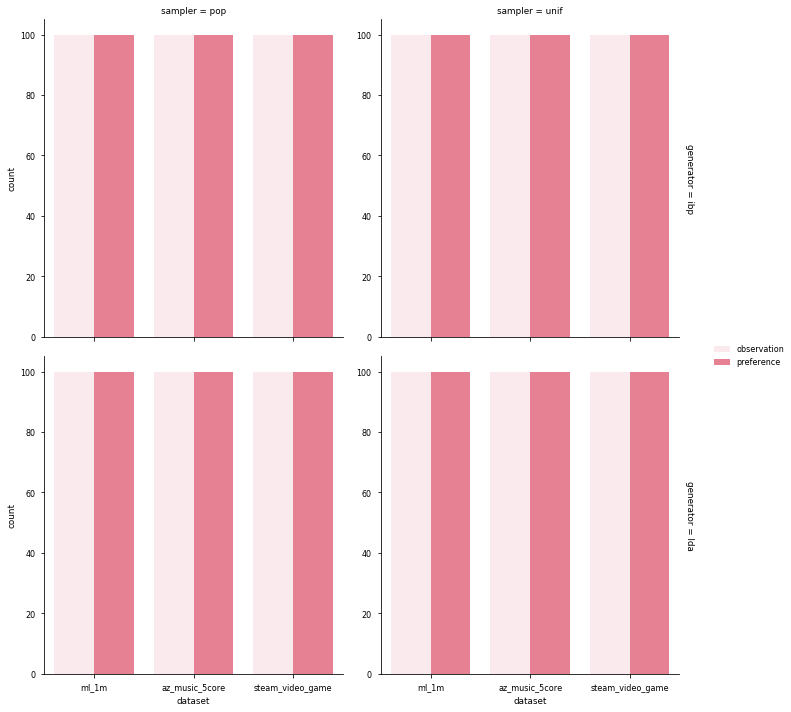

In [23]:
data2plot = extract_result(results, metric='precision', stats_to_tune='item-pop')

plot_metric_stats(data2plot, 'precision', 'error', sns.boxplot, **boxplot_kwargs)

plot_metric_stats_dtype(data2plot, 'precision', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

### User Activity

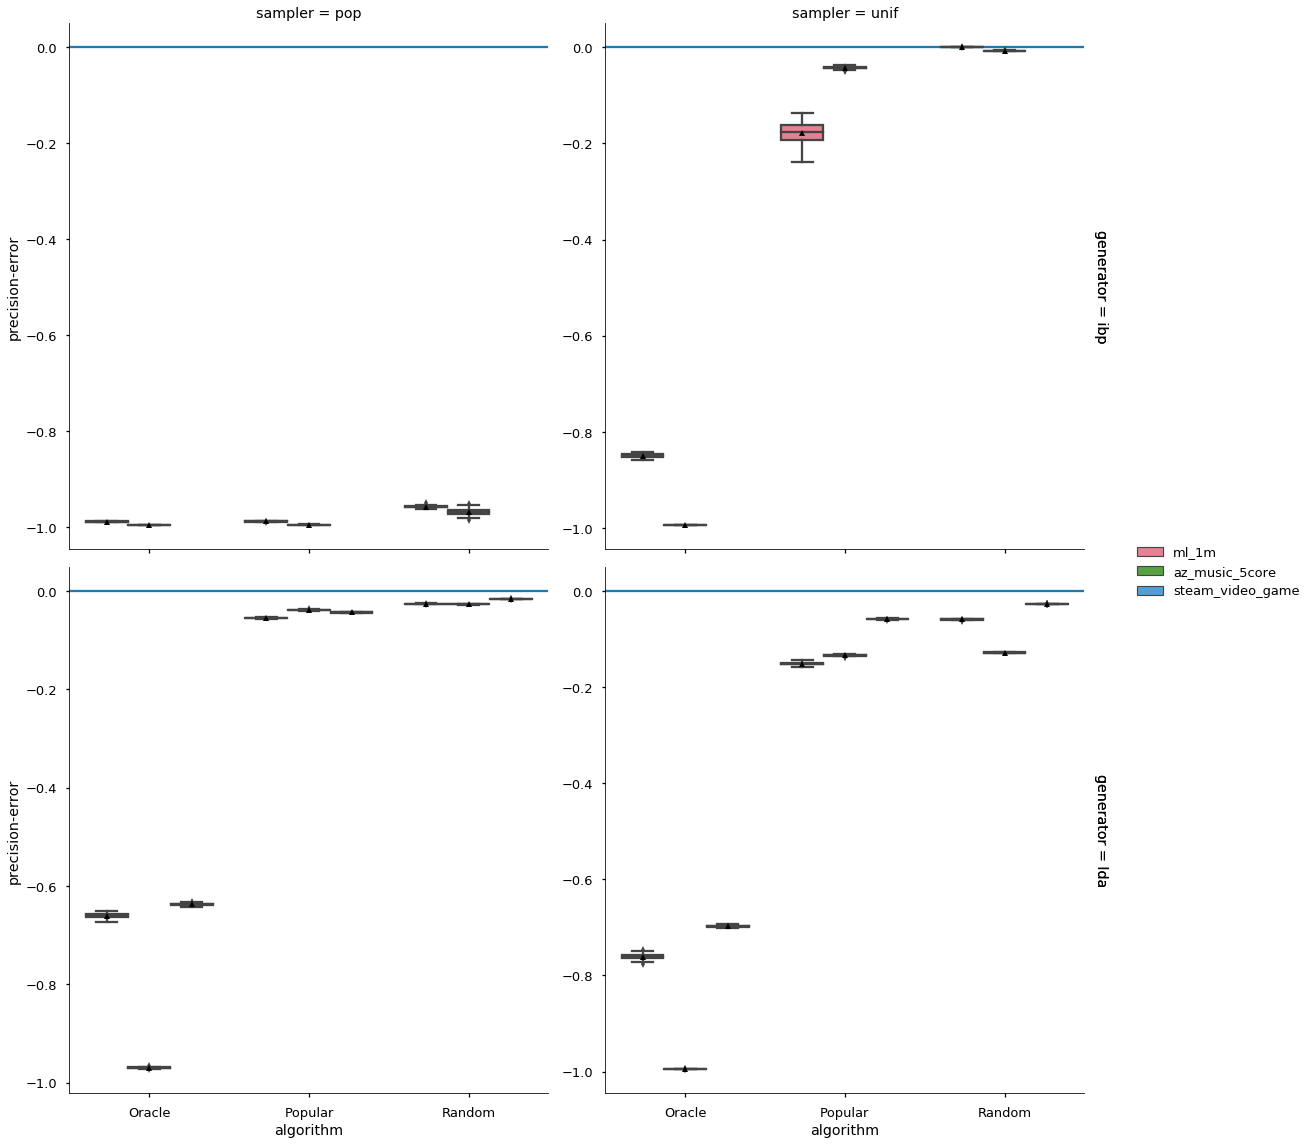

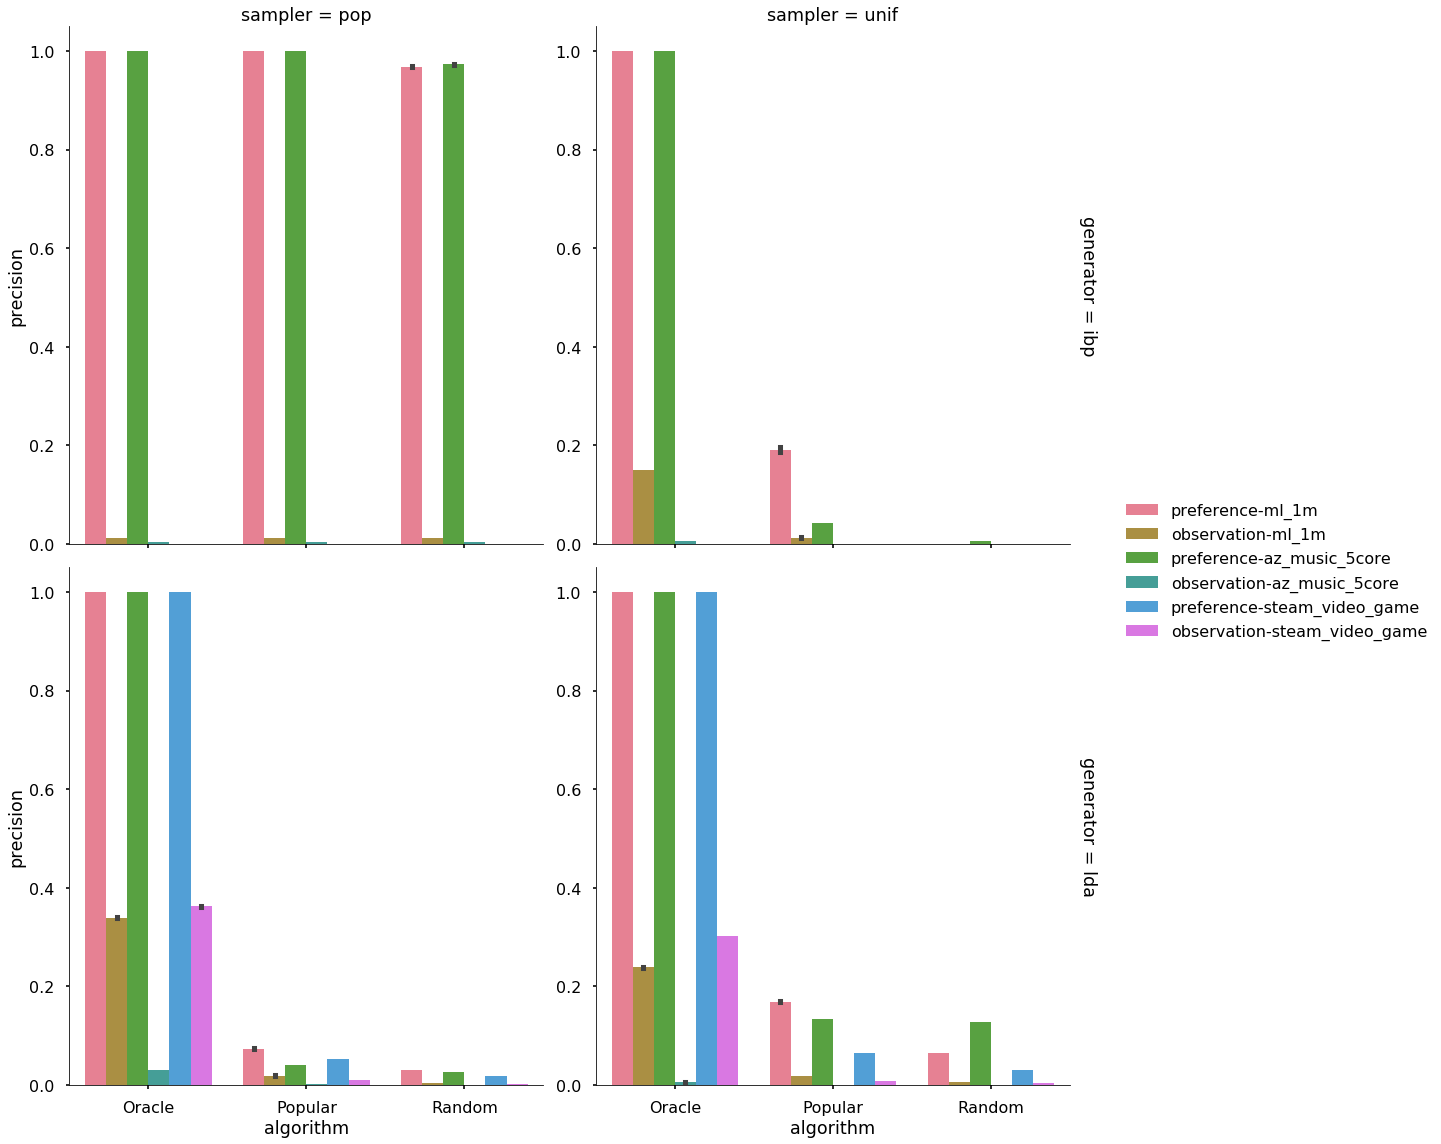

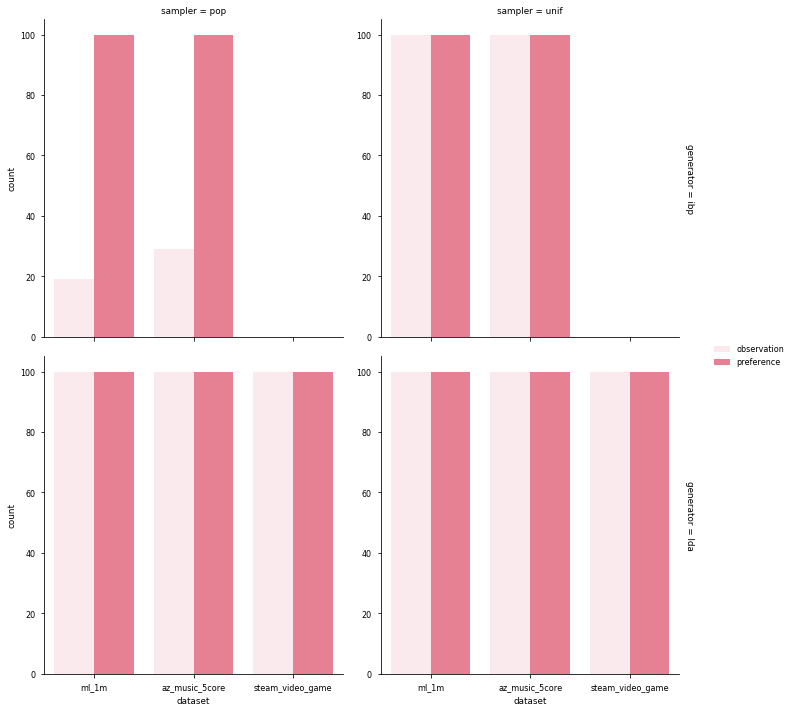

In [24]:
data2plot = extract_result(results, metric='precision', stats_to_tune='user-act')

plot_metric_stats(data2plot, 'precision', 'error', sns.boxplot, **boxplot_kwargs)

plot_metric_stats_dtype(data2plot, 'precision', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

### All

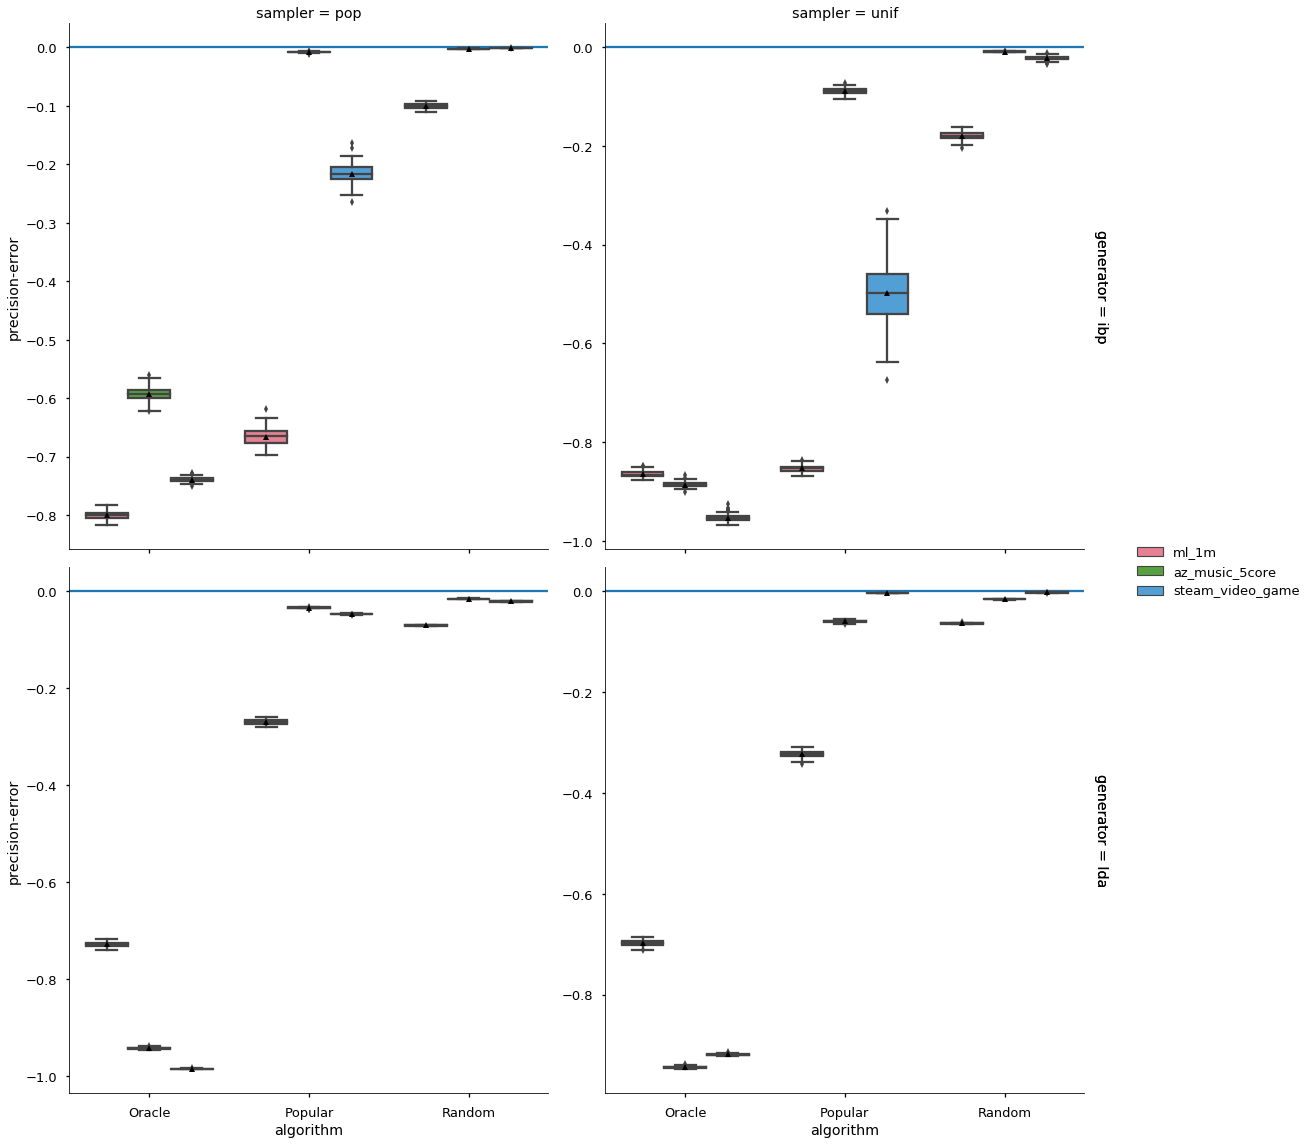

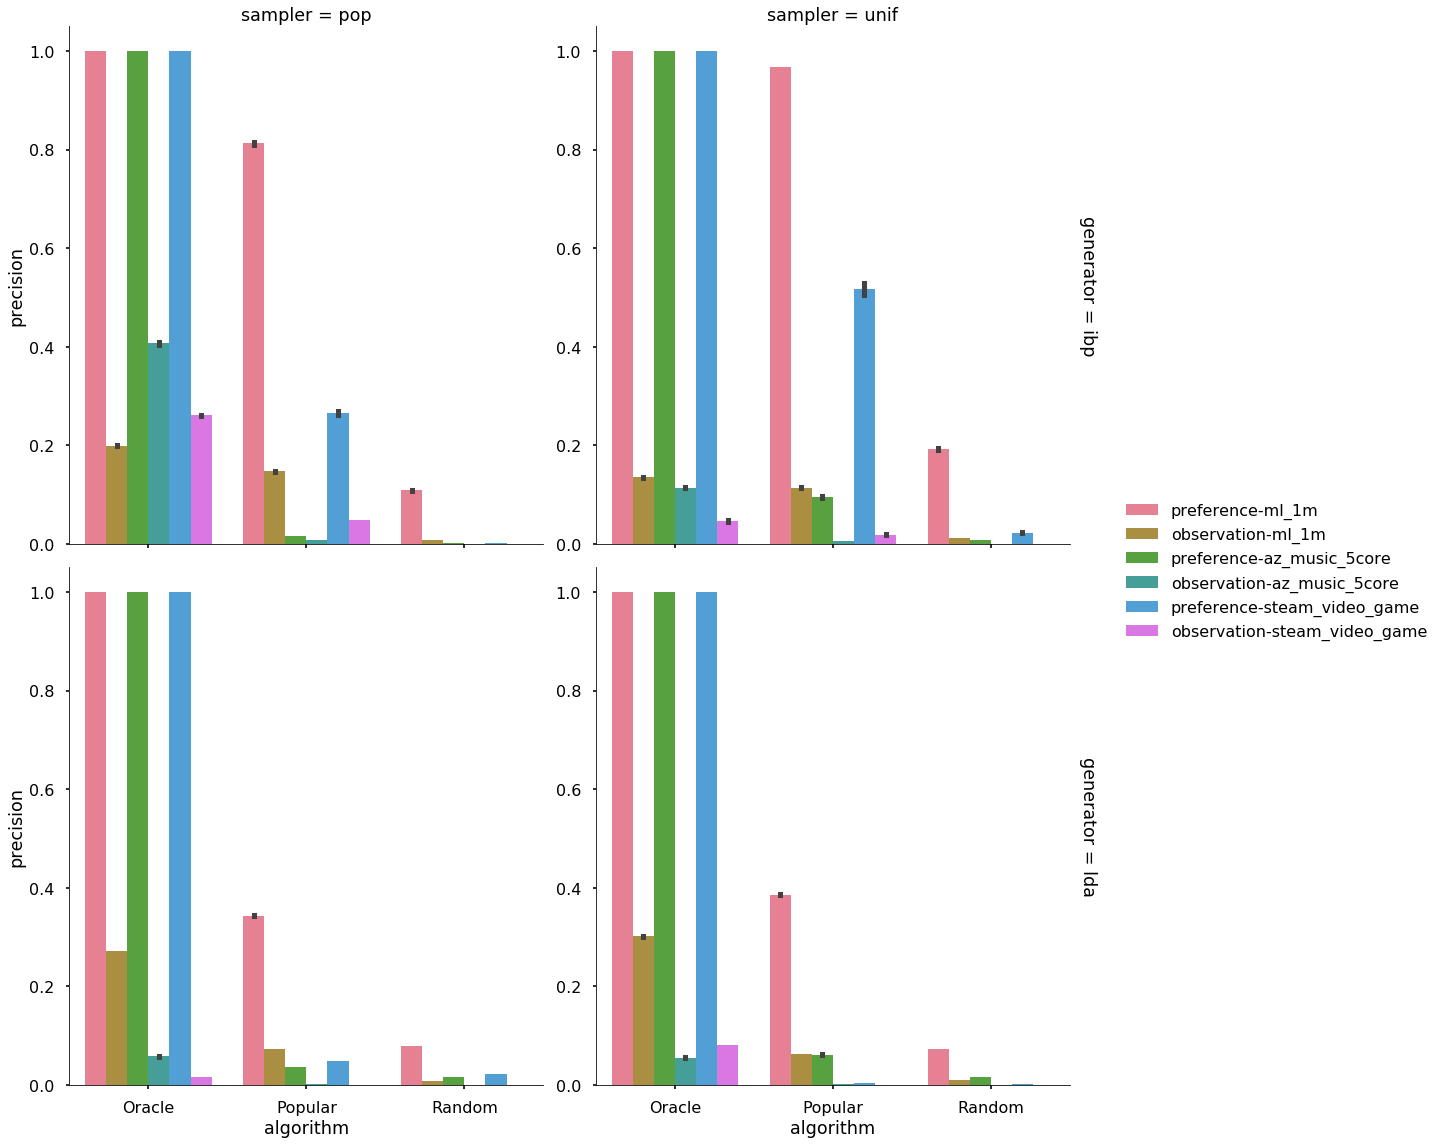

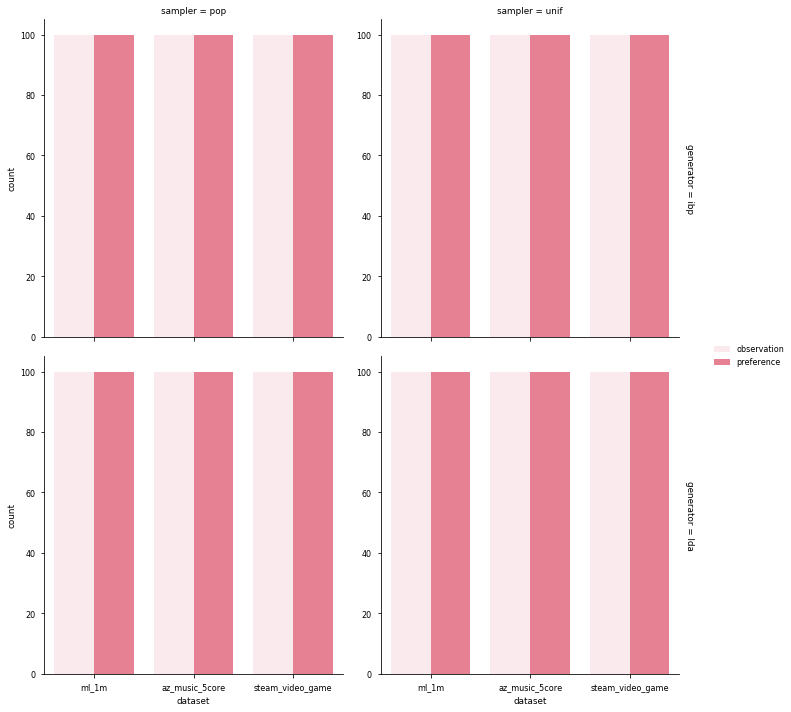

In [25]:
data2plot = extract_result(results, metric='precision', stats_to_tune='all')

plot_metric_stats(data2plot, 'precision', 'error', sns.boxplot, **boxplot_kwargs)

plot_metric_stats_dtype(data2plot, 'precision', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

**Recall**

In [26]:
data2plot = extract_result(results, metric='recall', stats_to_tune='icorr')

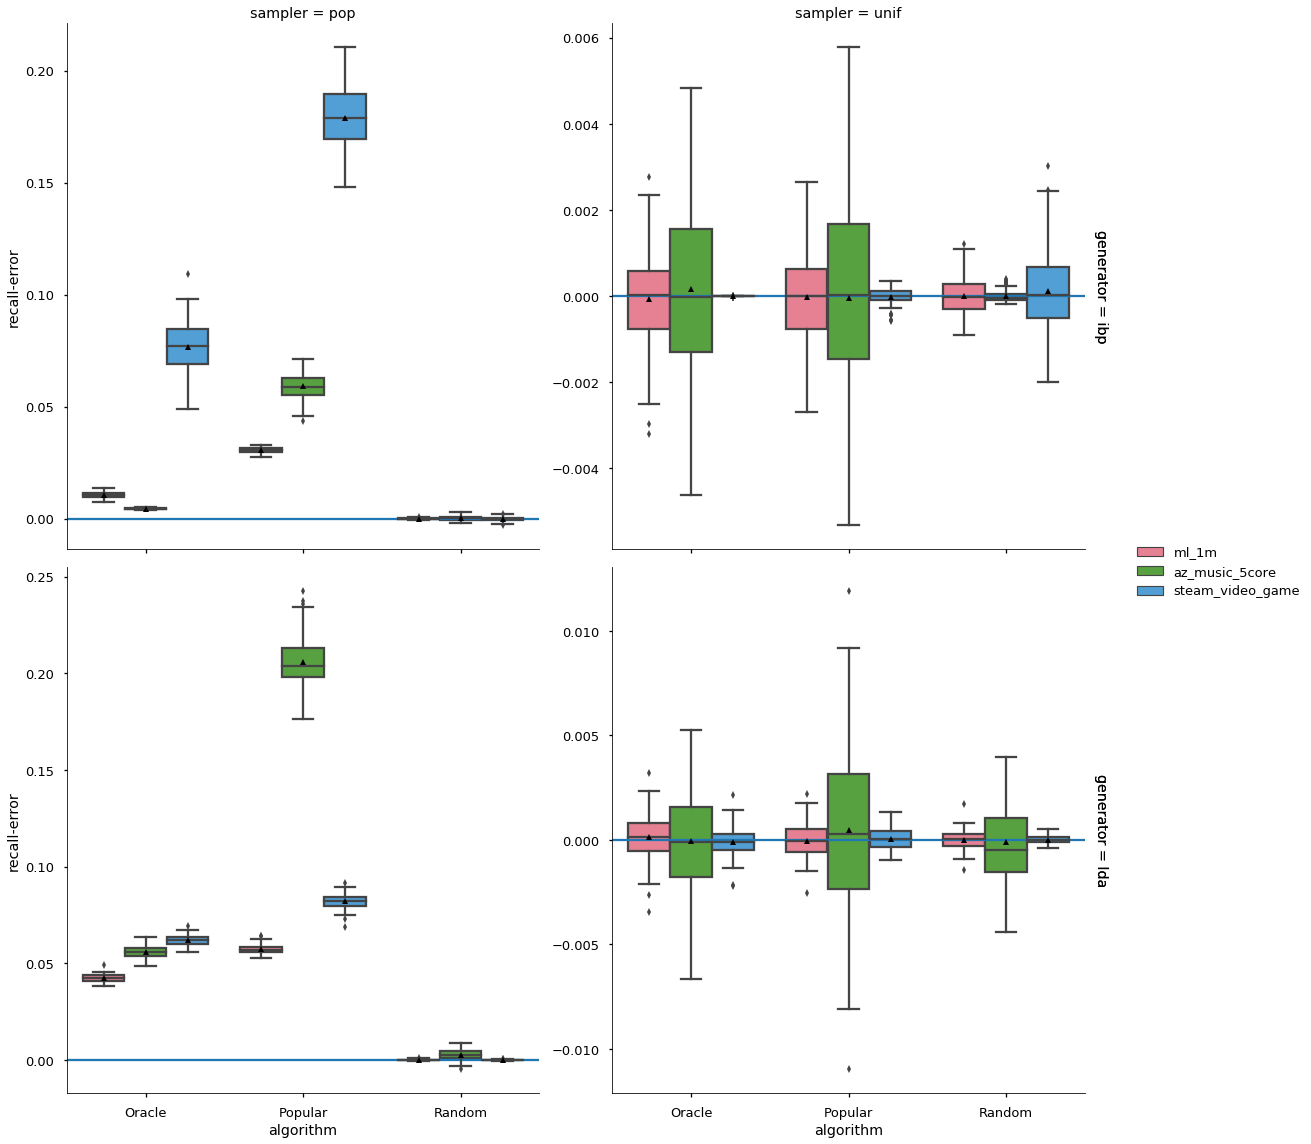

In [27]:
plot_metric_stats(data2plot, 'recall', 'error', sns.boxplot, **boxplot_kwargs)

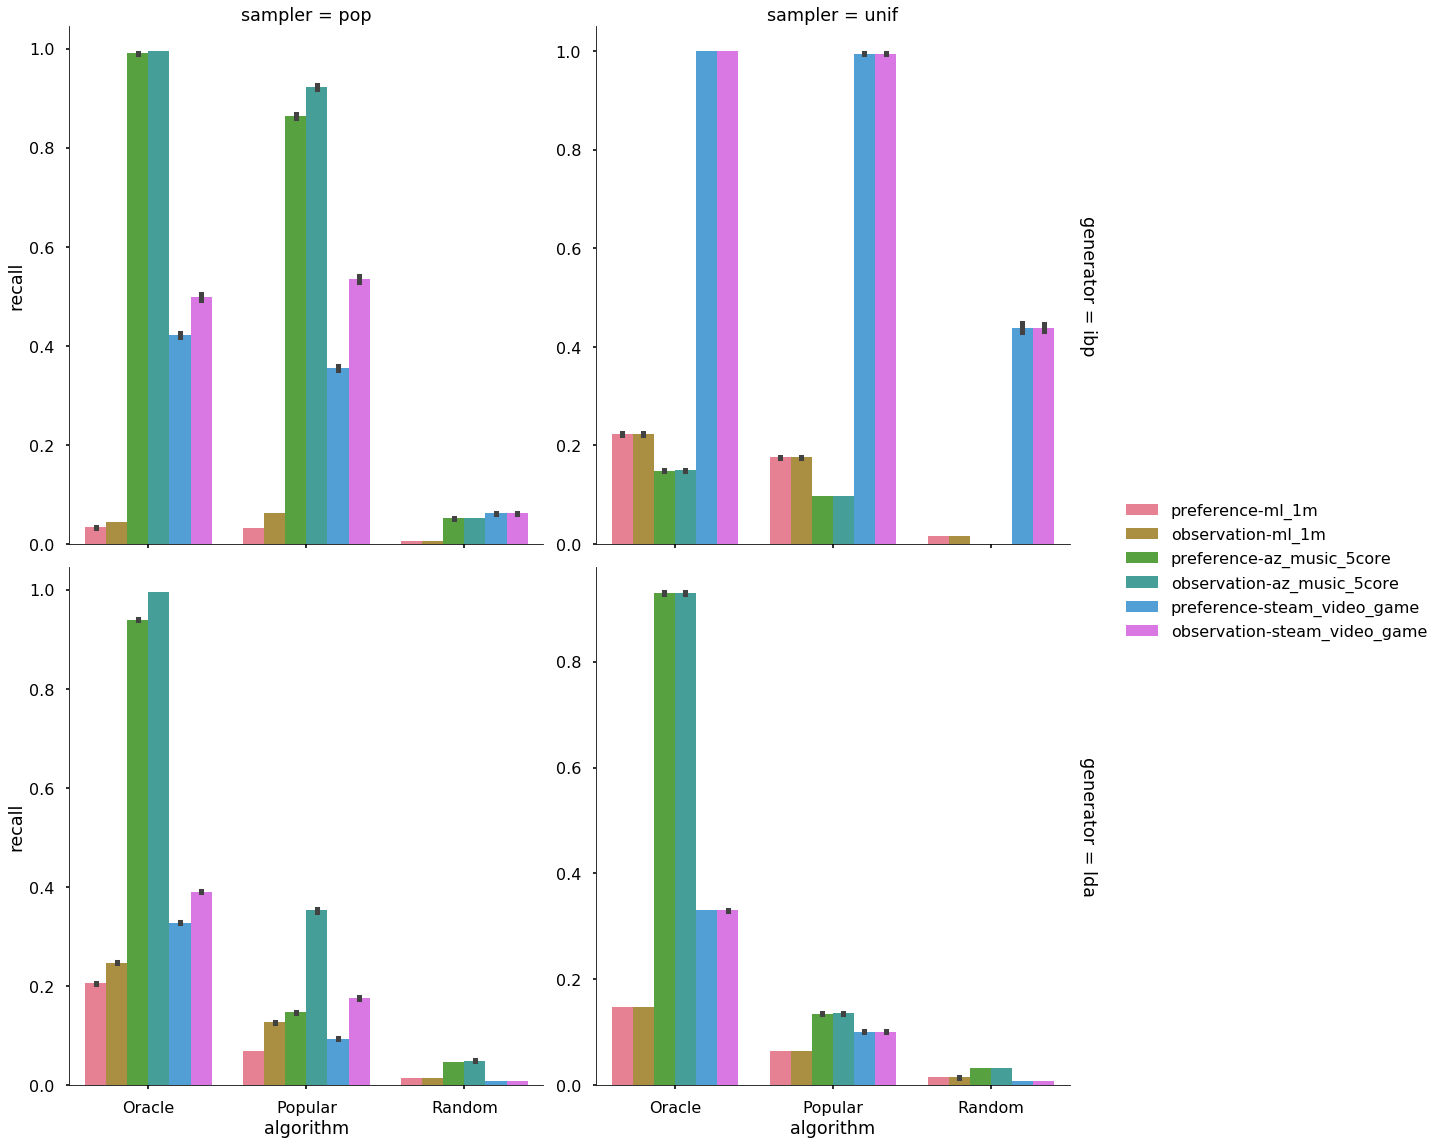

In [28]:
plot_metric_stats_dtype(data2plot, 'recall', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

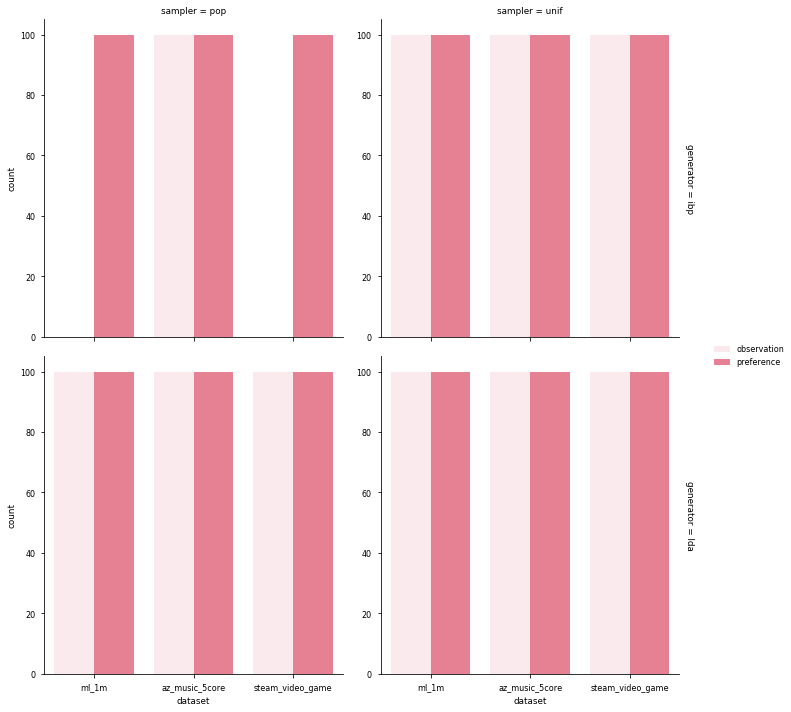

In [29]:
plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

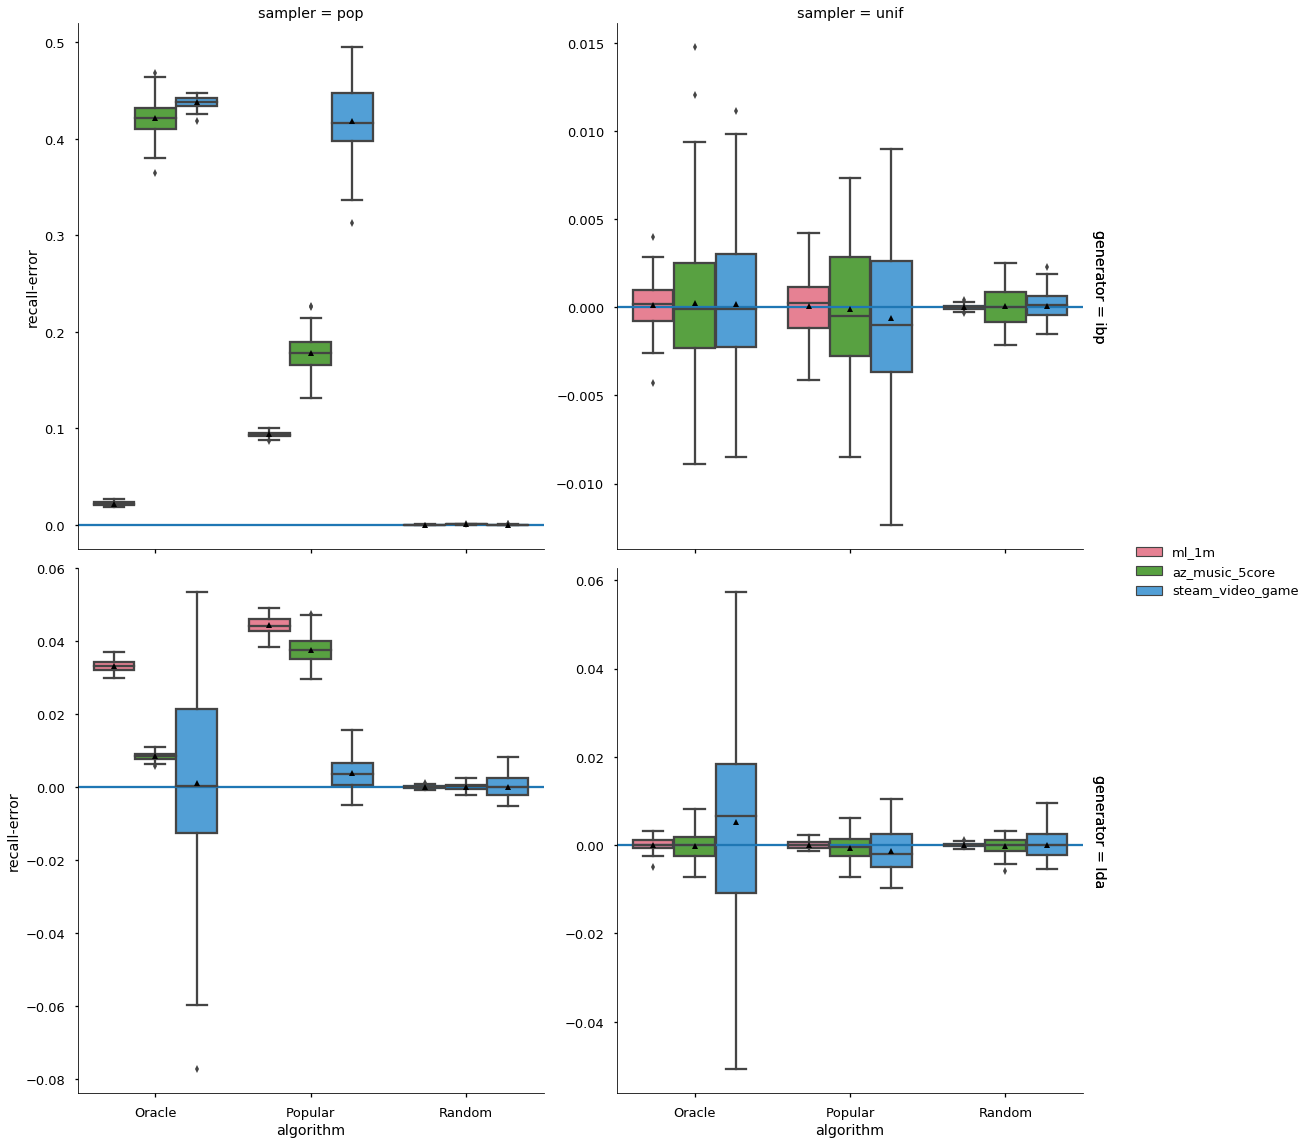

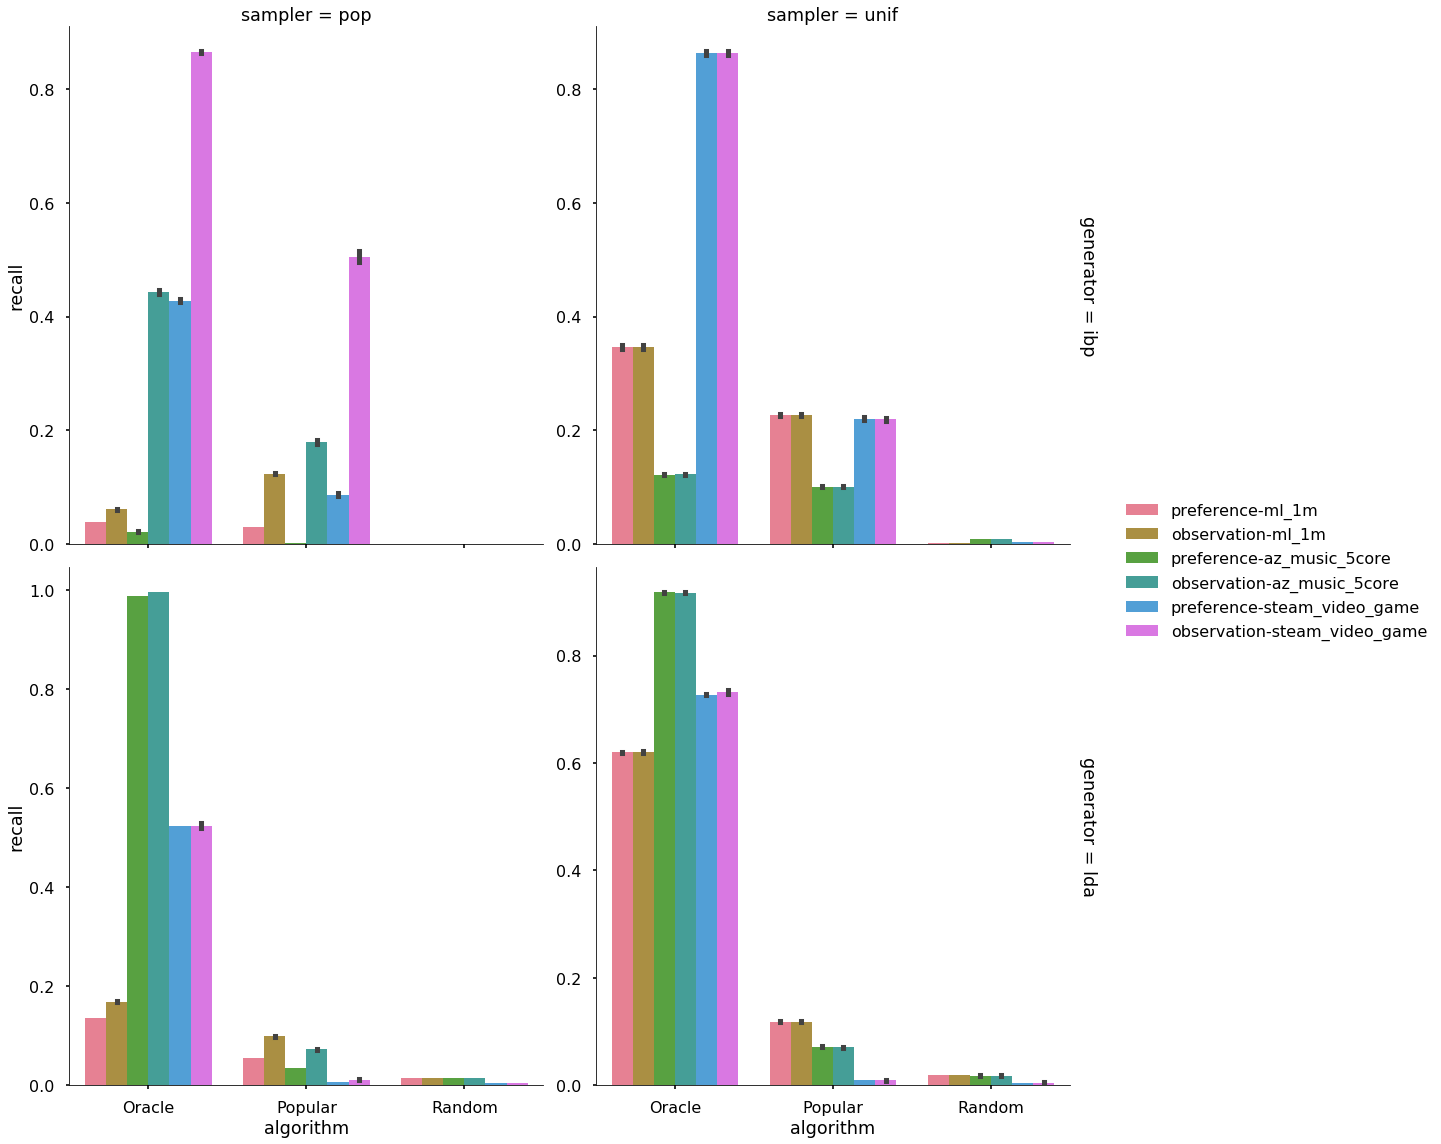

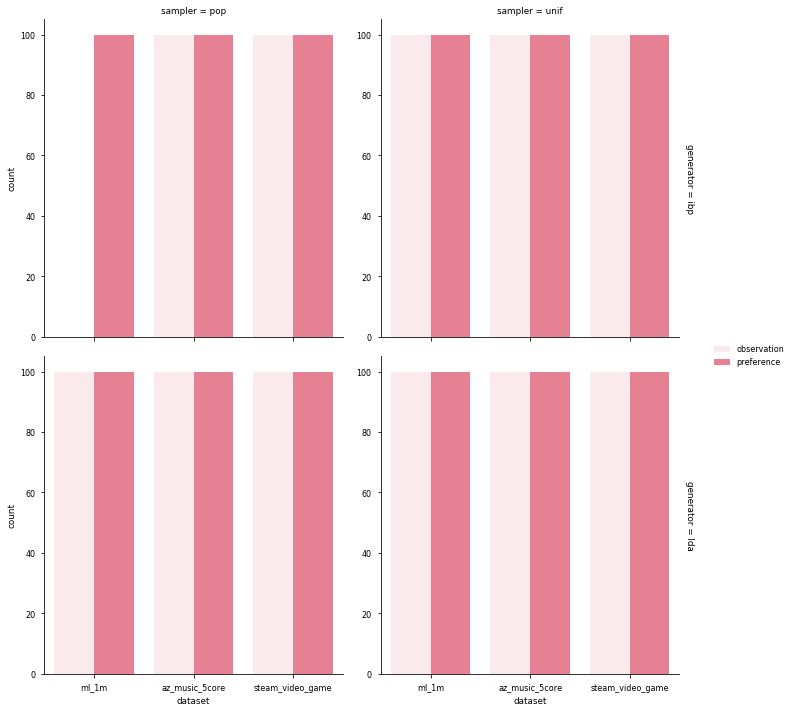

In [30]:
data2plot = extract_result(results, metric='recall', stats_to_tune='ucorr')

plot_metric_stats(data2plot, 'recall', 'error', sns.boxplot, **boxplot_kwargs)

plot_metric_stats_dtype(data2plot, 'recall', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

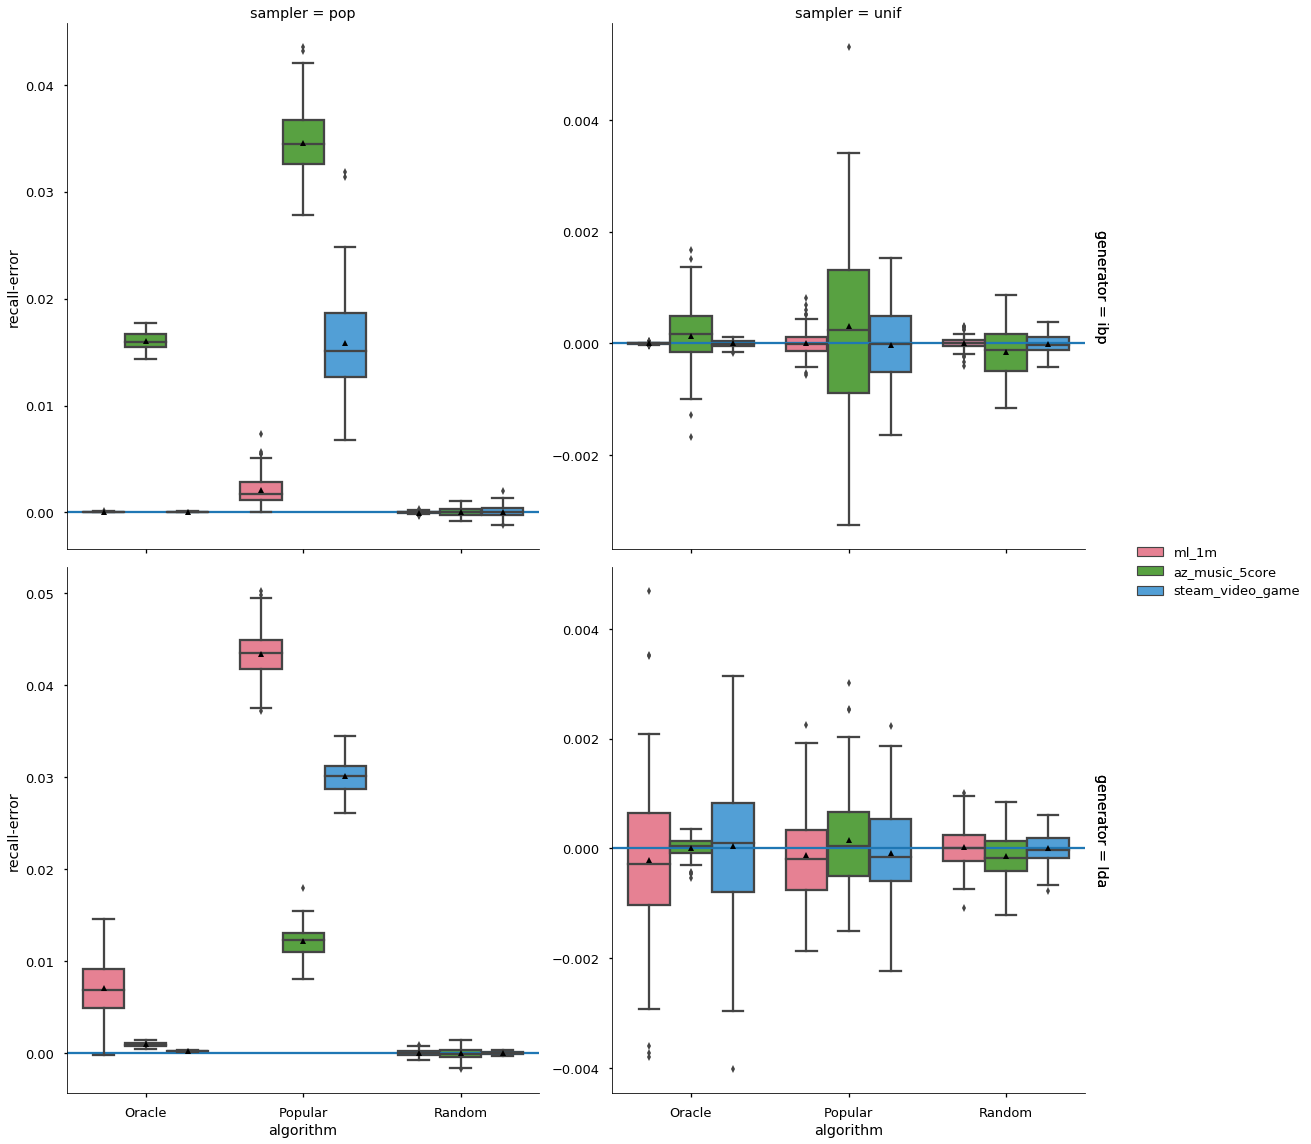

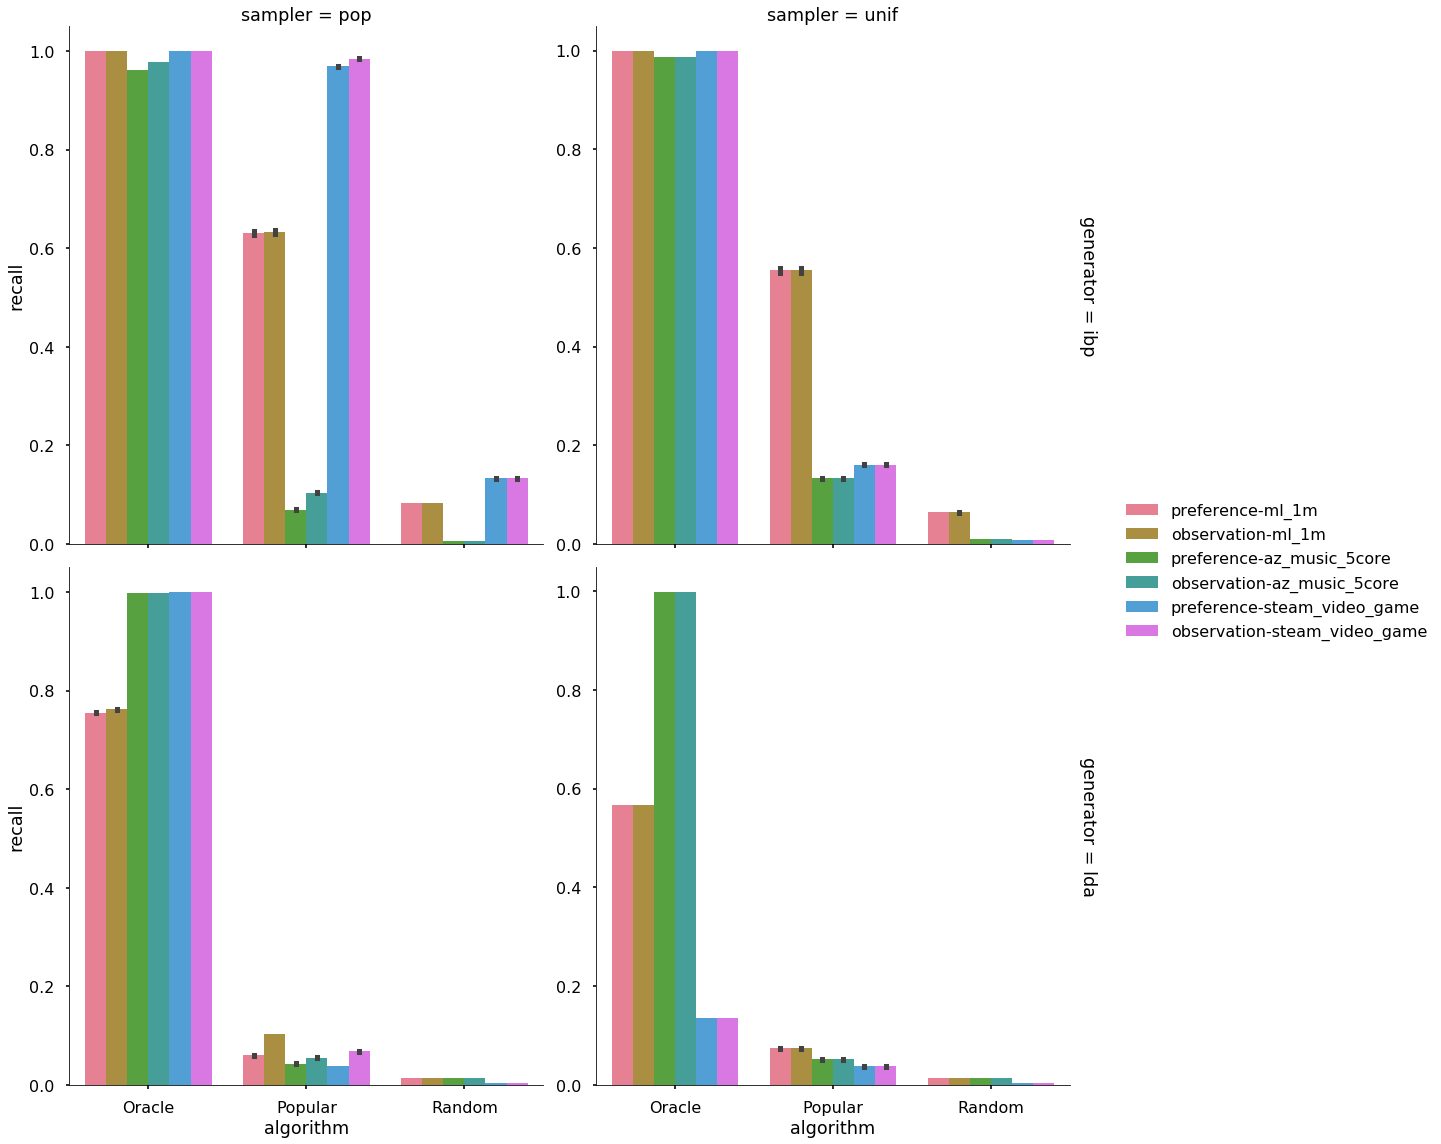

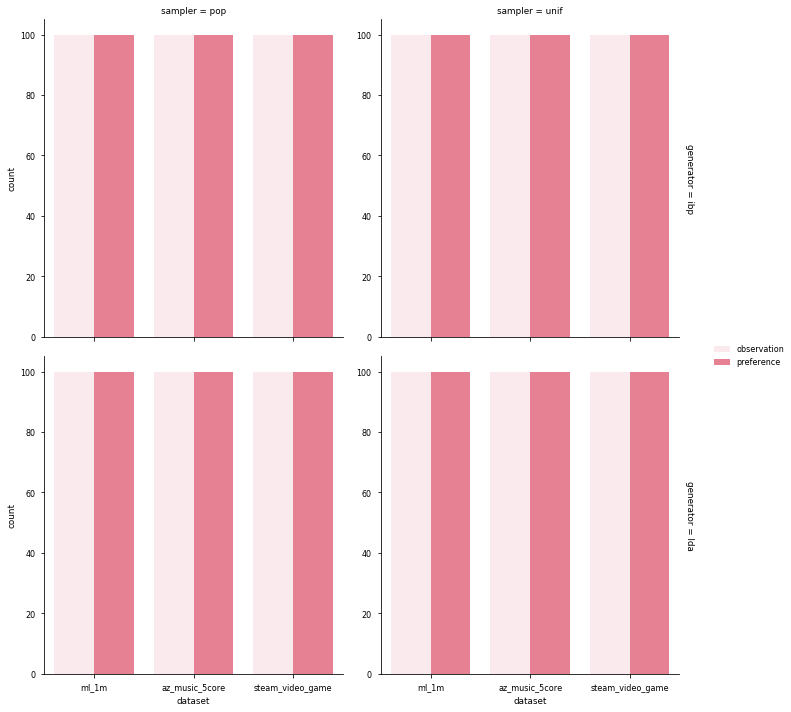

In [31]:
data2plot = extract_result(results, metric='recall', stats_to_tune='item-pop')

plot_metric_stats(data2plot, 'recall', 'error', sns.boxplot, **boxplot_kwargs)

plot_metric_stats_dtype(data2plot, 'recall', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

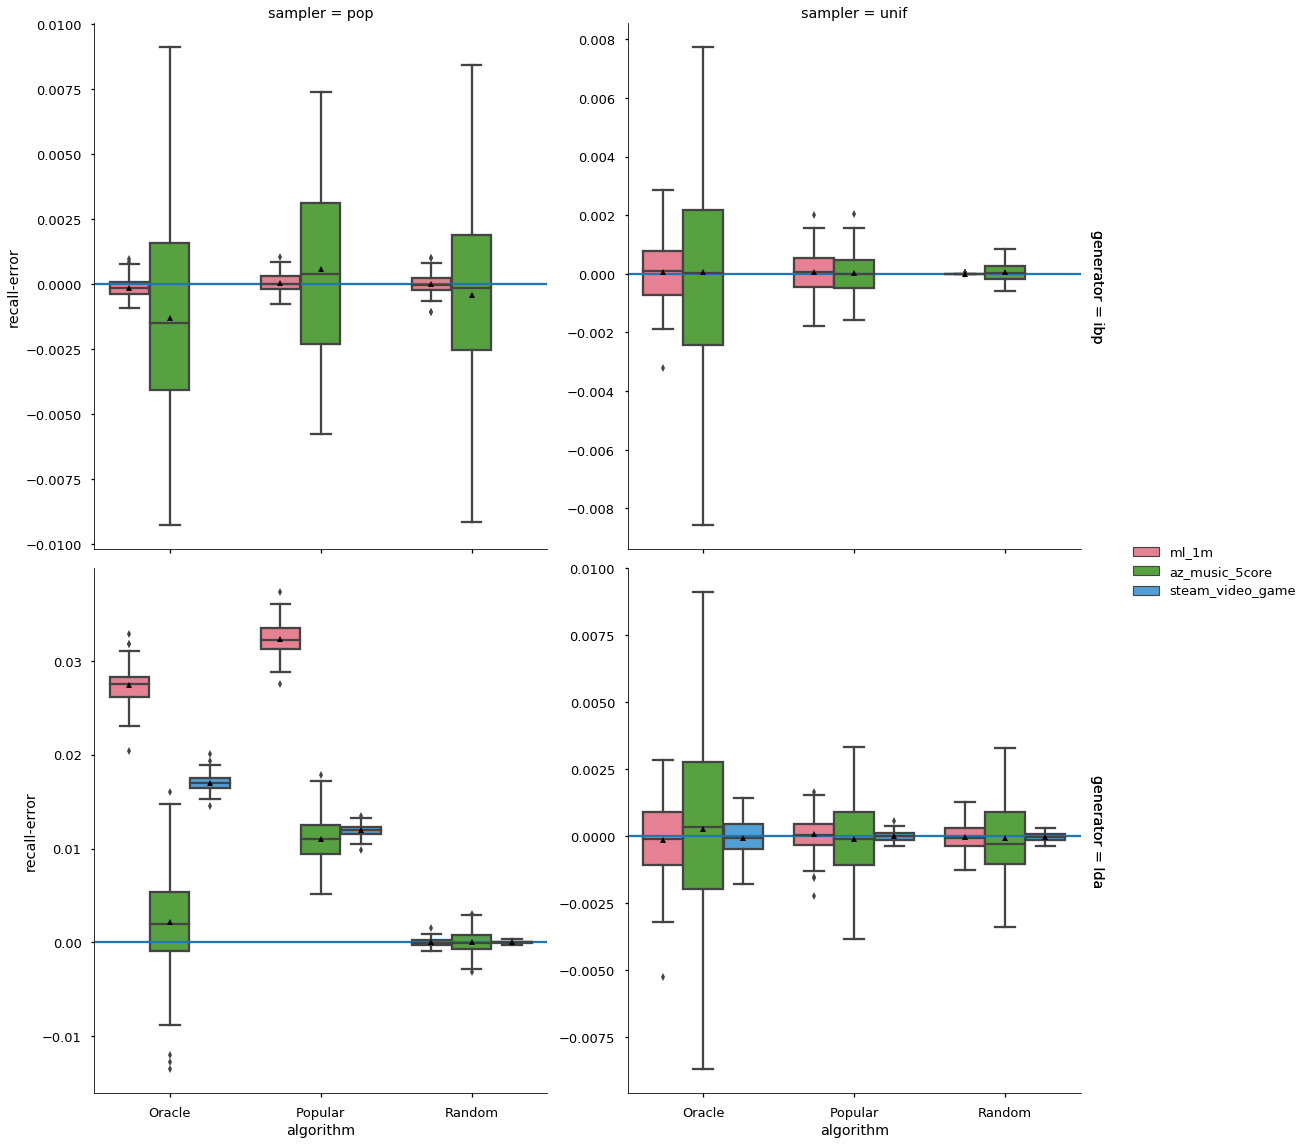

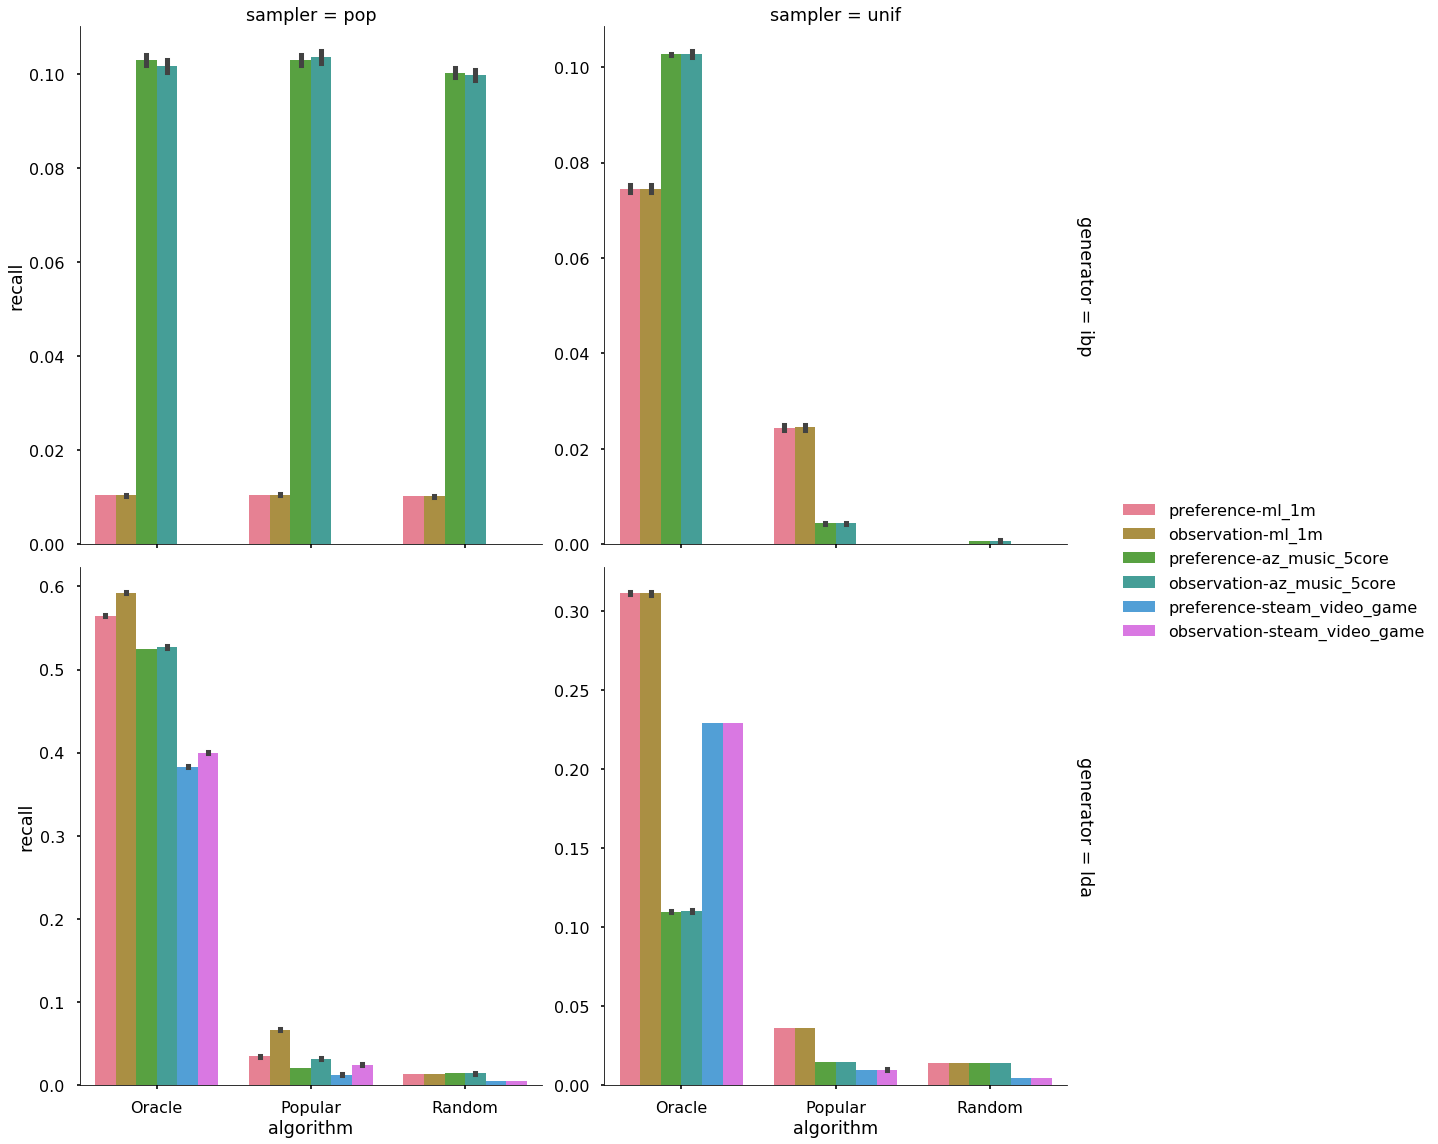

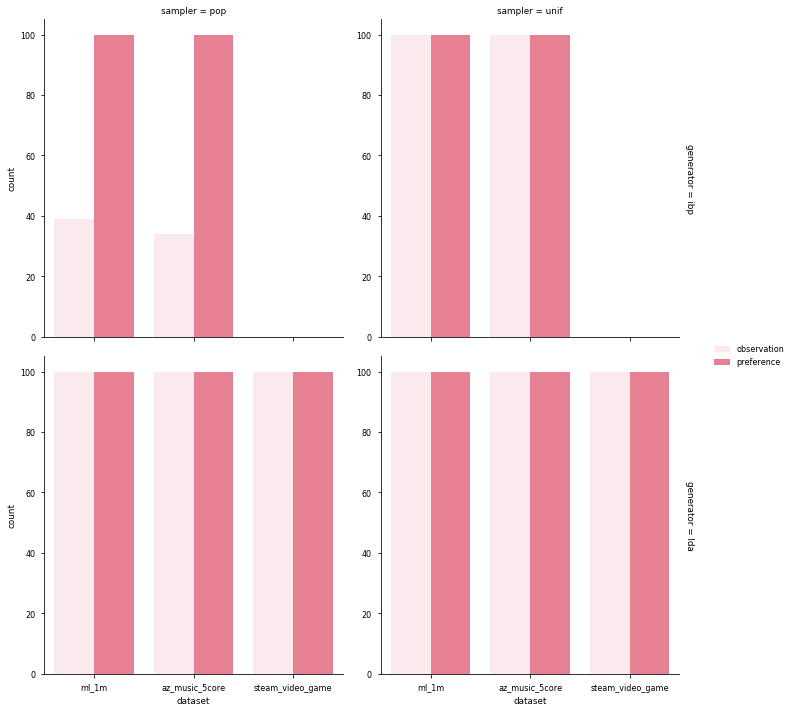

In [32]:
data2plot = extract_result(results, metric='recall', stats_to_tune='user-act')

plot_metric_stats(data2plot, 'recall', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'recall', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

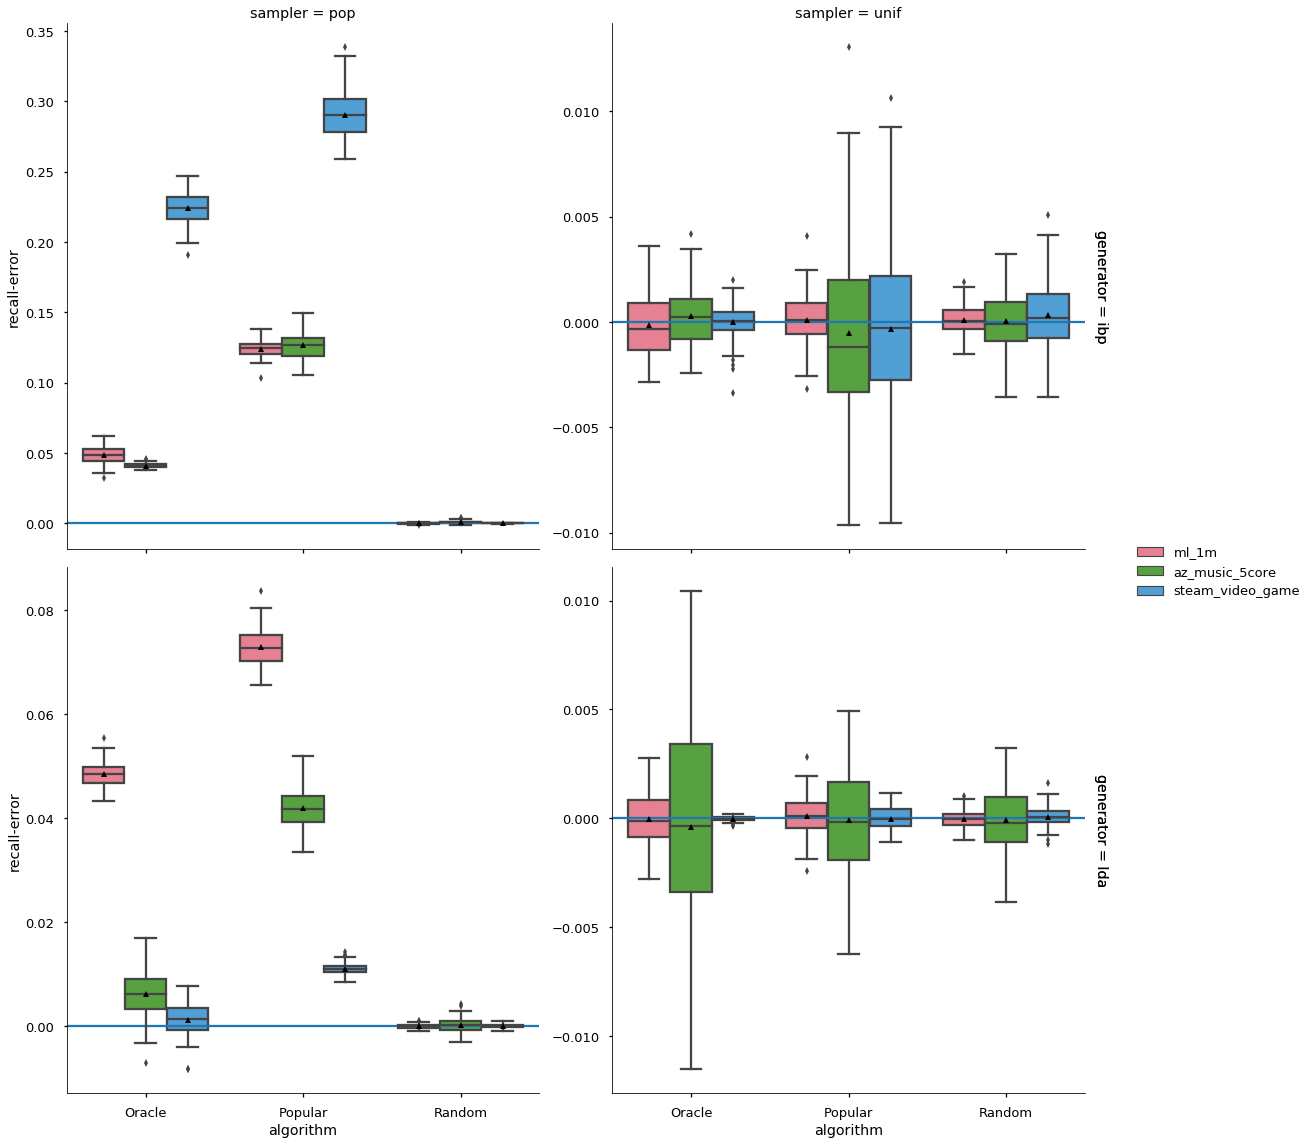

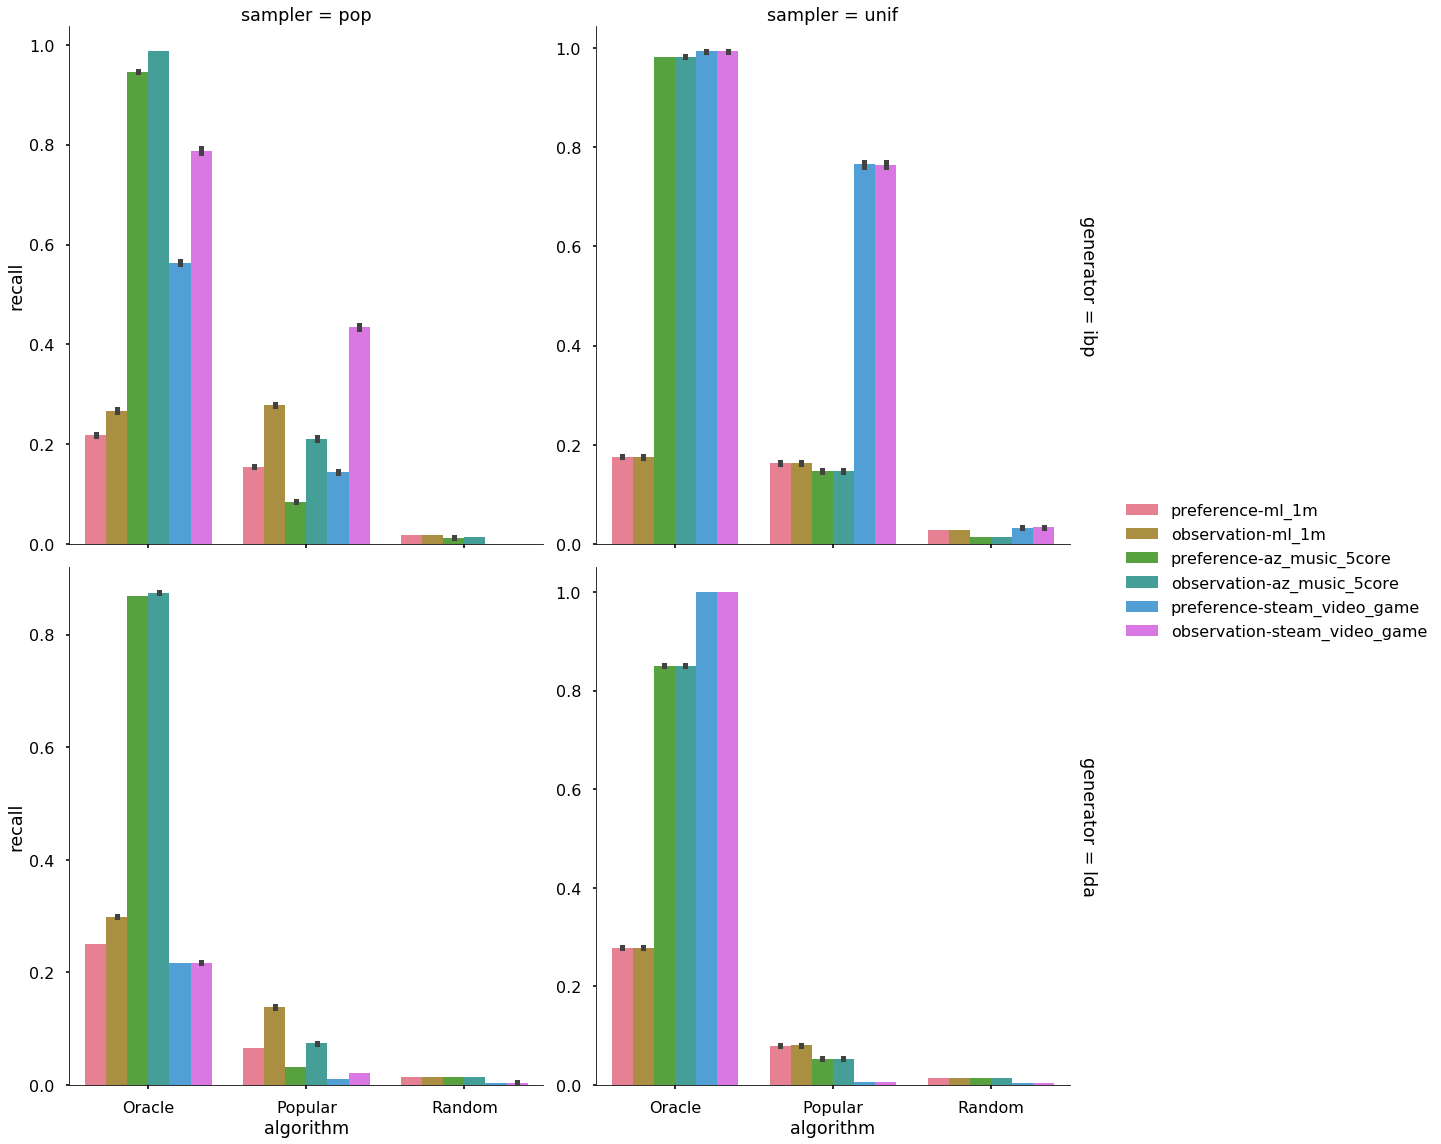

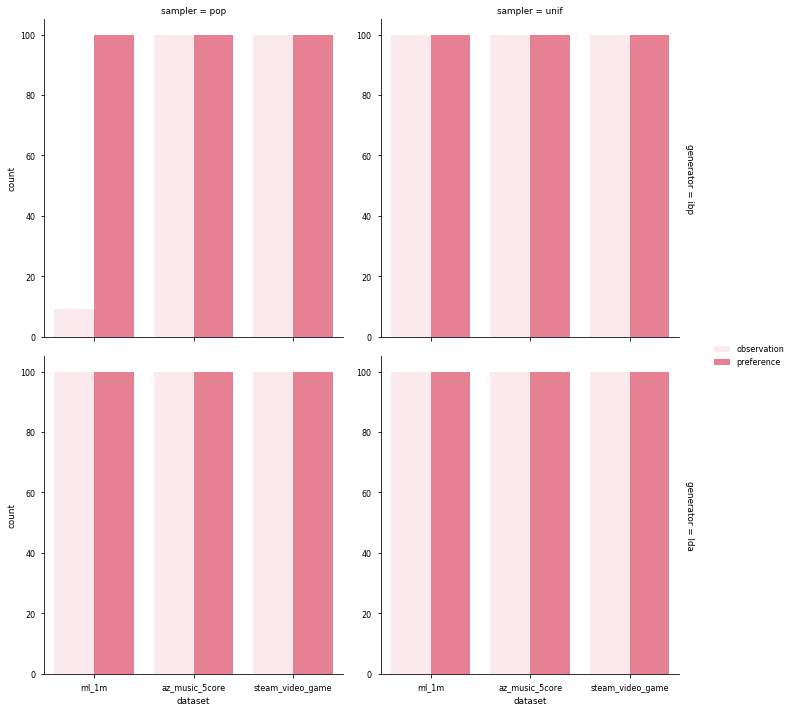

In [33]:
data2plot = extract_result(results, metric='recall', stats_to_tune='all')

plot_metric_stats(data2plot, 'recall', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'recall', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

**MRR**

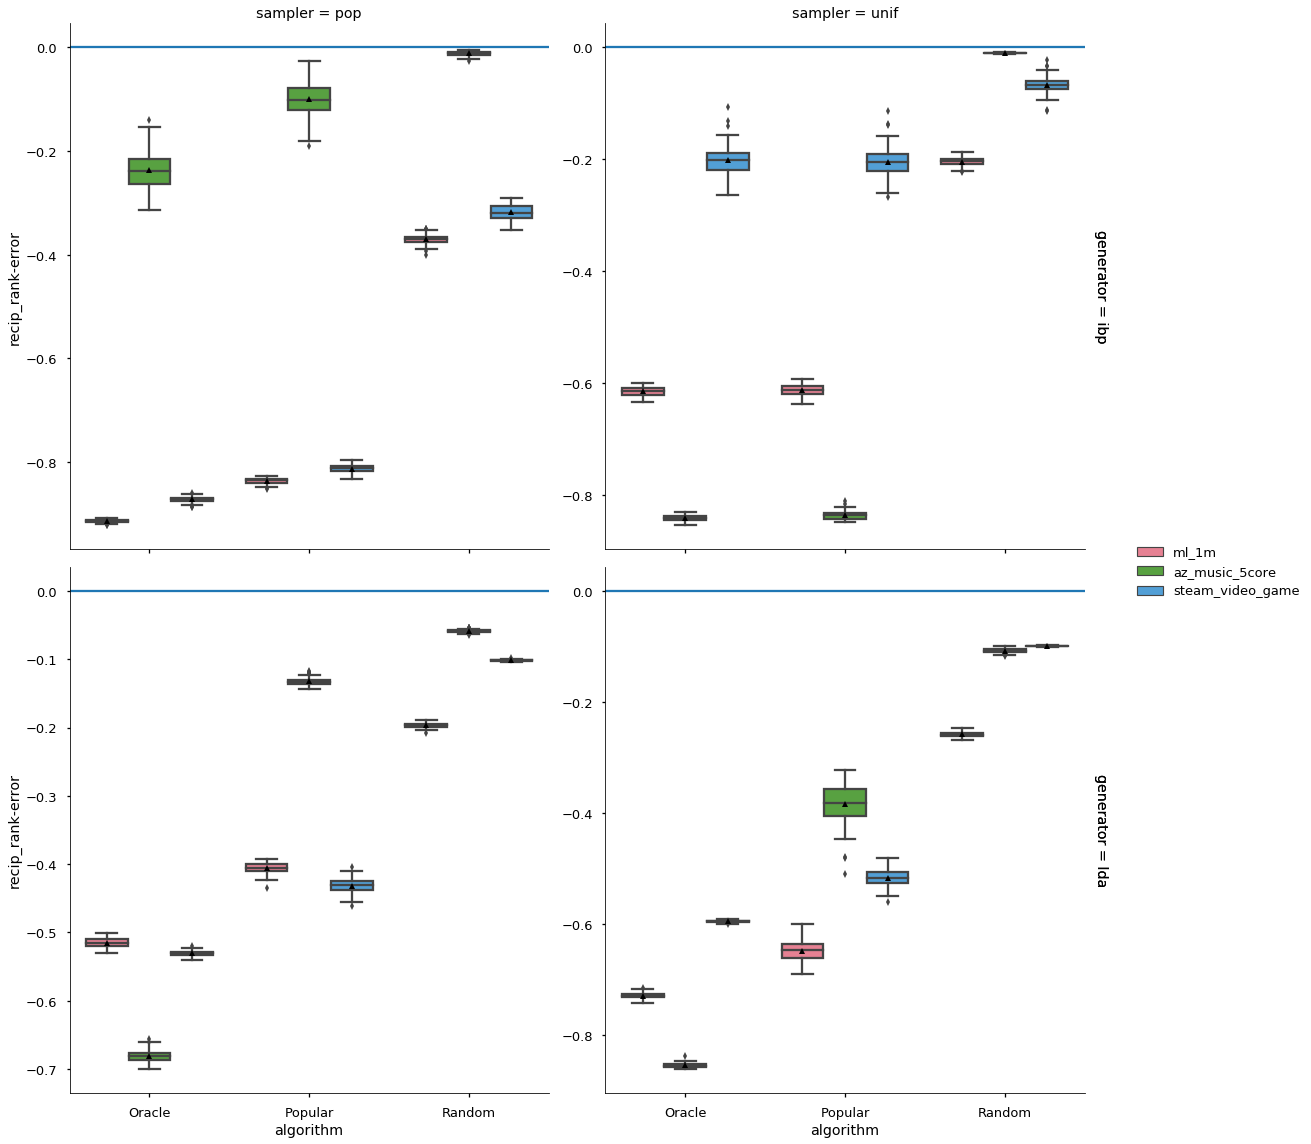

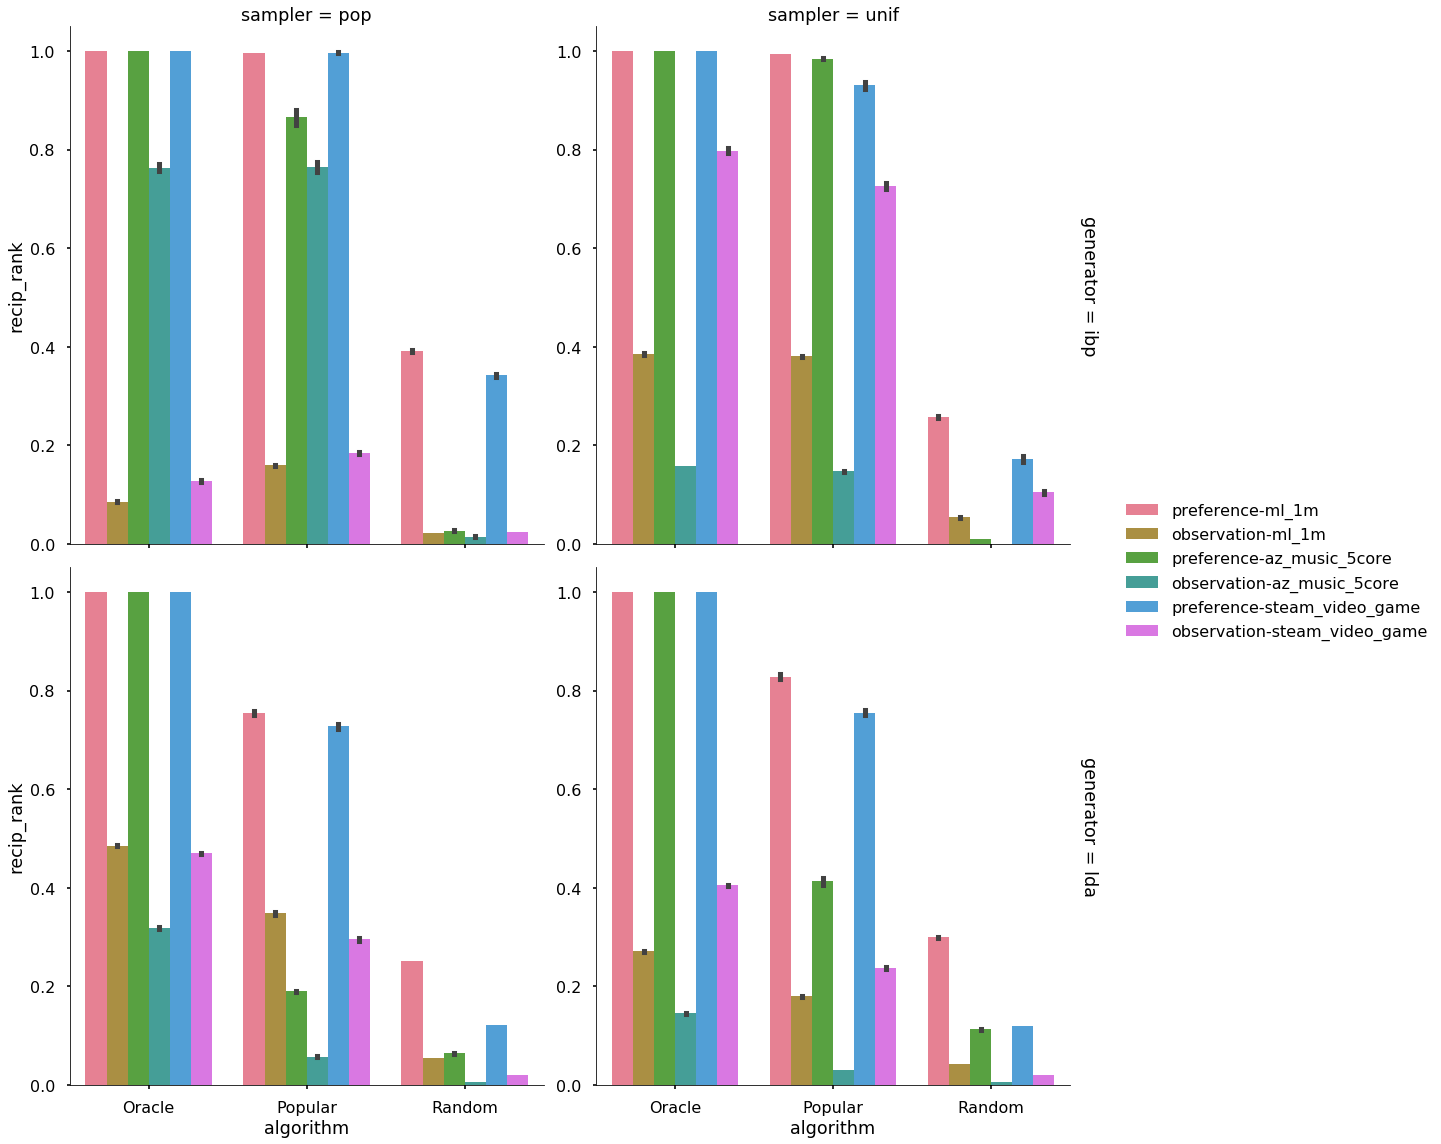

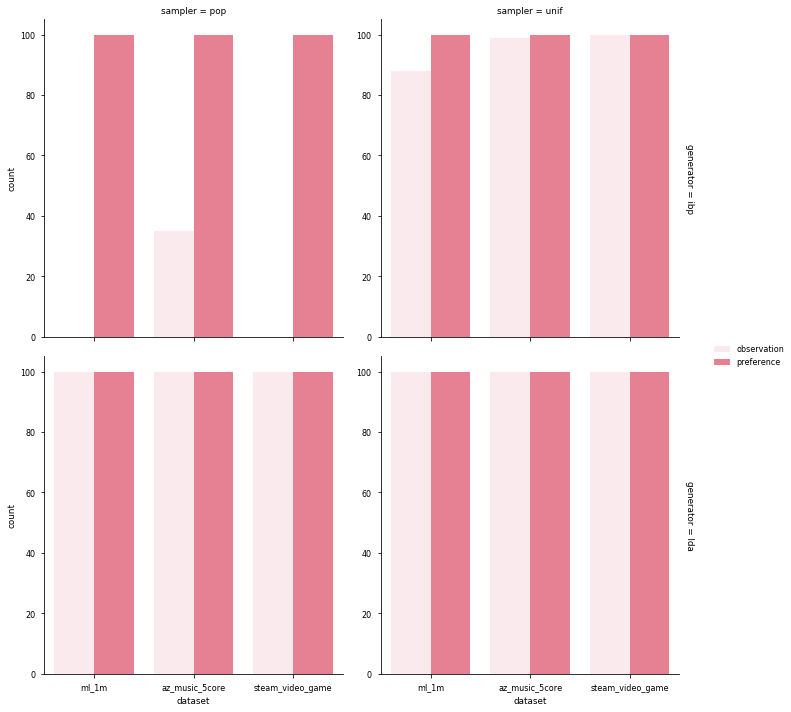

In [34]:
data2plot = extract_result(results, metric='recip_rank', stats_to_tune='icorr')

plot_metric_stats(data2plot, 'recip_rank', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'recip_rank', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

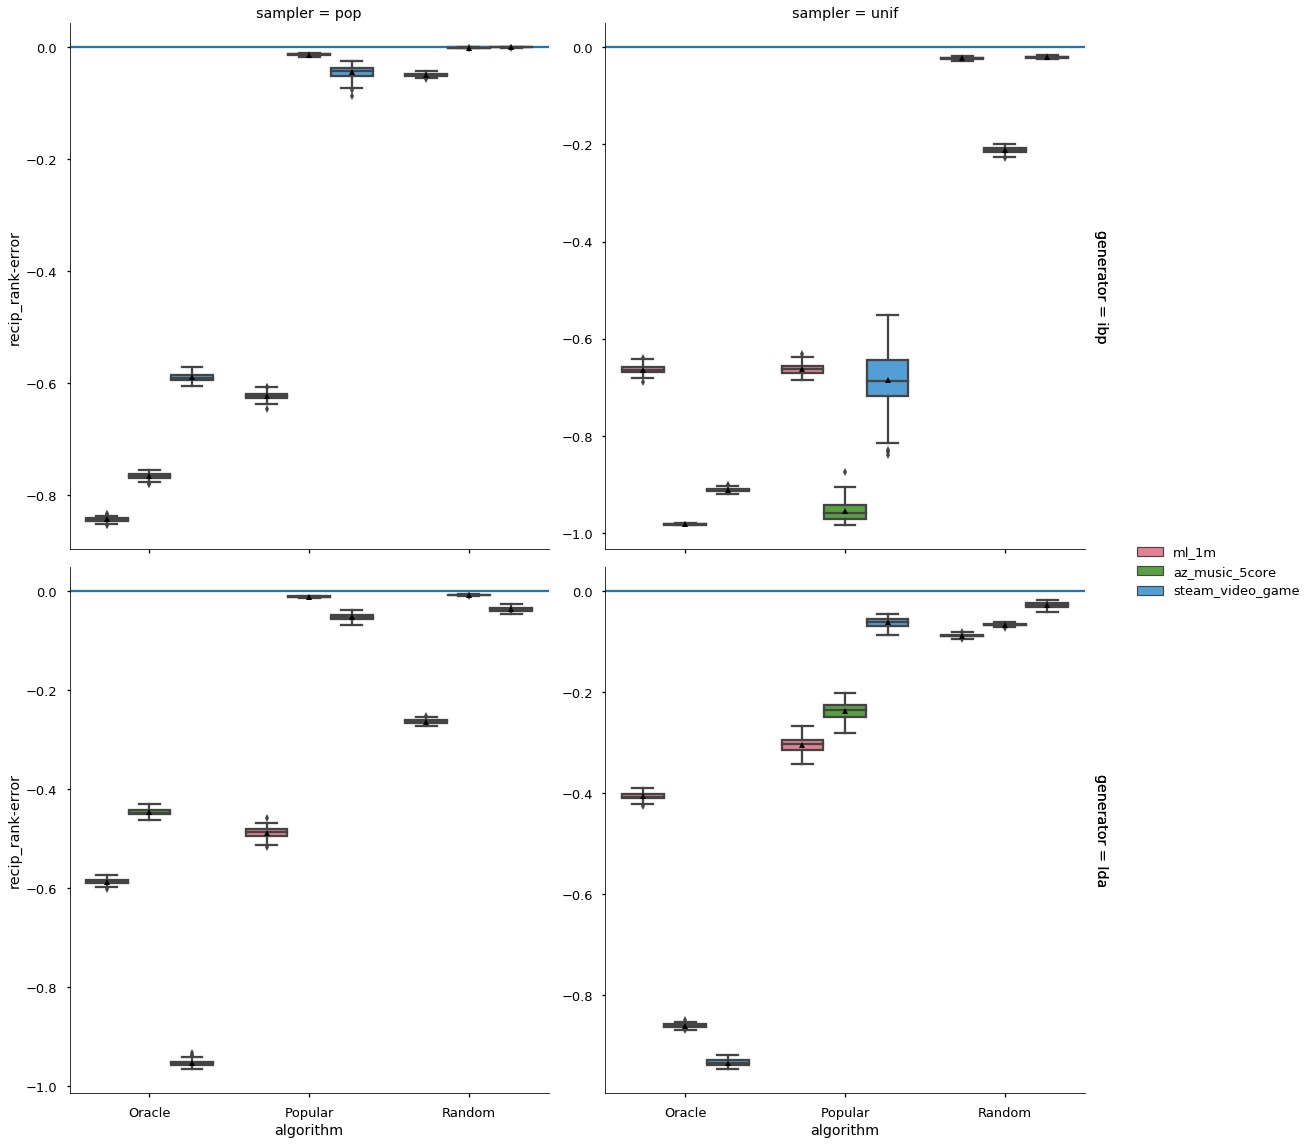

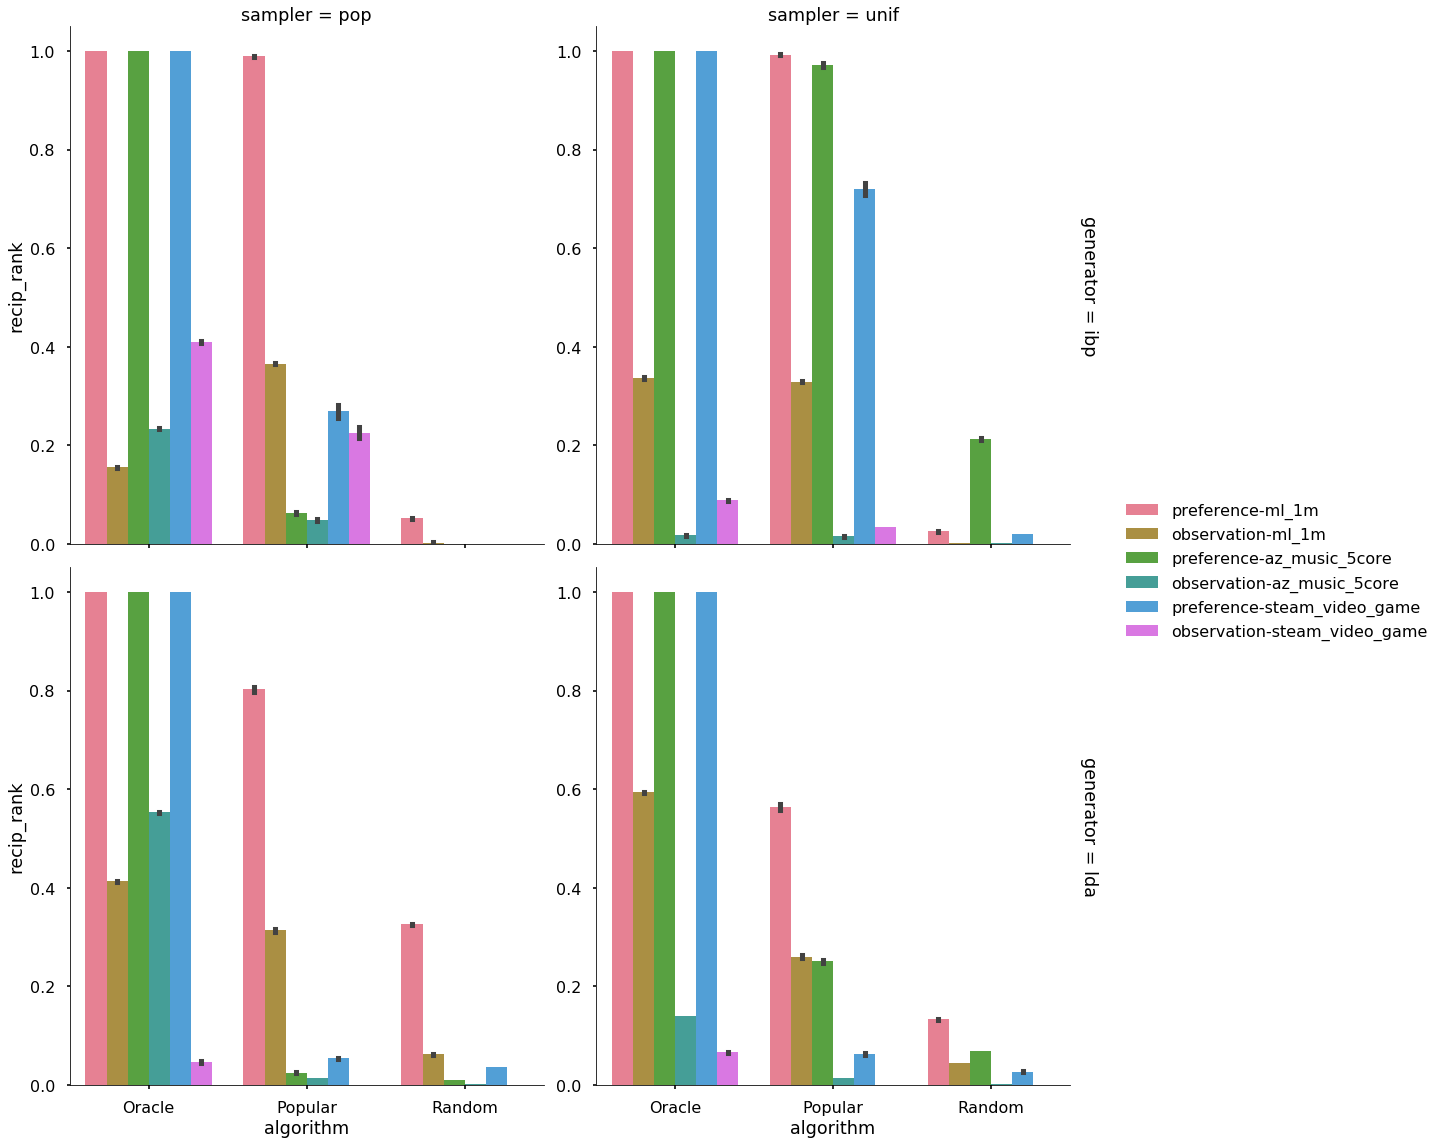

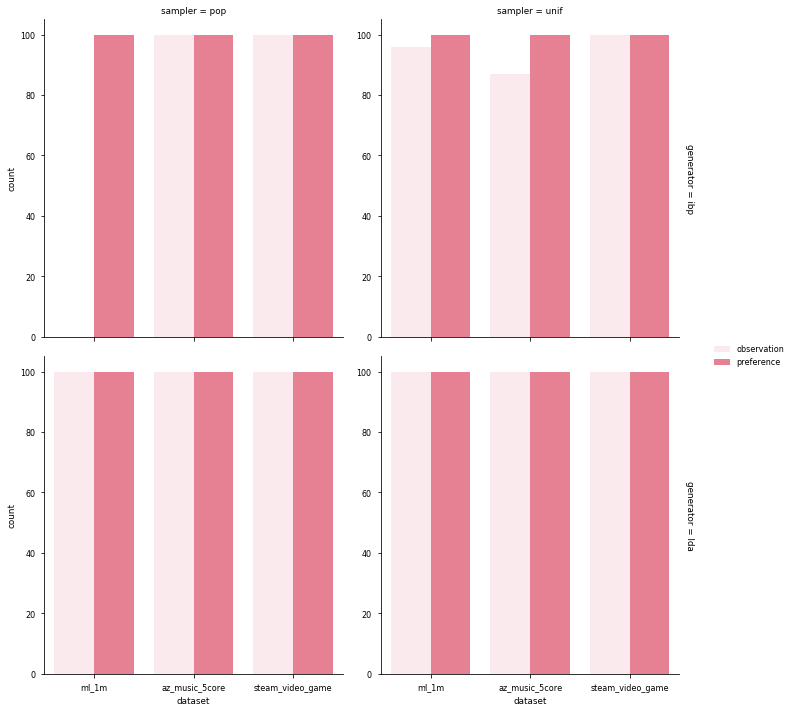

In [35]:
data2plot = extract_result(results, metric='recip_rank', stats_to_tune='ucorr')

plot_metric_stats(data2plot, 'recip_rank', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'recip_rank', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

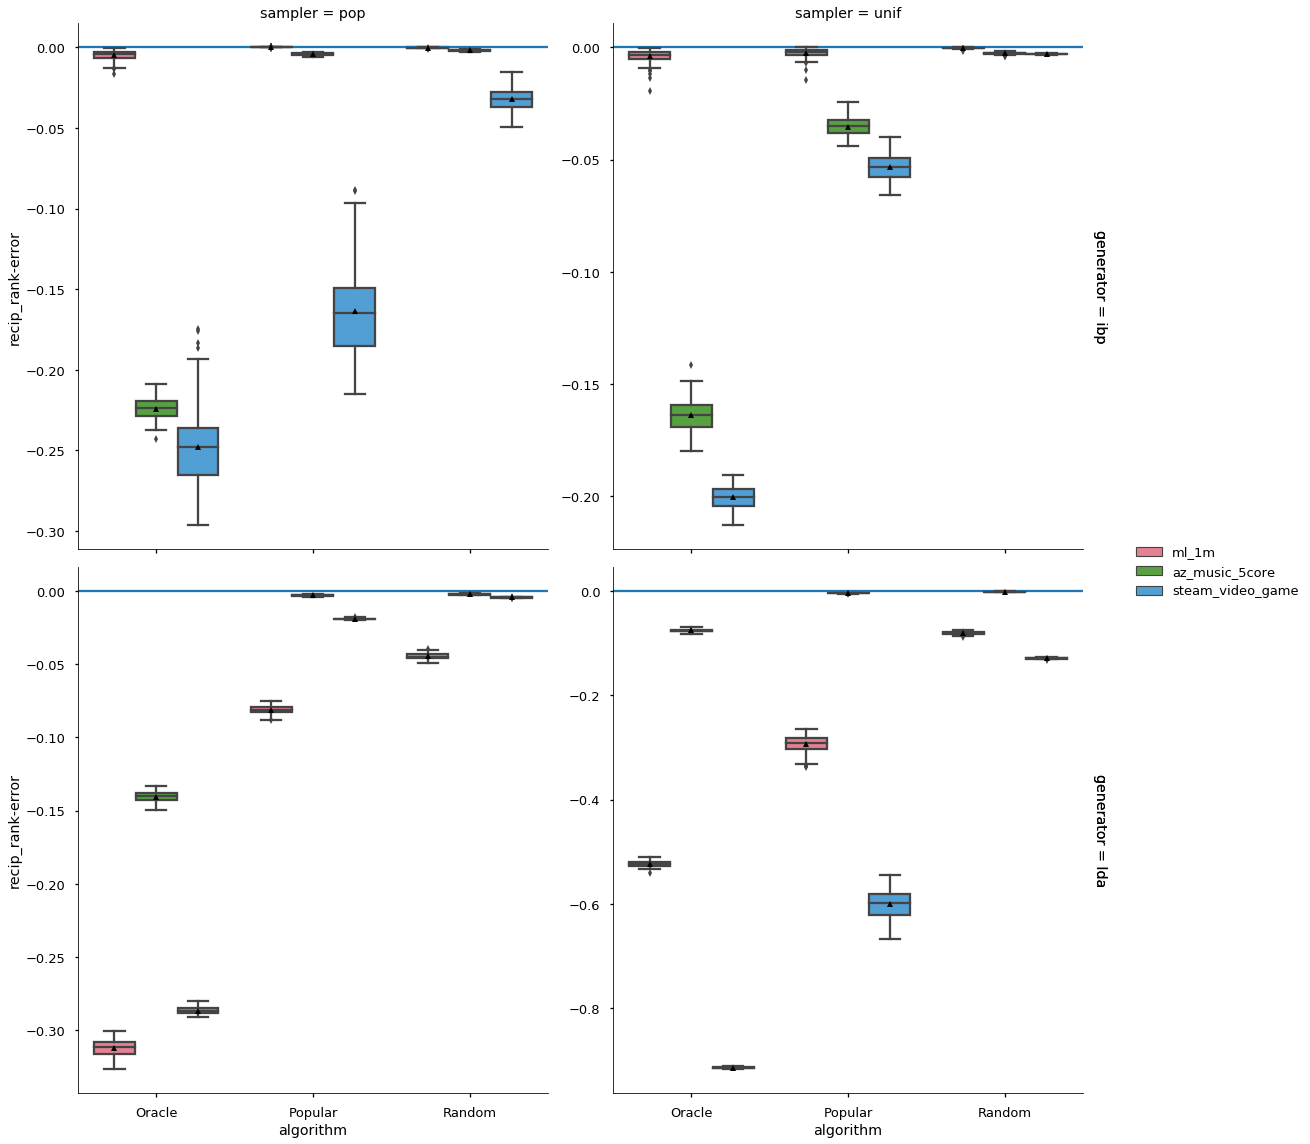

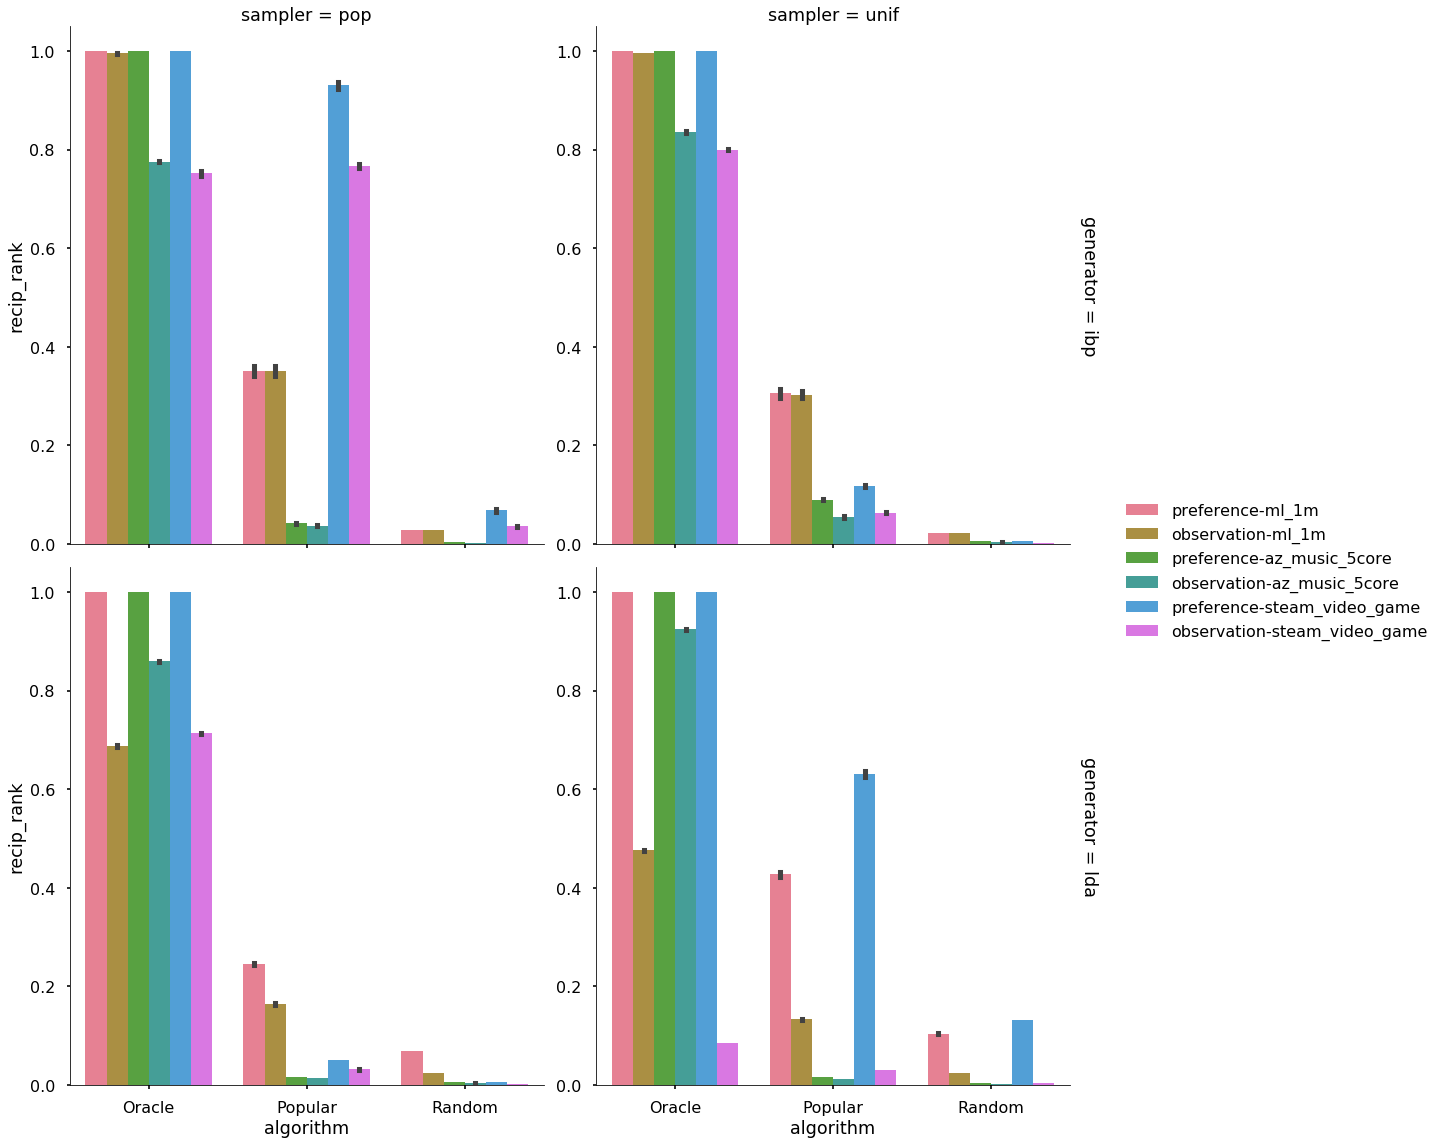

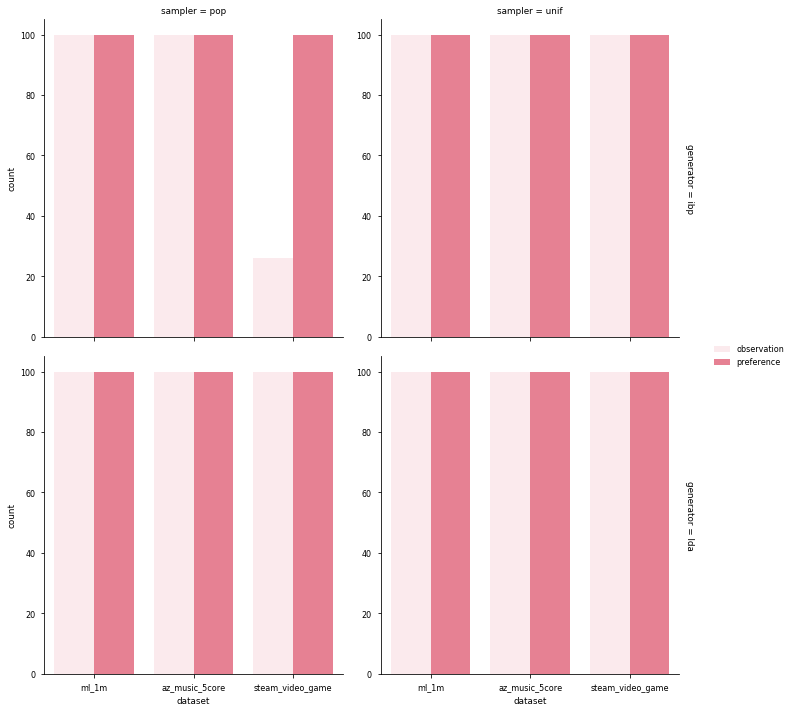

In [36]:
data2plot = extract_result(results, metric='recip_rank', stats_to_tune='item-pop')

plot_metric_stats(data2plot, 'recip_rank', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'recip_rank', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

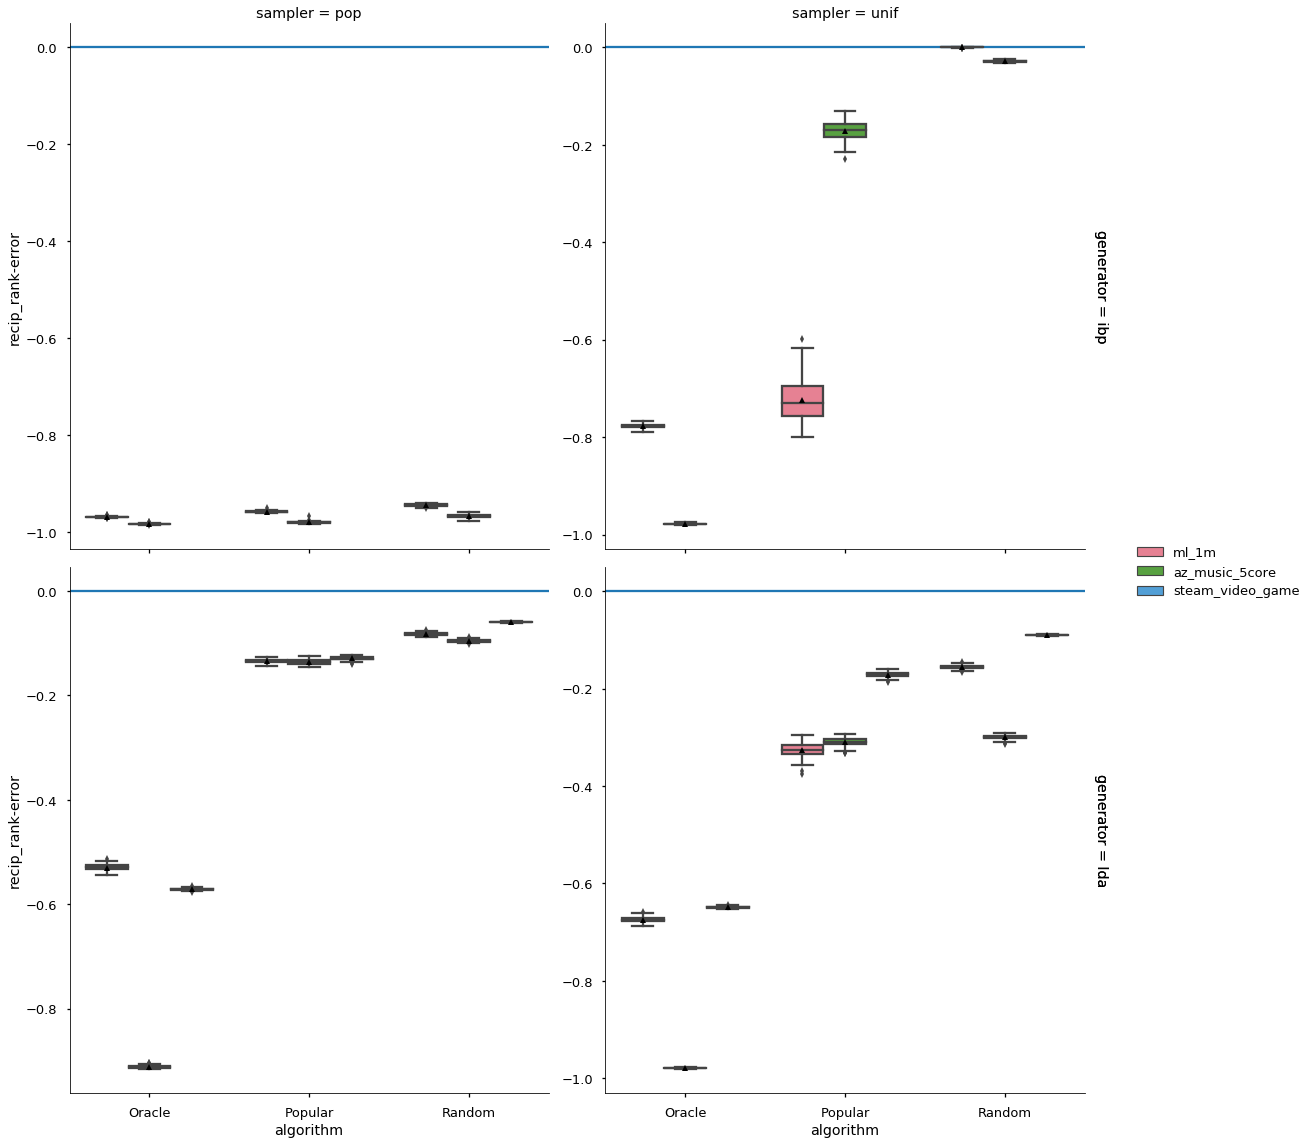

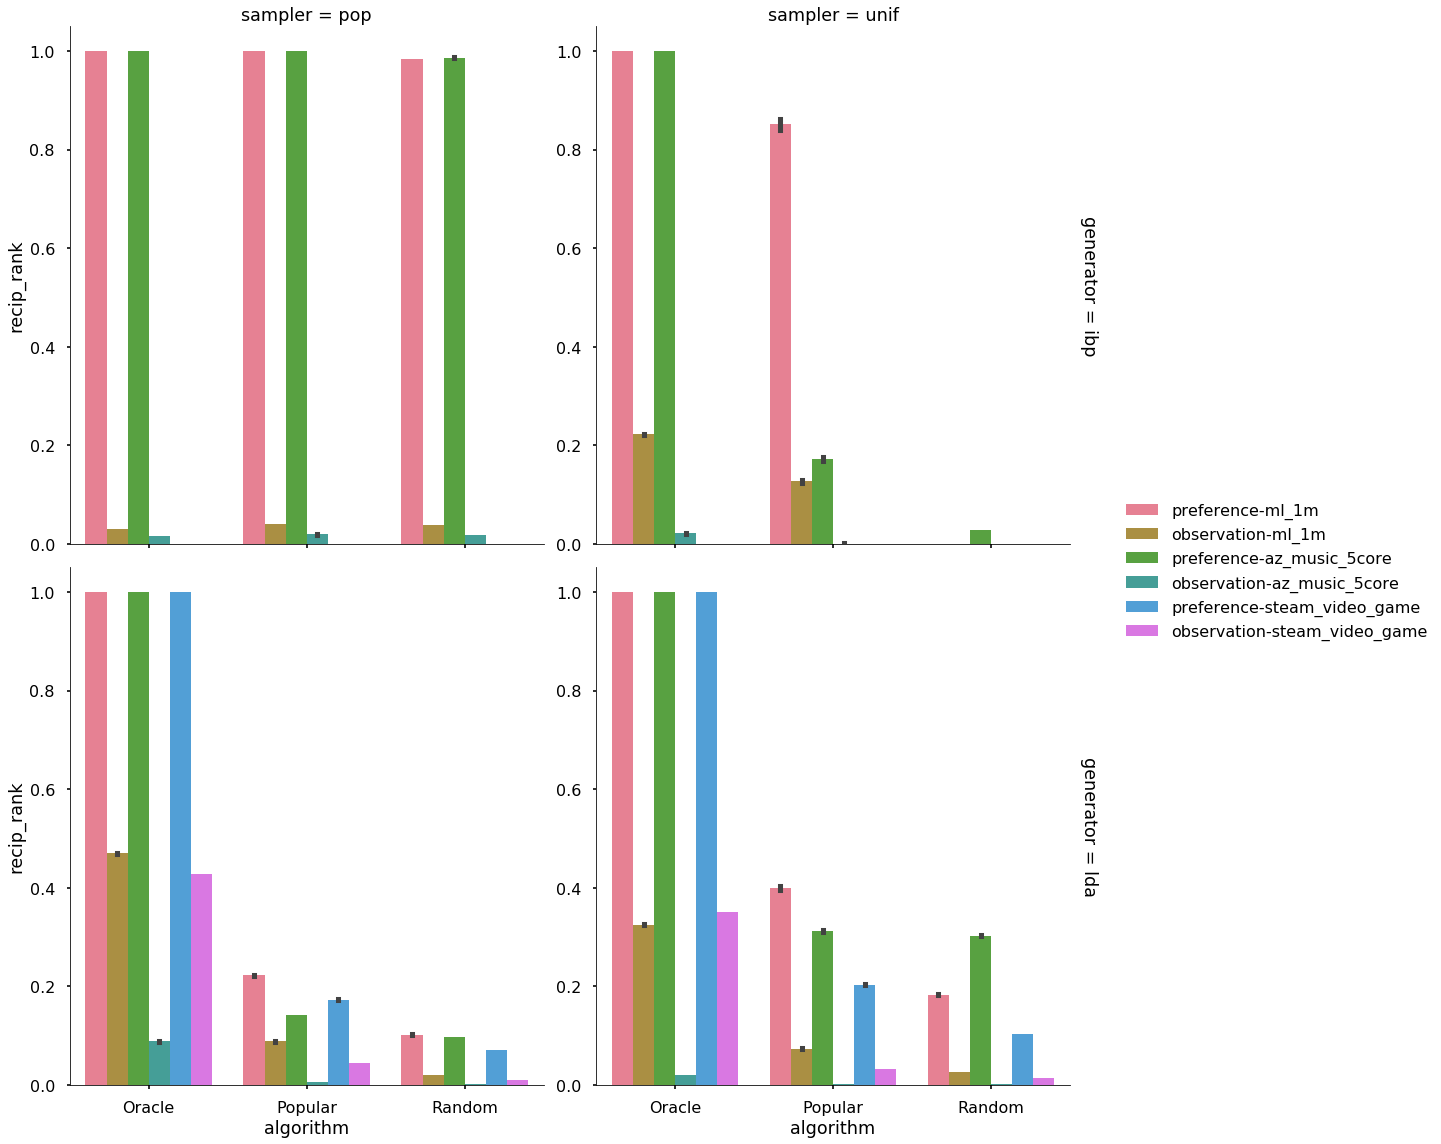

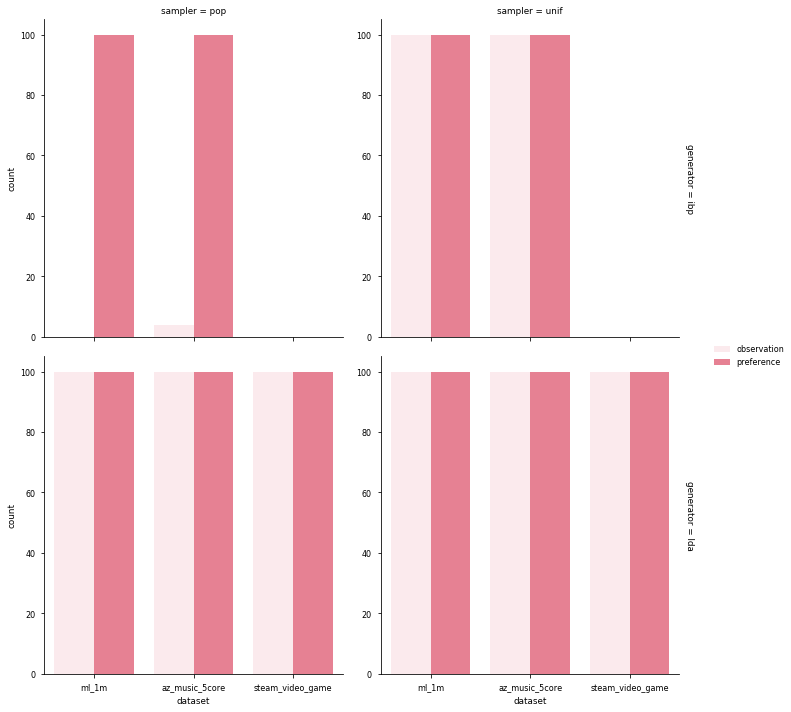

In [37]:
data2plot = extract_result(results, metric='recip_rank', stats_to_tune='user-act')

plot_metric_stats(data2plot, 'recip_rank', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'recip_rank', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

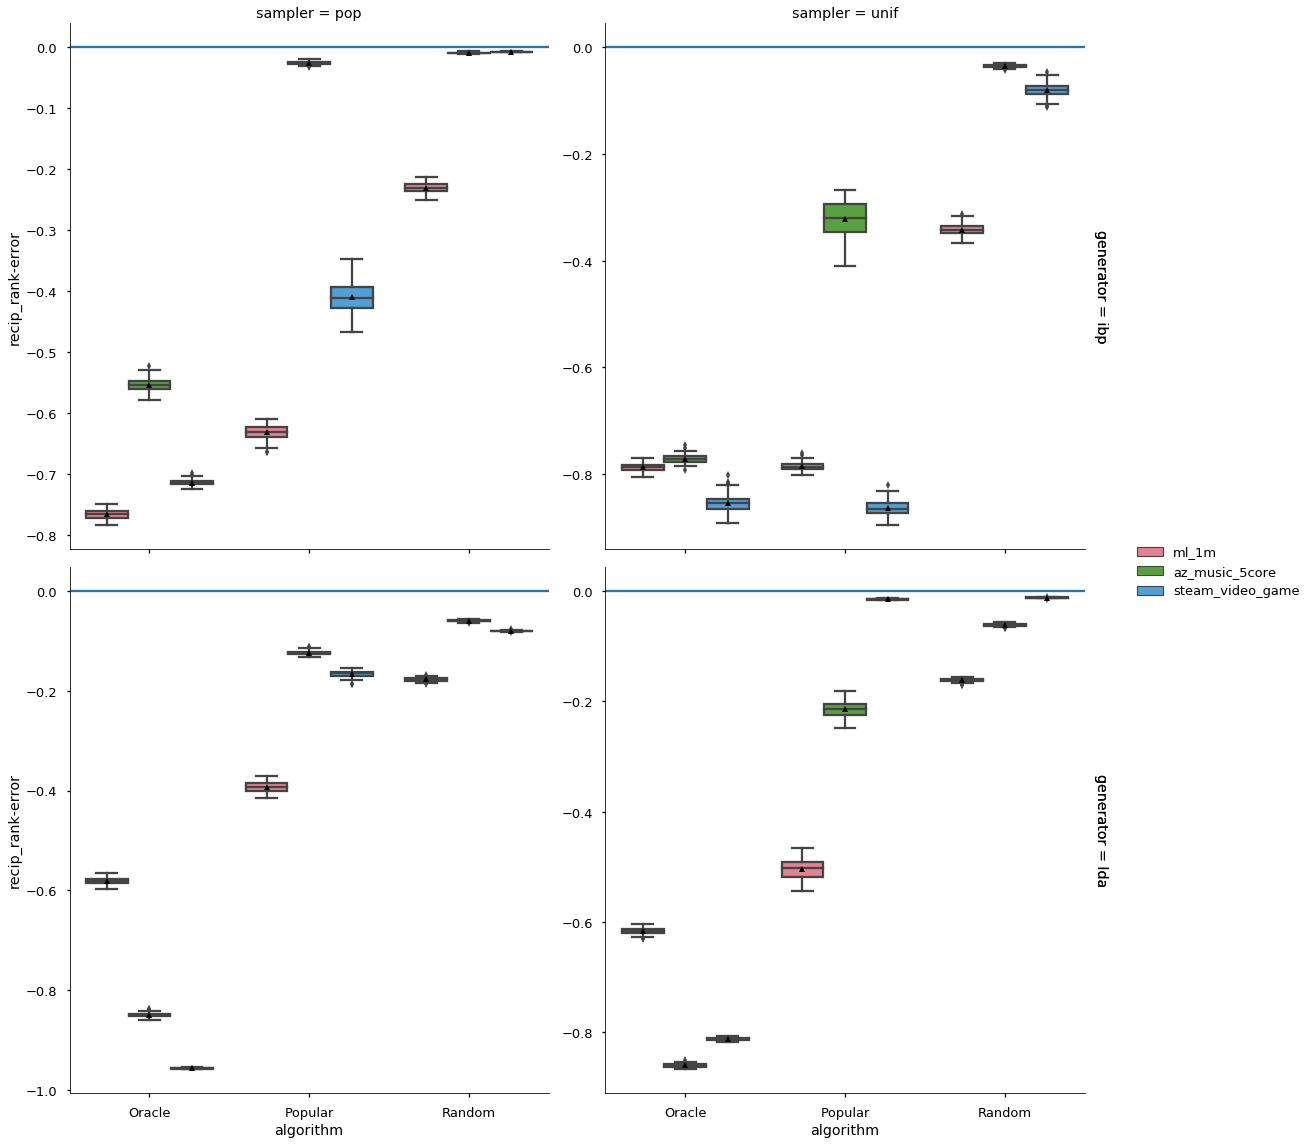

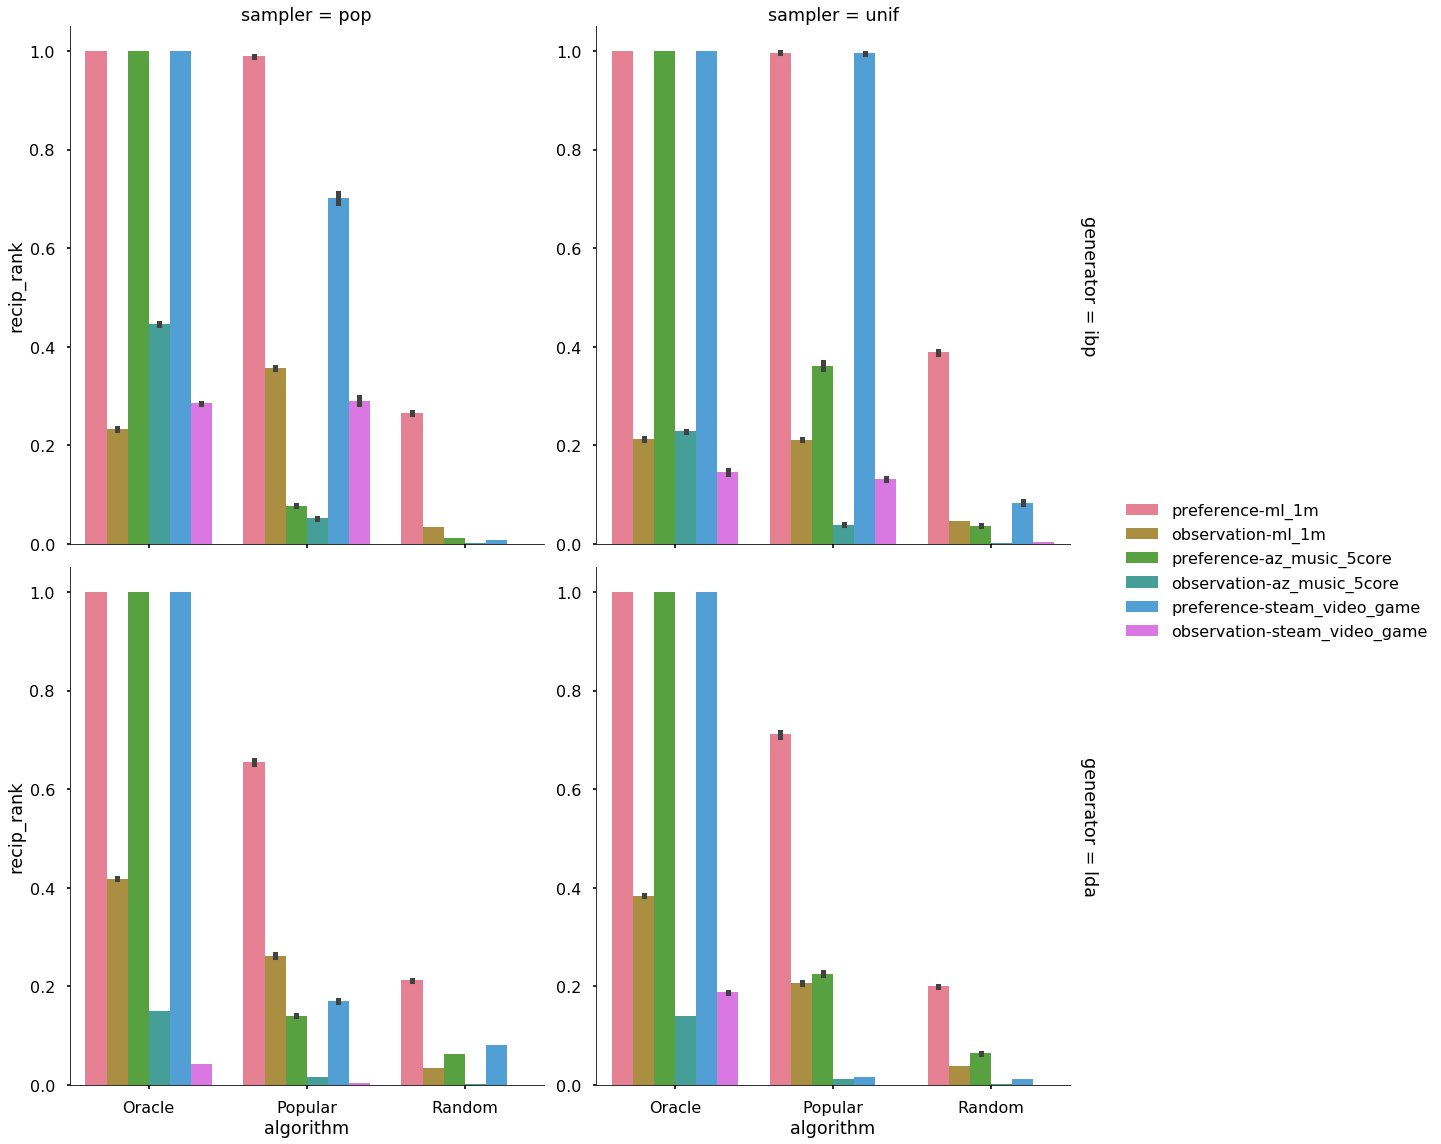

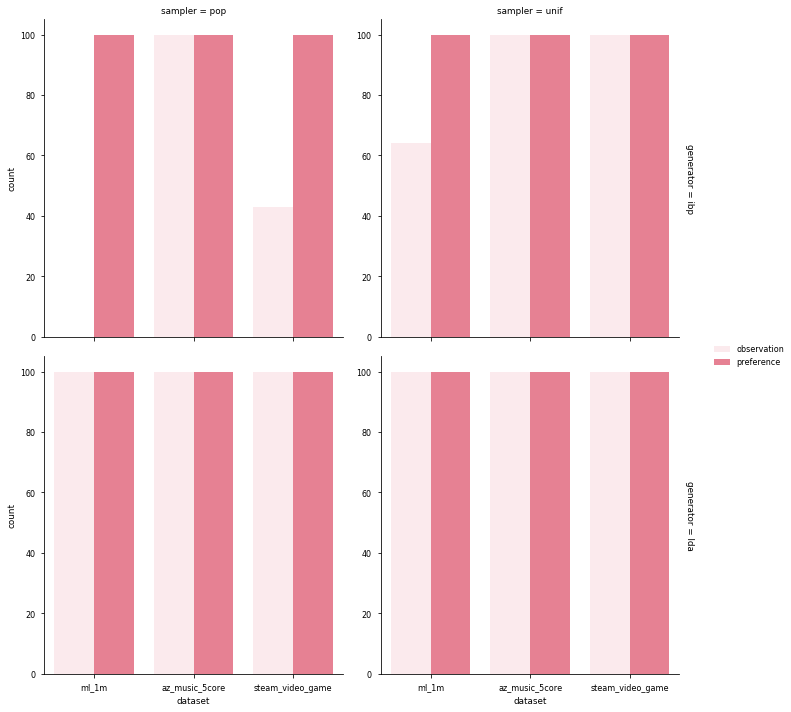

In [38]:
data2plot = extract_result(results, metric='recip_rank', stats_to_tune='all')

plot_metric_stats(data2plot, 'recip_rank', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'recip_rank', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

**ndcg**

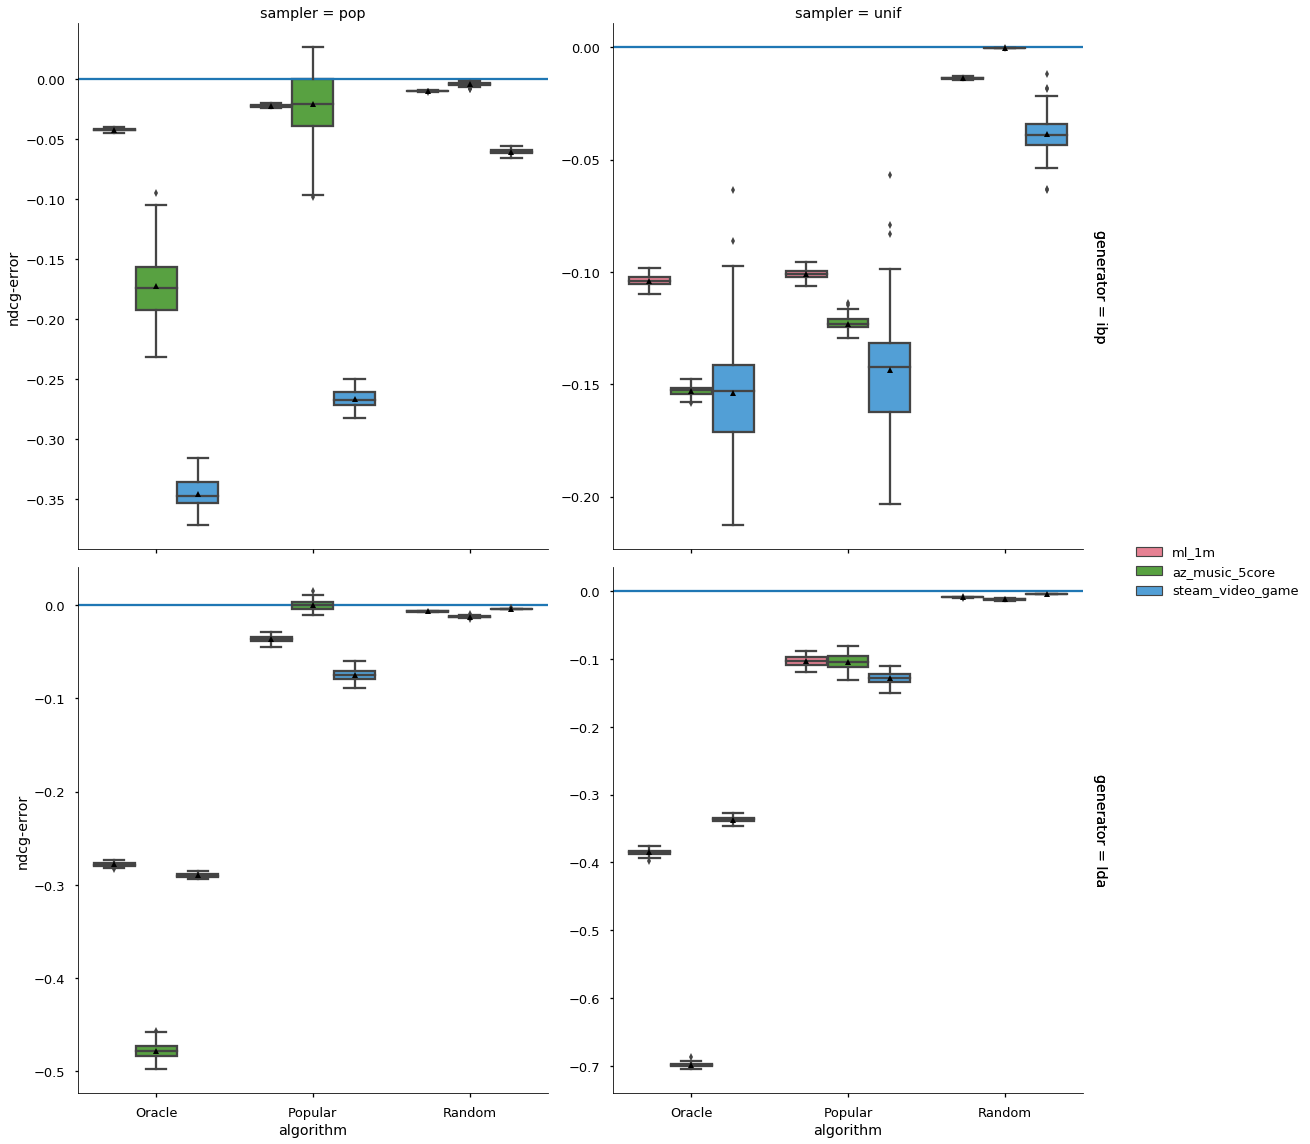

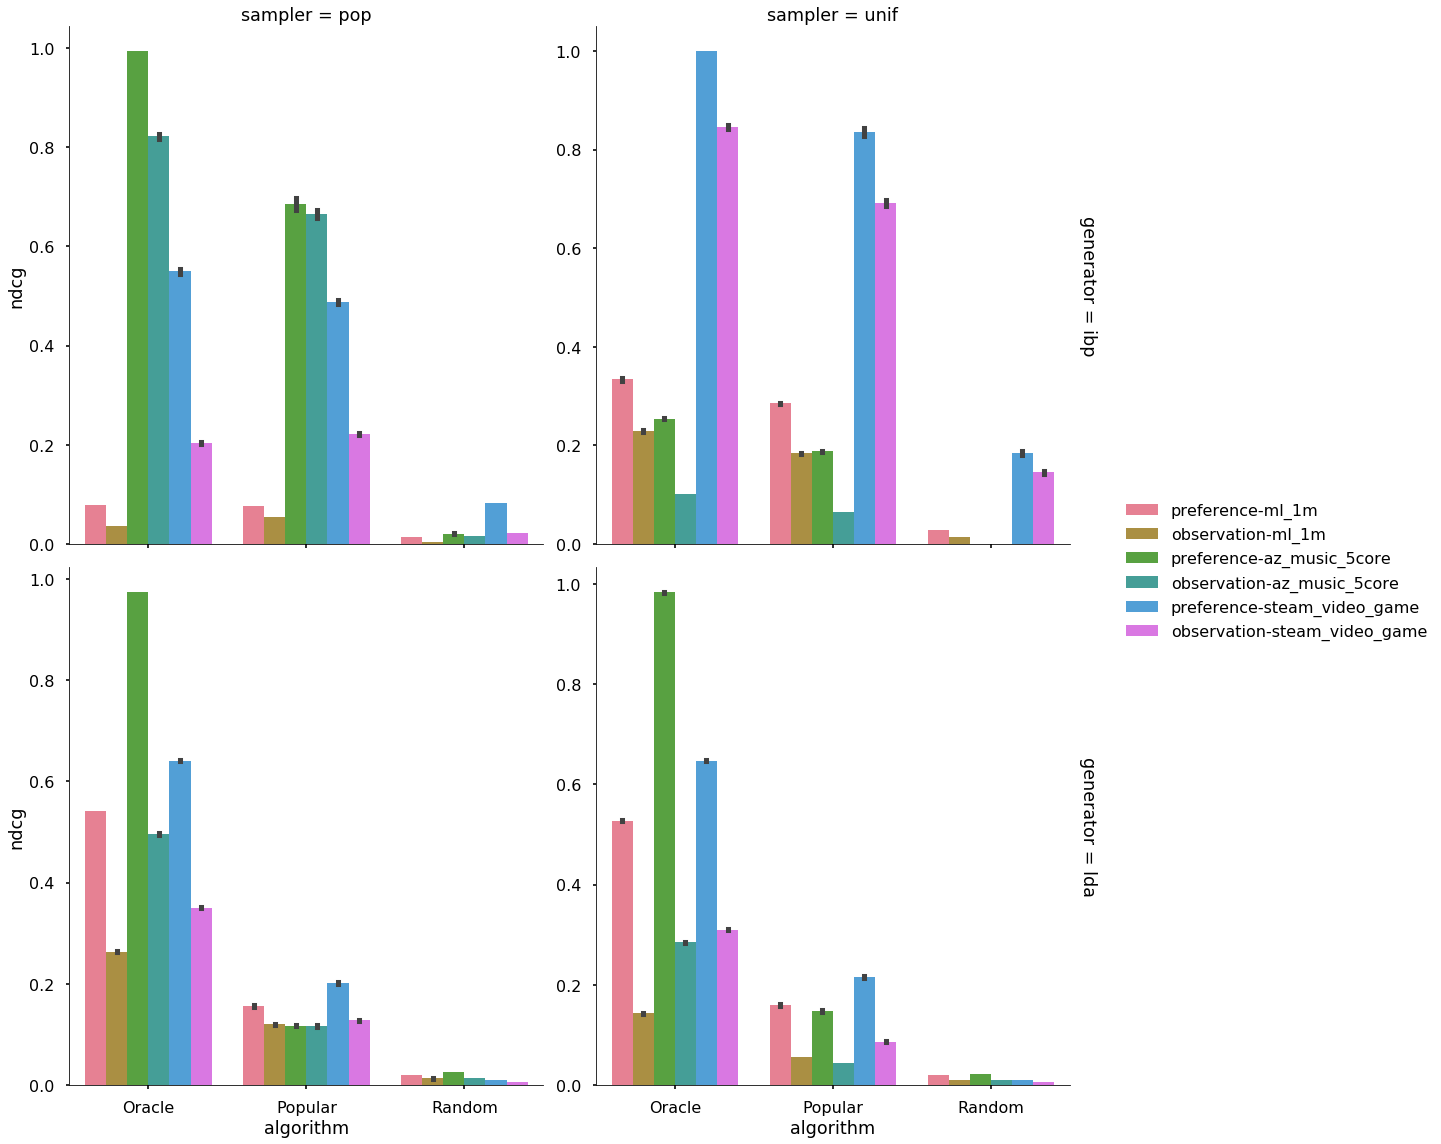

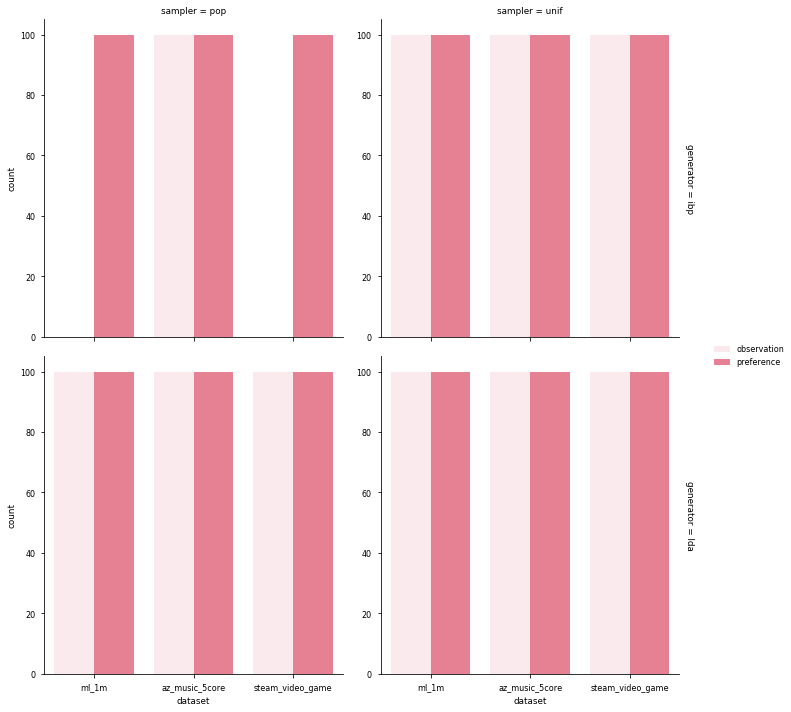

In [39]:
data2plot = extract_result(results, metric='ndcg', stats_to_tune='icorr')

plot_metric_stats(data2plot, 'ndcg', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'ndcg', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

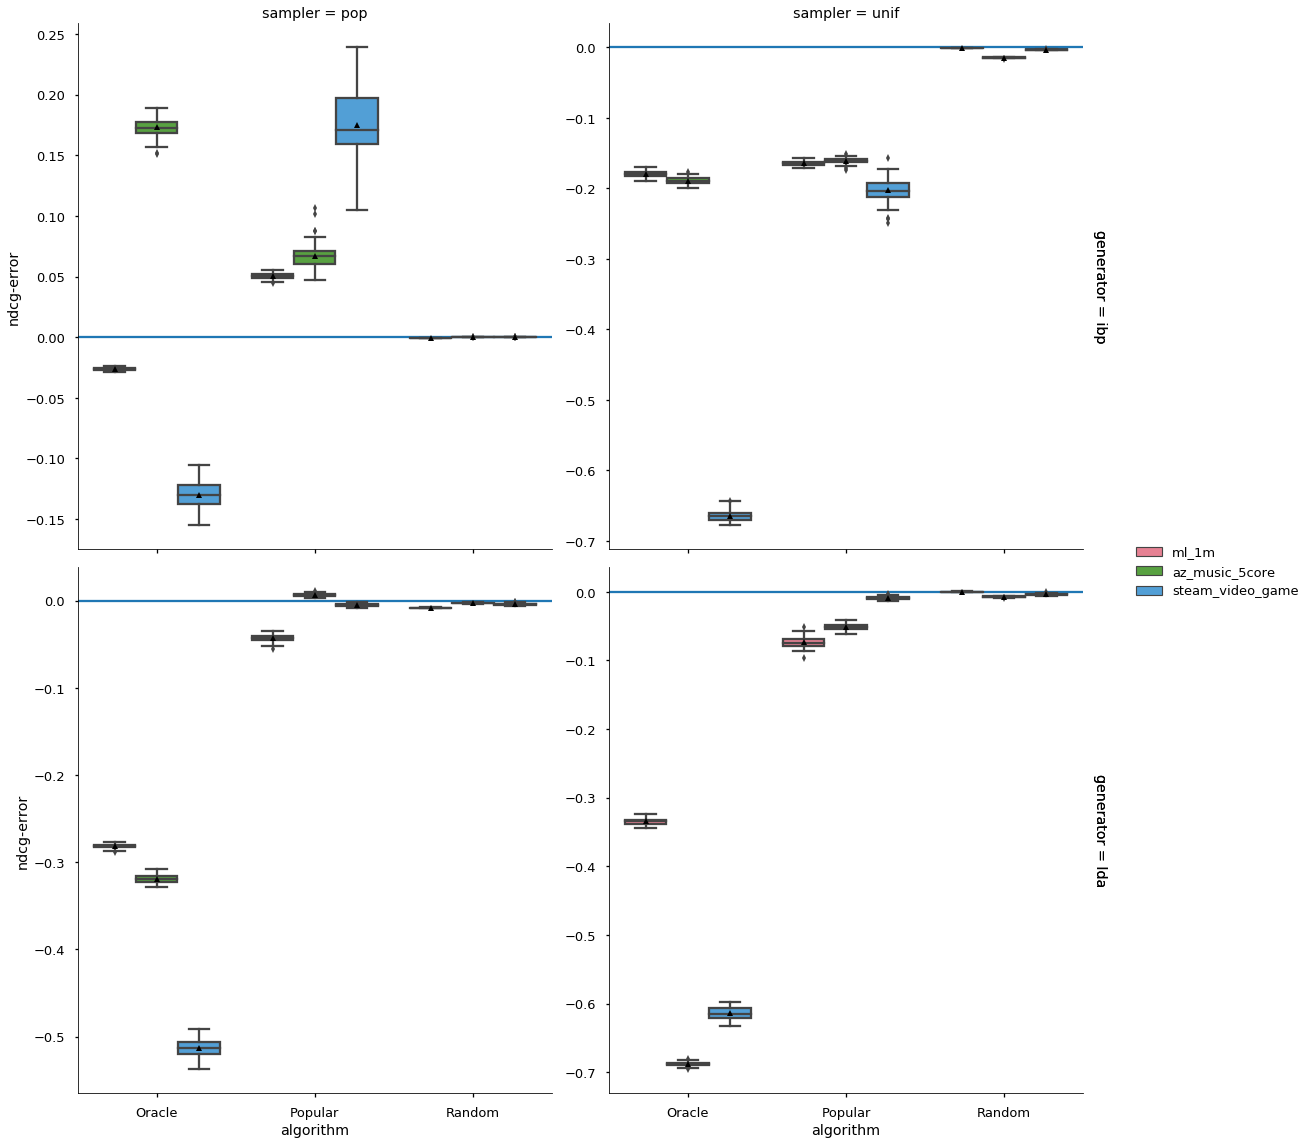

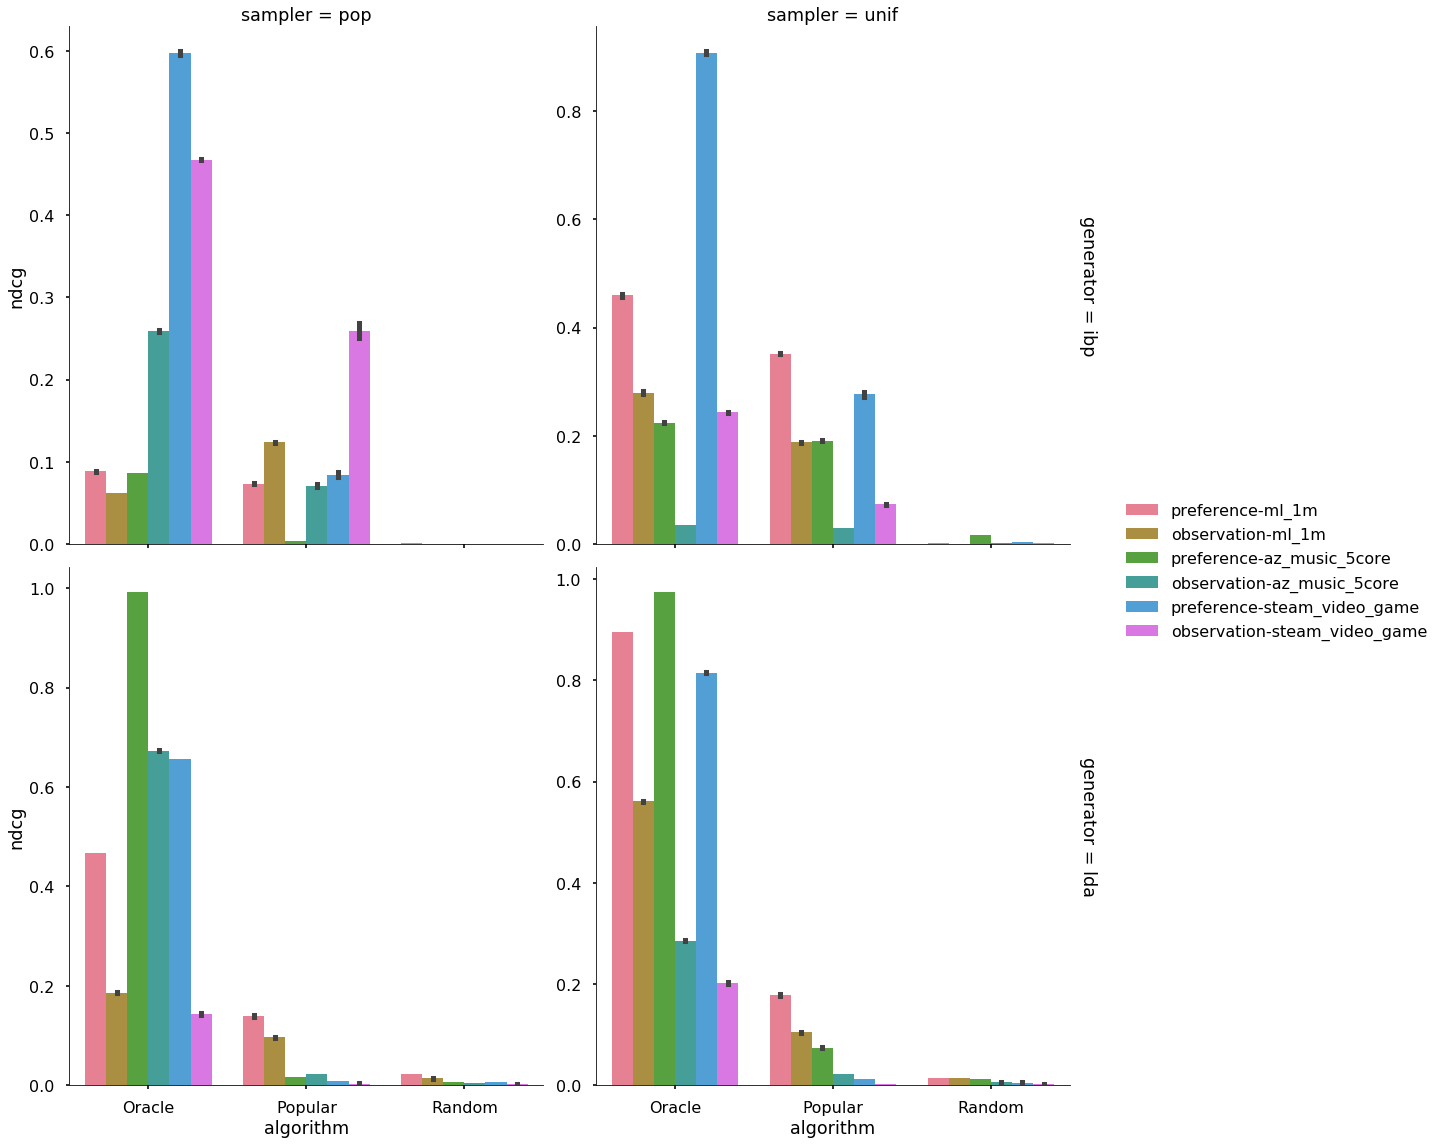

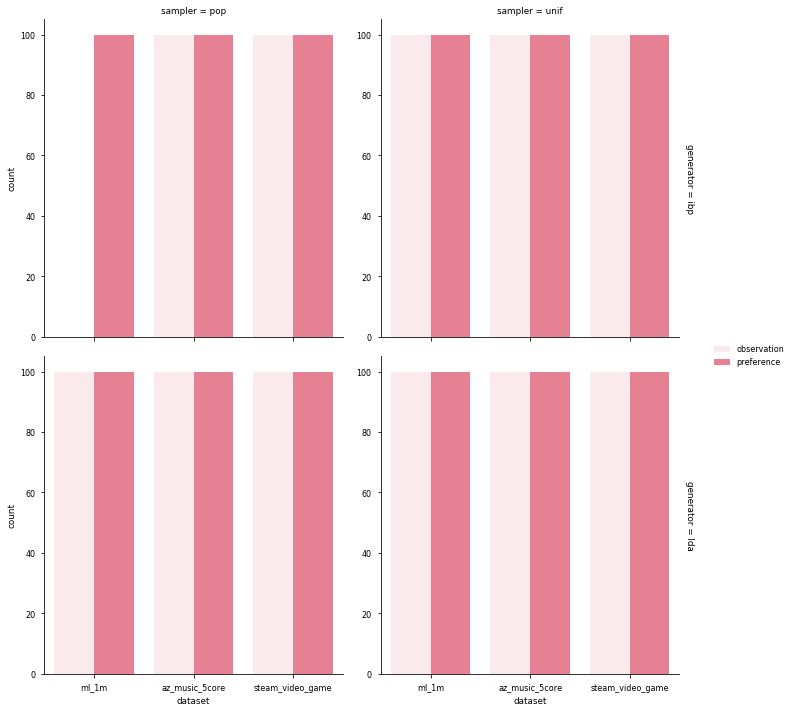

In [40]:
data2plot = extract_result(results, metric='ndcg', stats_to_tune='ucorr')

plot_metric_stats(data2plot, 'ndcg', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'ndcg', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

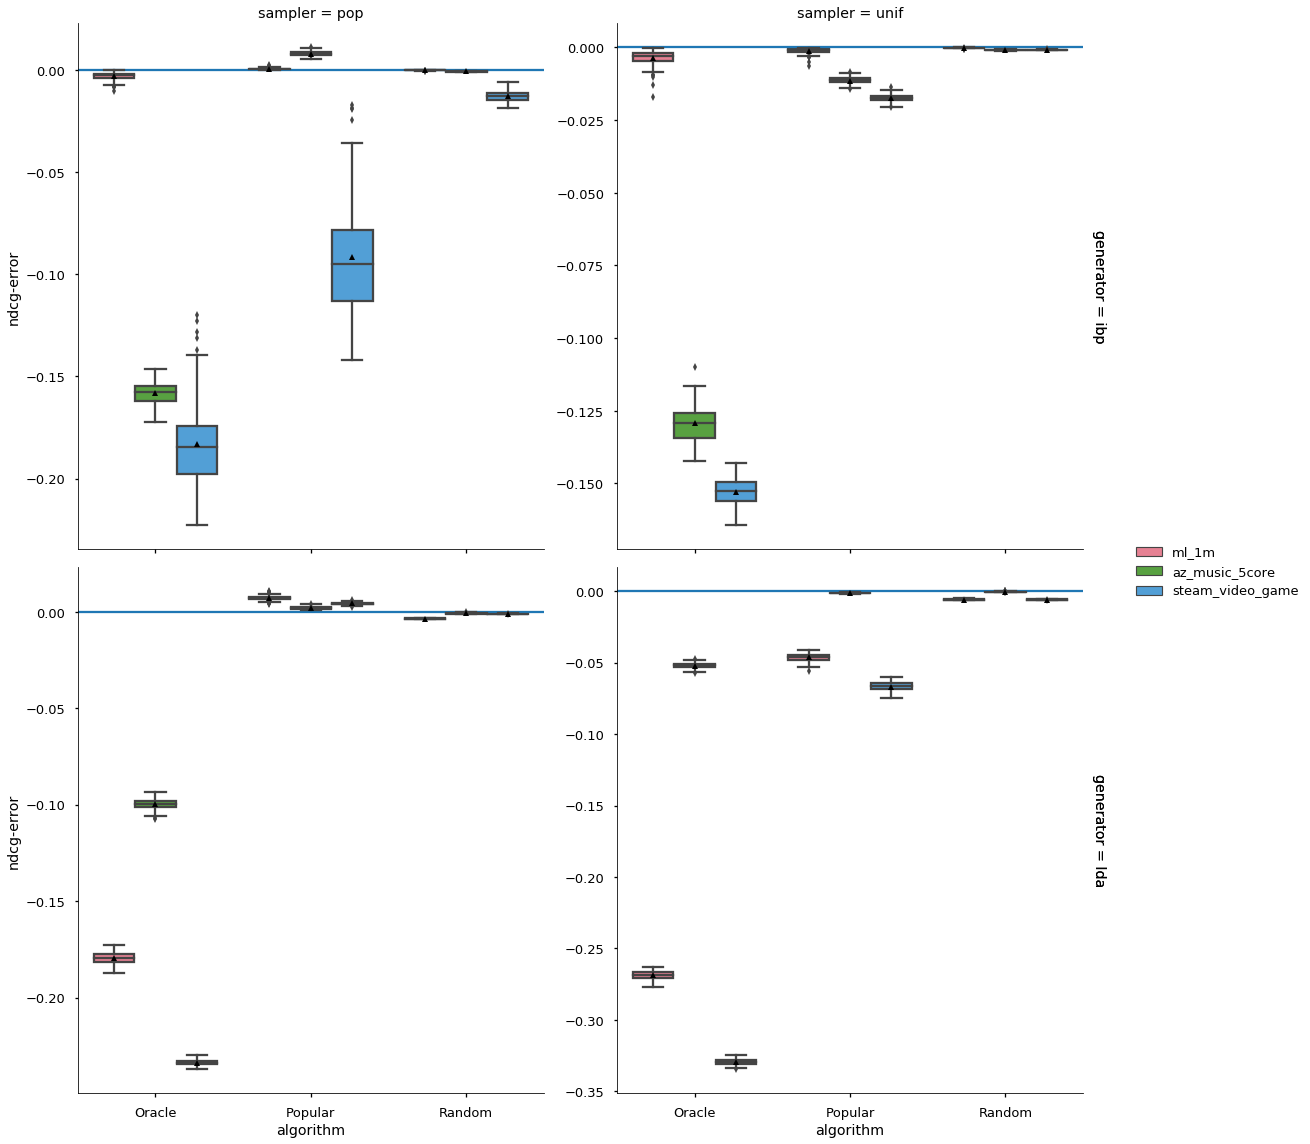

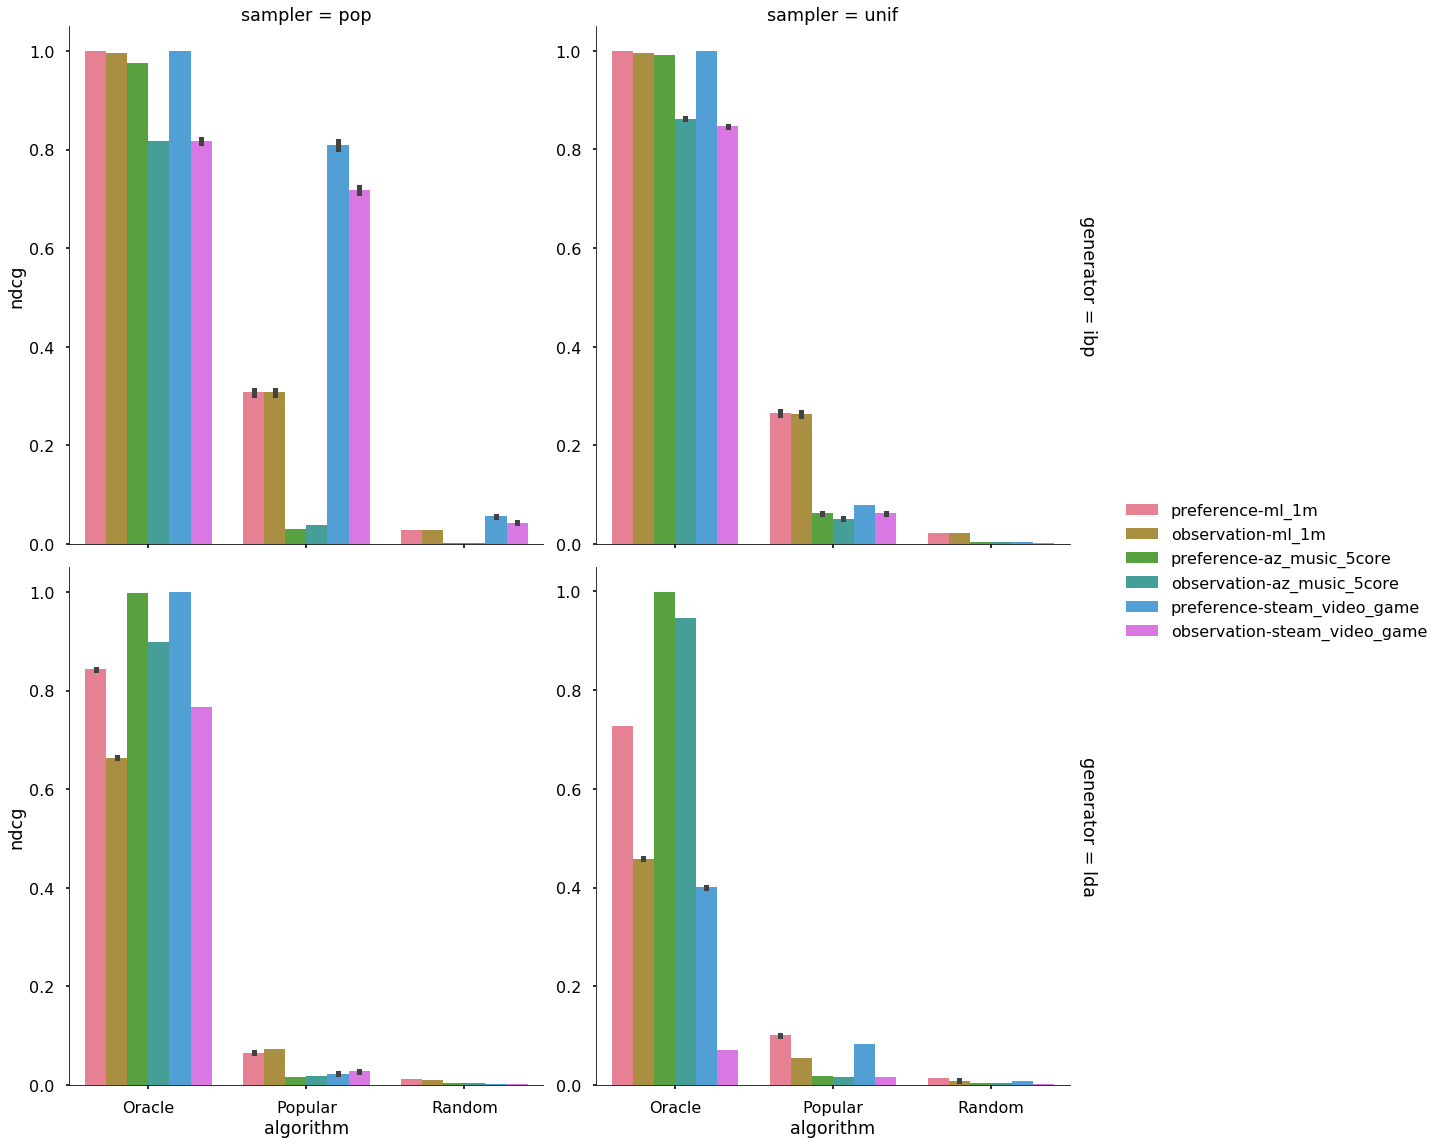

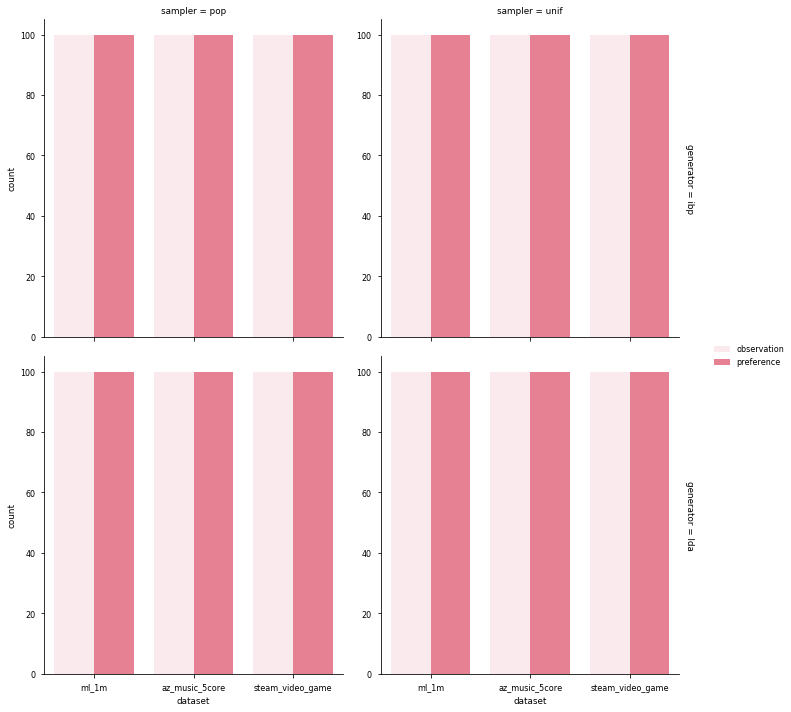

In [41]:
data2plot = extract_result(results, metric='ndcg', stats_to_tune='item-pop')

plot_metric_stats(data2plot, 'ndcg', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'ndcg', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

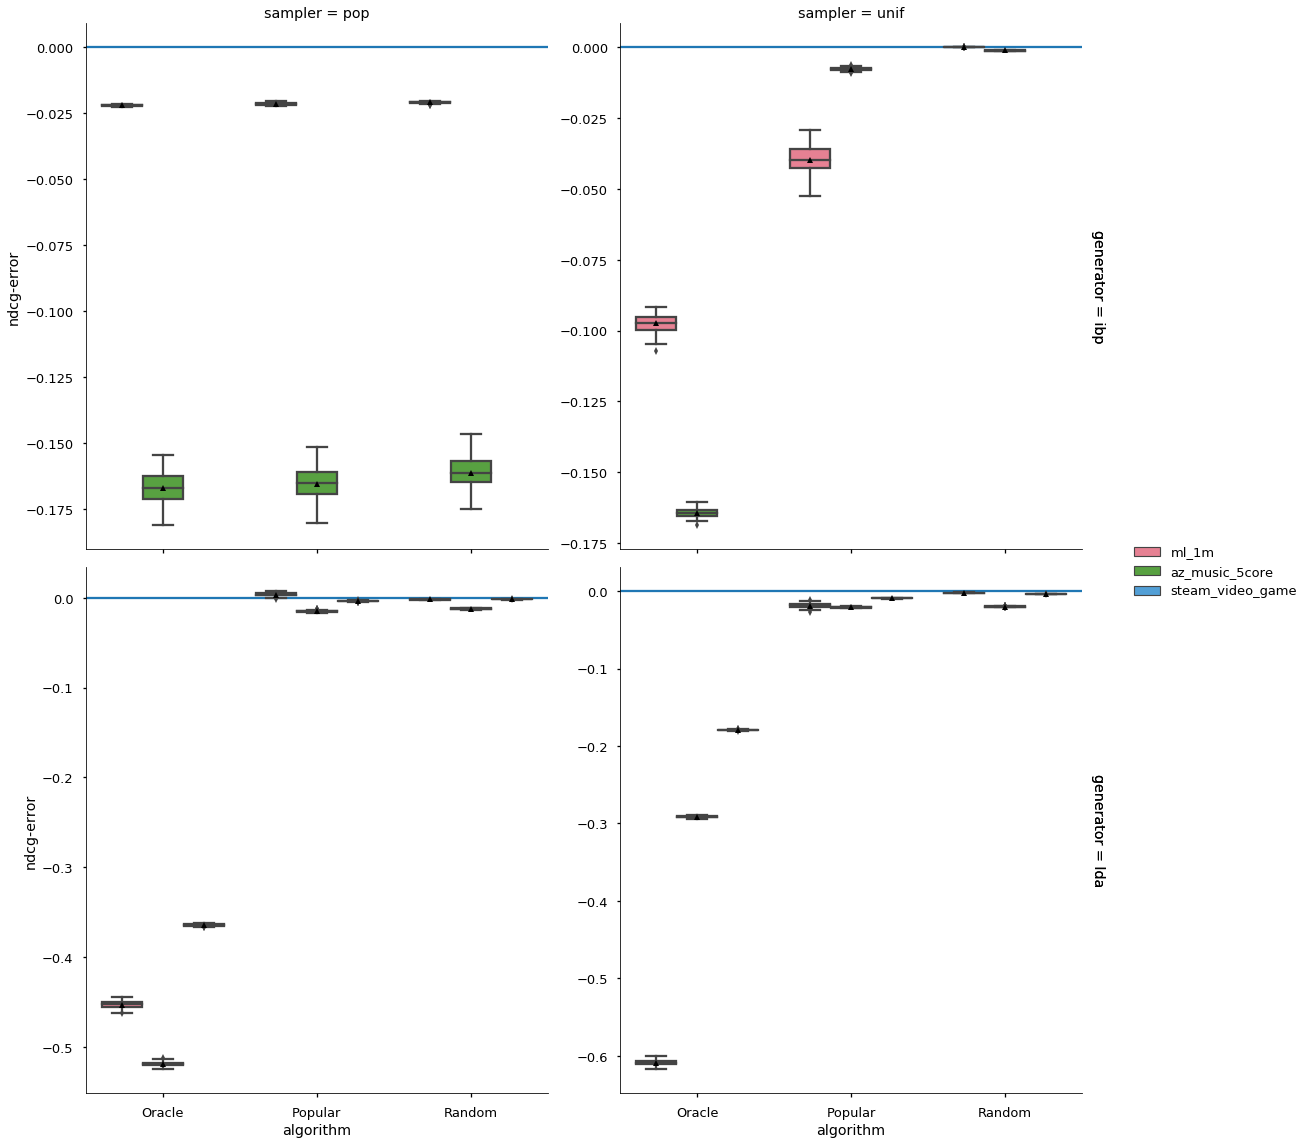

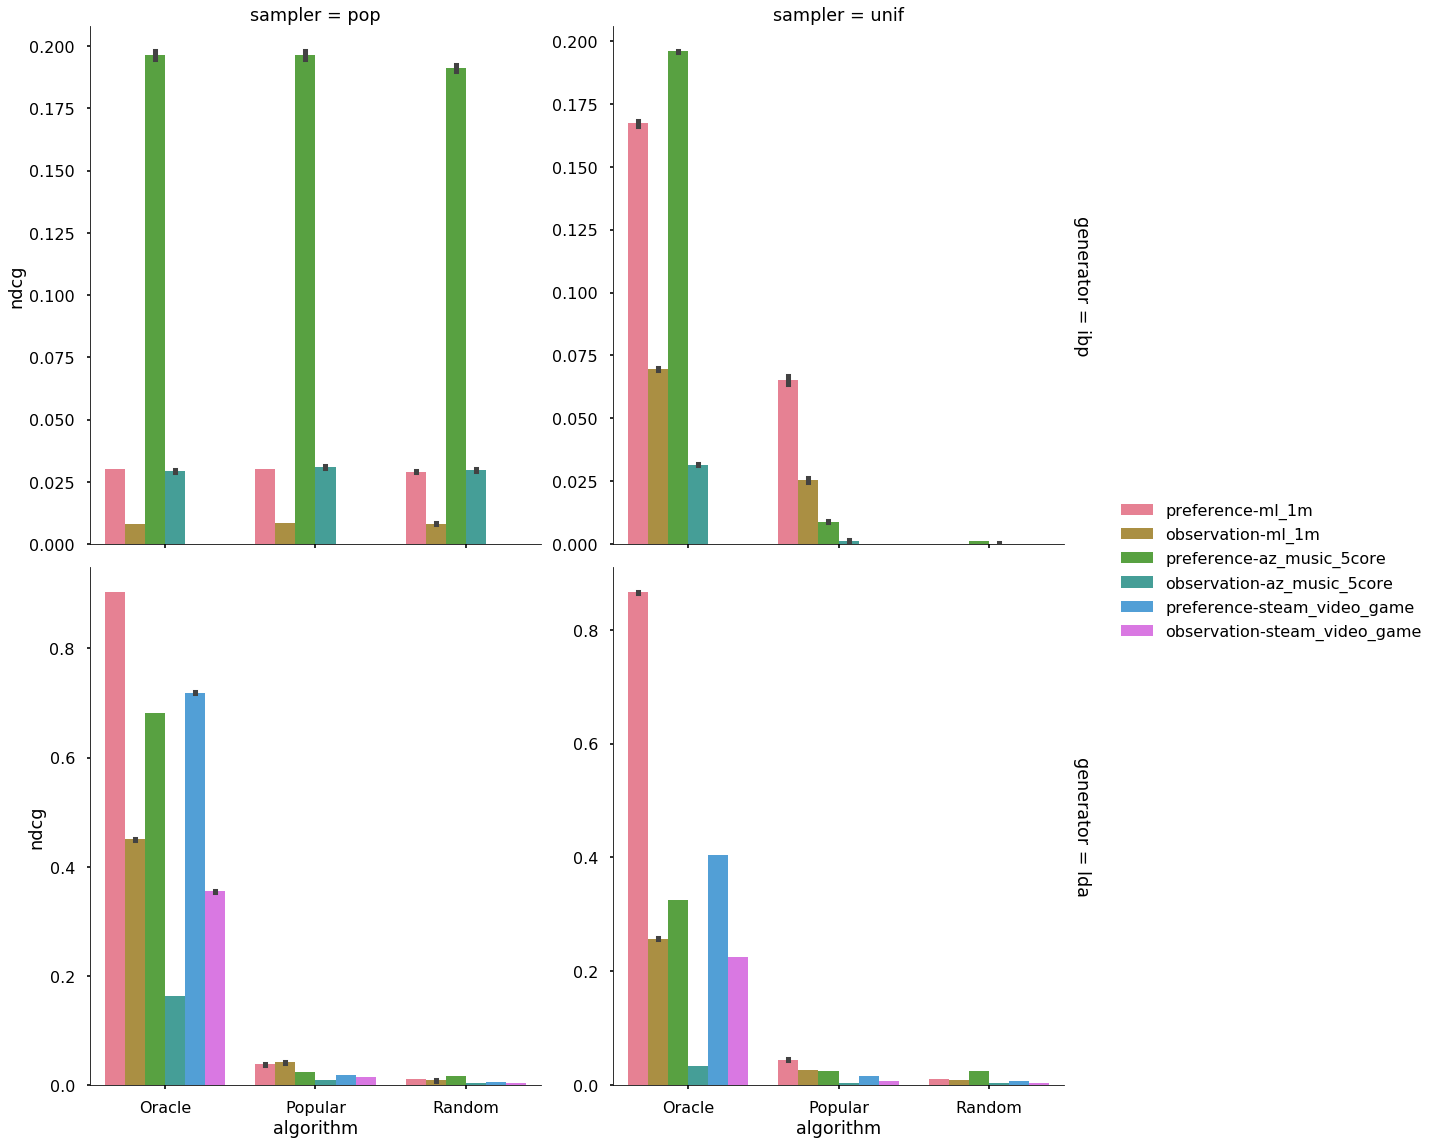

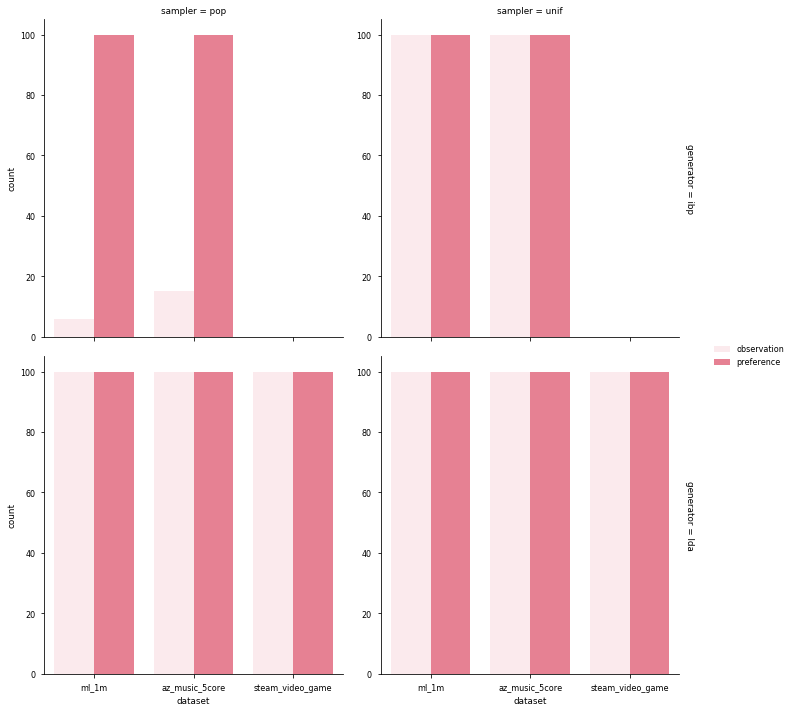

In [42]:
data2plot = extract_result(results, metric='ndcg', stats_to_tune='user-act')

plot_metric_stats(data2plot, 'ndcg', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'ndcg', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)

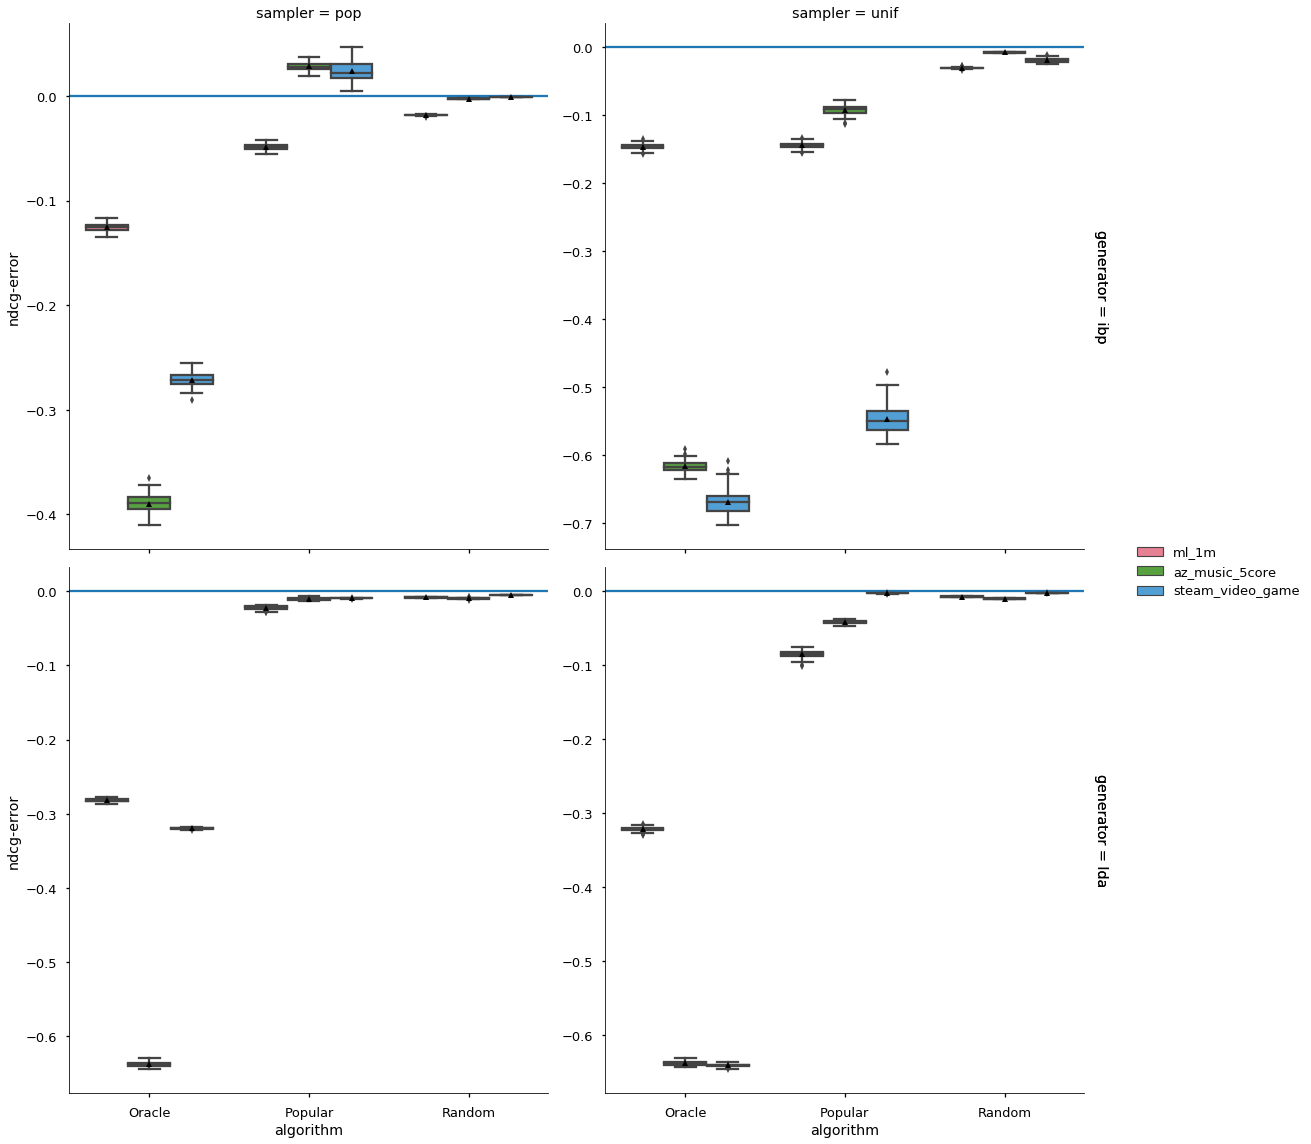

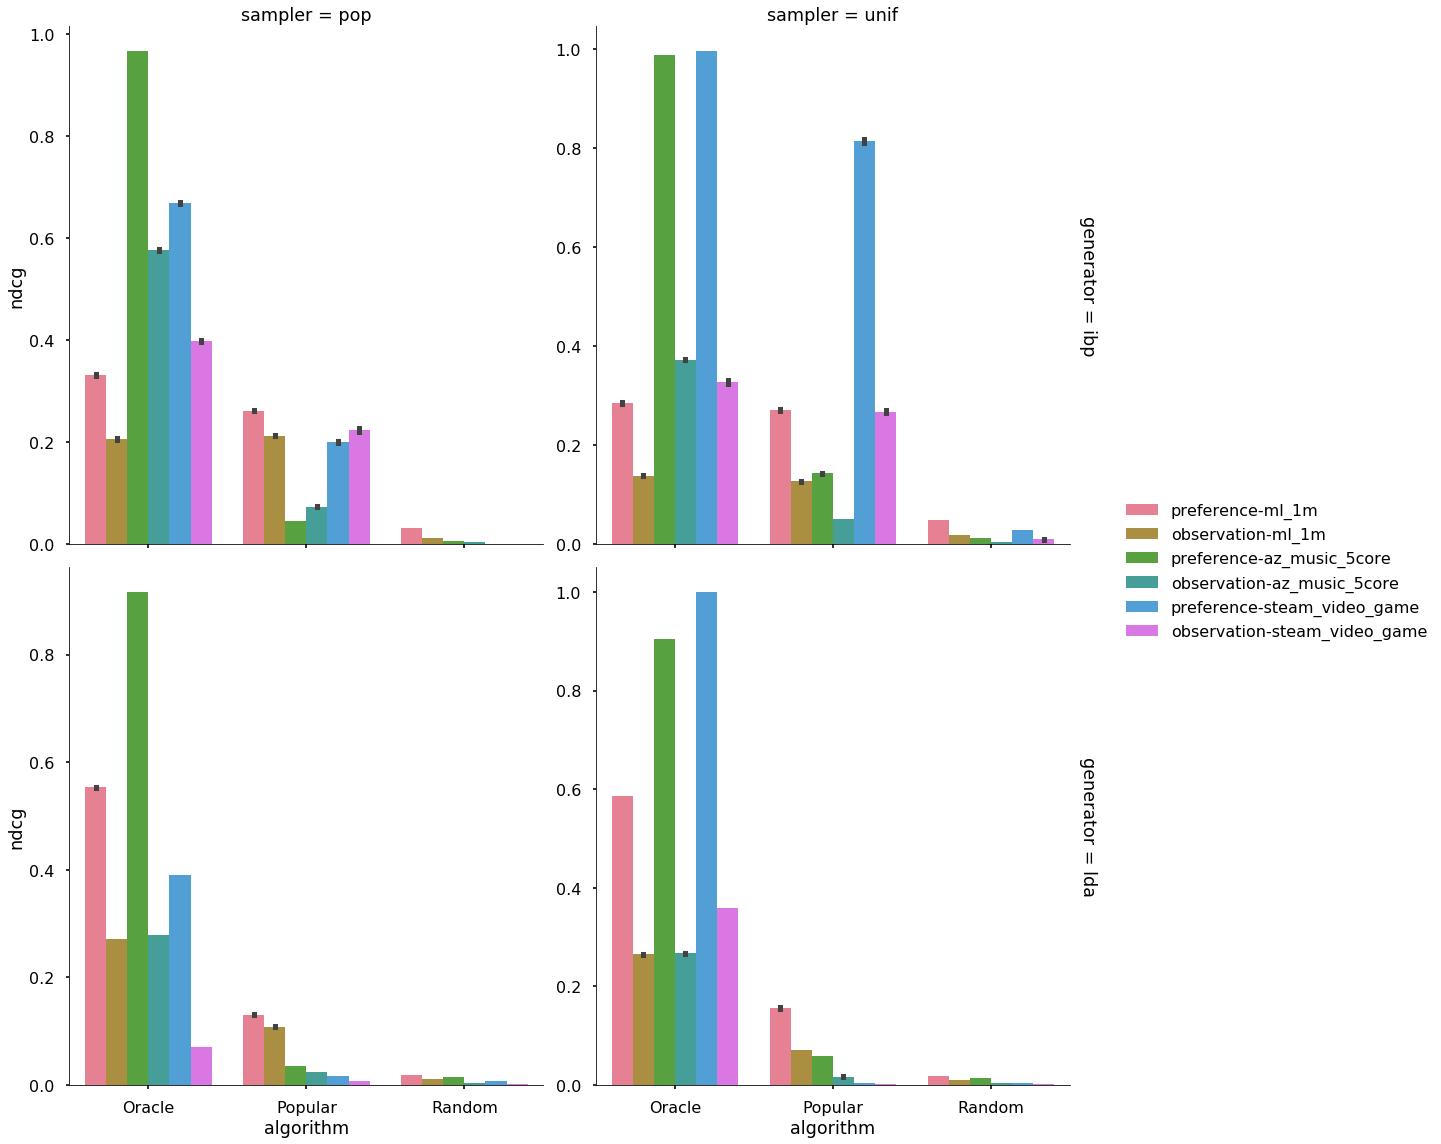

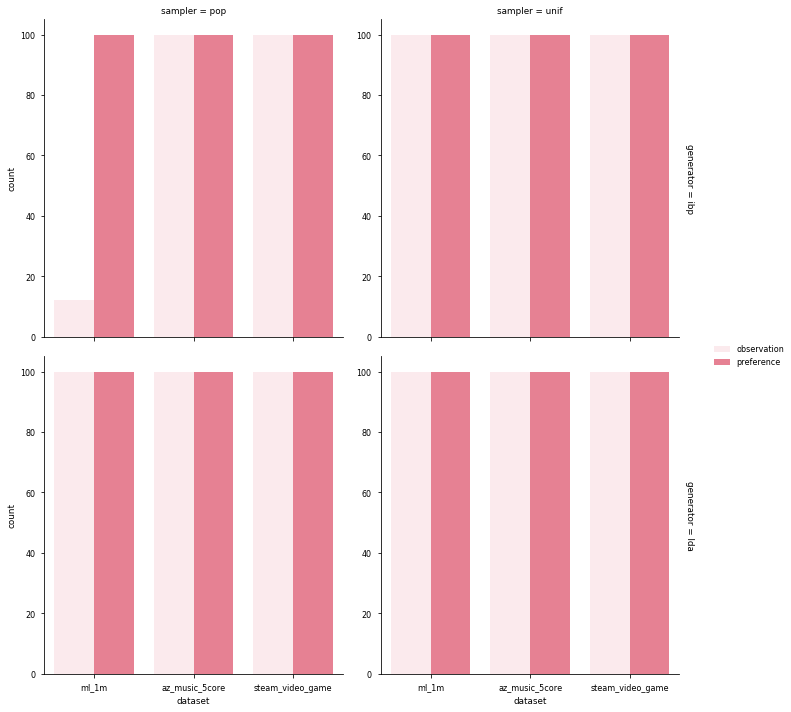

In [43]:
data2plot = extract_result(results, metric='ndcg', stats_to_tune='all')

plot_metric_stats(data2plot, 'ndcg', 'error', sns.boxplot, 
                  order=['Oracle', 'Popular', 'Random'],
                  hue_order=['ml_1m', 'az_music_5core', 'steam_video_game'],
                  palette='husl', showmeans=True, meanprops=dict(markerfacecolor='black'))

plot_metric_stats_dtype(data2plot, 'ndcg', sns.barplot,
                        order=['Oracle', 'Popular', 'Random'], 
                        hue_order=hue_order,
                        palette='husl')

plot_rank_percentage(rank_algos(data2plot), hue_order=('observation', 'preference'), order=dataset)